In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scipy
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=2698048eb5ff0efa28c49fda24c5295e96a8af1ff016e3619eeede5c01358f71
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
import scipy.io
import numpy as np
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mat_file_path = 'NLS.mat'

# Load the .mat file
mat_data = scipy.io.loadmat(mat_file_path)

# Display the keys in the loaded data
print(mat_data.keys())
data = mat_data

dict_keys(['__header__', '__version__', '__globals__', 'tt', 'uu', 'x'])


In [ ]:
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']

Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
noise = 0.0

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)
X0 = np.concatenate((x0, 0*x0), 1)
X_lb = np.concatenate((0*tb + lb[0], tb), 1)
X_ub = np.concatenate((0*tb + ub[0], tb), 1)


In [ ]:
x0 = X0[:,0:1]
t0 = X0[:,1:2]

x_lb = X_lb[:,0:1]
t_lb = X_lb[:,1:2]

x_ub = X_ub[:,0:1]
t_ub = X_ub[:,1:2]

x_f = X_f[:,0:1]
t_f = X_f[:,1:2]

u0 = u0
v0 = v0

In [ ]:
input_size = 10
hidden_size = 20
output_size = 1
num_epochs = 20
learning_rate = 1e-4
l2_lambda = 0.01

In [ ]:
torch.manual_seed(42)  # For reproducibility
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100,2)
        self.relu = nn.Tanh() #change activation
        nn.init.xavier_normal_(self.fc1.weight, gain=1.0, generator=None)
        nn.init.xavier_normal_(self.fc2.weight, gain=1.0, generator=None)
        nn.init.xavier_normal_(self.fc3.weight, gain=1.0, generator=None)
        nn.init.xavier_normal_(self.fc4.weight, gain=1.0, generator=None)
        nn.init.xavier_normal_(self.fc5.weight, gain=1.0, generator=None)
    def forward(self, input_x,input_t):
        x = torch.cat([input_x,input_t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        x = self.fc1(x)
        x = self.relu(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
PATH = "/content/drive/My Drive/7014Models/model_3.pth"
### (2) Model
model = SimpleNN()
model = model.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0.01)

checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# model.eval()
# # - or -
model.train()

SimpleNN(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=2, bias=True)
  (relu): Tanh()
)

In [ ]:
def f(output, input_x_f, input_t_f):
    f_u_pred = output[:,0]
    f_v_pred = output[:,1]
    f_u_t_pred = torch.autograd.grad(f_u_pred.sum(),input_t_f,create_graph = True)[0]
    f_u_x_pred = torch.autograd.grad(f_u_pred.sum(),input_x_f,create_graph = True)[0]
    # print(f_u_t_pred.shape)
    f_u_xx_pred = torch.autograd.grad(f_u_x_pred.sum(),input_x_f,create_graph = True)[0]
    # print(f_u_xx_pred.shape)
    f_v_t_pred = torch.autograd.grad(f_v_pred.sum(),input_t_f,create_graph = True)[0]
    f_v_x_pred = torch.autograd.grad(f_v_pred.sum(),input_x_f,create_graph = True)[0]
    f_v_xx_pred = torch.autograd.grad(f_v_x_pred.sum(),input_x_f,create_graph = True)[0]
    # print("f_u_t_pred.shape is",f_u_t_pred.shape)
    # print("f_v_xx_pred.shape is",f_v_xx_pred.shape)
    f_u_pred = f_u_pred.unsqueeze(1)
    f_v_pred = f_v_pred.unsqueeze(1)
    # print("f_u_pred.shape is",f_u_pred.shape)
    # print("f_v_pred.shape is",f_v_pred.shape)
    f_u = f_u_t_pred + 0.5*f_v_xx_pred + (f_u_pred**2 + f_v_pred**2)*f_v_pred
    f_v = f_v_t_pred - 0.5*f_u_xx_pred - (f_u_pred**2 + f_v_pred**2)*f_u_pred
    # print(f_u.shape)
    return f_u, f_v

In [ ]:
def monitor_gradients(model):
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            gradients.append(param.grad.abs().mean().item())
        else:
            gradients.append(0)  # If no gradient, append 0
    return gradients

In [ ]:
parameters = model.fc1.parameters()
norm_type = 2
print(parameters)
for name, param in model.named_parameters():
    print(name,param)
# total_norm = torch.norm(
#     torch.stack([torch.norm(p.grad.detach(), norm_type) for p in parameters]), norm_type)

<generator object Module.parameters at 0x7c17481d5f50>
fc1.weight Parameter containing:
tensor([[ 1.3425e-01,  1.5877e-01],
        [ 2.2322e-01,  2.0504e-01],
        [ 2.2866e-01, -4.3706e-01],
        [-3.1871e-01, -1.4958e-01],
        [ 1.6868e-01, -2.9689e-01],
        [-1.5922e-01, -1.2682e-02],
        [ 8.8416e-02,  4.9298e-02],
        [ 4.0159e-01,  3.8671e-01],
        [-8.1883e-02, -1.2567e-01],
        [ 3.0642e-01, -4.6472e-01],
        [-2.2942e-02,  4.0155e-01],
        [ 1.1747e-01, -9.3854e-02],
        [-2.9541e-01,  2.7796e-01],
        [ 2.7037e-01,  1.9268e-01],
        [-2.6692e-01,  5.6320e-02],
        [-1.2966e-01,  1.4009e-01],
        [-2.5721e-01, -2.0520e-01],
        [-1.4105e-01,  3.8136e-01],
        [-9.4754e-02, -2.6952e-01],
        [-2.4339e-01, -2.0856e-01],
        [-3.3088e-01,  4.5437e-01],
        [ 2.6738e-01, -1.0463e-01],
        [-1.0493e-01, -7.3973e-02],
        [ 3.5027e-01, -7.4583e-02],
        [ 5.9328e-01,  6.6560e-01],
        [-4.

In [ ]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

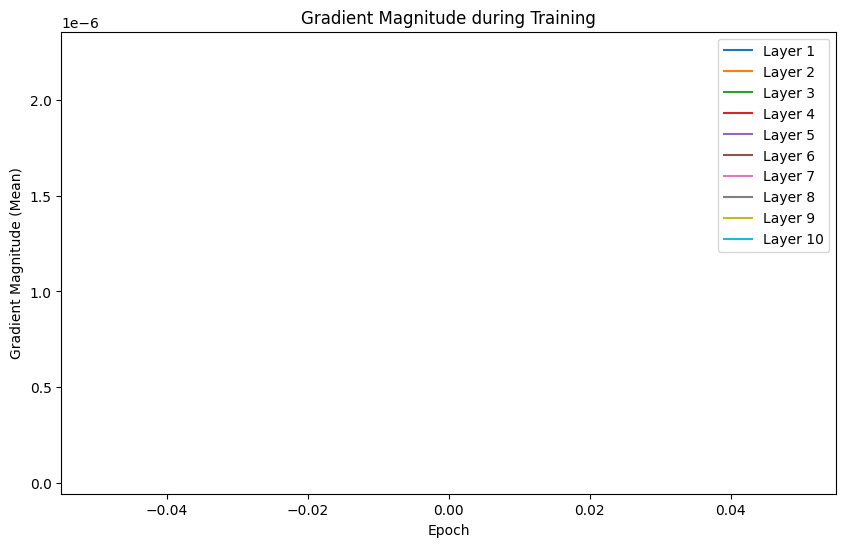

0 Training Loss: tensor(2.6939e-06)
1 Training Loss: tensor(2.6938e-06)
2 Training Loss: tensor(2.6939e-06)
3 Training Loss: tensor(2.6939e-06)
4 Training Loss: tensor(2.6937e-06)
5 Training Loss: tensor(2.6939e-06)
6 Training Loss: tensor(2.6939e-06)
7 Training Loss: tensor(2.6937e-06)
8 Training Loss: tensor(2.6937e-06)
9 Training Loss: tensor(2.6936e-06)
10 Training Loss: tensor(2.6937e-06)
11 Training Loss: tensor(2.6936e-06)
12 Training Loss: tensor(2.6935e-06)
13 Training Loss: tensor(2.6937e-06)
14 Training Loss: tensor(2.6936e-06)
15 Training Loss: tensor(2.6936e-06)
16 Training Loss: tensor(2.6935e-06)
17 Training Loss: tensor(2.6936e-06)
18 Training Loss: tensor(2.6935e-06)
19 Training Loss: tensor(2.6935e-06)
20 Training Loss: tensor(2.6934e-06)
21 Training Loss: tensor(2.6934e-06)
22 Training Loss: tensor(2.6934e-06)
23 Training Loss: tensor(2.6934e-06)
24 Training Loss: tensor(2.6934e-06)
25 Training Loss: tensor(2.6934e-06)
26 Training Loss: tensor(2.6935e-06)
27 Training

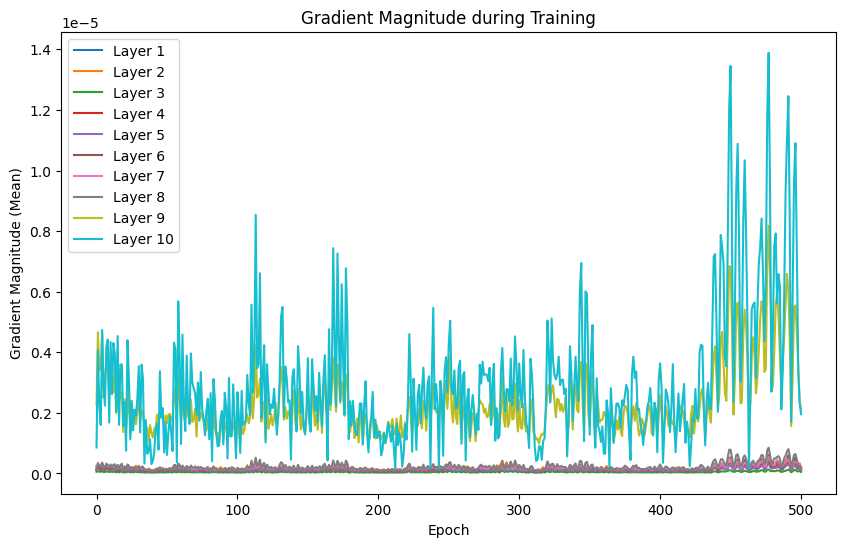

500 Training Loss: tensor(2.6856e-06)
501 Training Loss: tensor(2.6856e-06)
502 Training Loss: tensor(2.6856e-06)
503 Training Loss: tensor(2.6856e-06)
504 Training Loss: tensor(2.6855e-06)
505 Training Loss: tensor(2.6856e-06)
506 Training Loss: tensor(2.6855e-06)
507 Training Loss: tensor(2.6855e-06)
508 Training Loss: tensor(2.6854e-06)
509 Training Loss: tensor(2.6854e-06)
510 Training Loss: tensor(2.6854e-06)
511 Training Loss: tensor(2.6852e-06)
512 Training Loss: tensor(2.6853e-06)
513 Training Loss: tensor(2.6854e-06)
514 Training Loss: tensor(2.6855e-06)
515 Training Loss: tensor(2.6853e-06)
516 Training Loss: tensor(2.6854e-06)
517 Training Loss: tensor(2.6853e-06)
518 Training Loss: tensor(2.6853e-06)
519 Training Loss: tensor(2.6852e-06)
520 Training Loss: tensor(2.6853e-06)
521 Training Loss: tensor(2.6854e-06)
522 Training Loss: tensor(2.6852e-06)
523 Training Loss: tensor(2.6852e-06)
524 Training Loss: tensor(2.6852e-06)
525 Training Loss: tensor(2.6852e-06)
526 Training

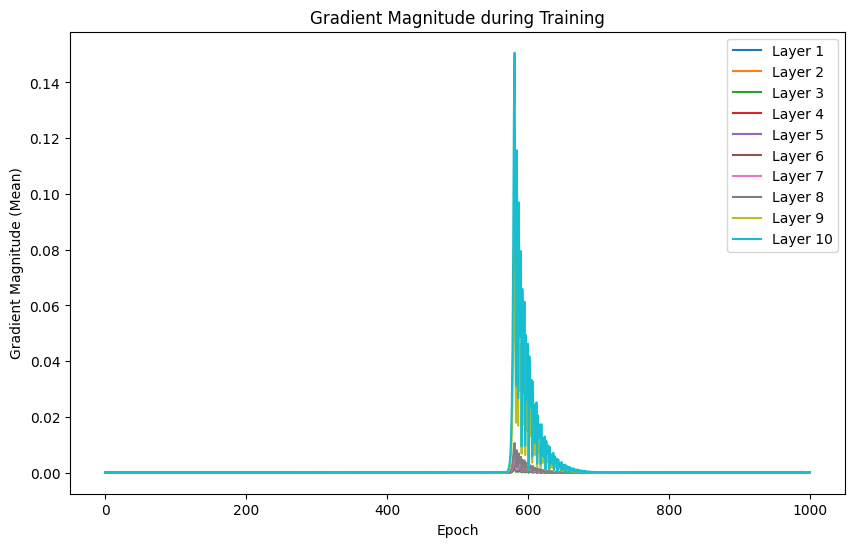

1000 Training Loss: tensor(2.6796e-06)
1001 Training Loss: tensor(2.6794e-06)
1002 Training Loss: tensor(2.6794e-06)
1003 Training Loss: tensor(2.6795e-06)
1004 Training Loss: tensor(2.6794e-06)
1005 Training Loss: tensor(2.6793e-06)
1006 Training Loss: tensor(2.6793e-06)
1007 Training Loss: tensor(2.6793e-06)
1008 Training Loss: tensor(2.6793e-06)
1009 Training Loss: tensor(2.6793e-06)
1010 Training Loss: tensor(2.6793e-06)
1011 Training Loss: tensor(2.6793e-06)
1012 Training Loss: tensor(2.6792e-06)
1013 Training Loss: tensor(2.6793e-06)
1014 Training Loss: tensor(2.6792e-06)
1015 Training Loss: tensor(2.6793e-06)
1016 Training Loss: tensor(2.6792e-06)
1017 Training Loss: tensor(2.6792e-06)
1018 Training Loss: tensor(2.6791e-06)
1019 Training Loss: tensor(2.6791e-06)
1020 Training Loss: tensor(2.6792e-06)
1021 Training Loss: tensor(2.6791e-06)
1022 Training Loss: tensor(2.6791e-06)
1023 Training Loss: tensor(2.6791e-06)
1024 Training Loss: tensor(2.6790e-06)
1025 Training Loss: tenso

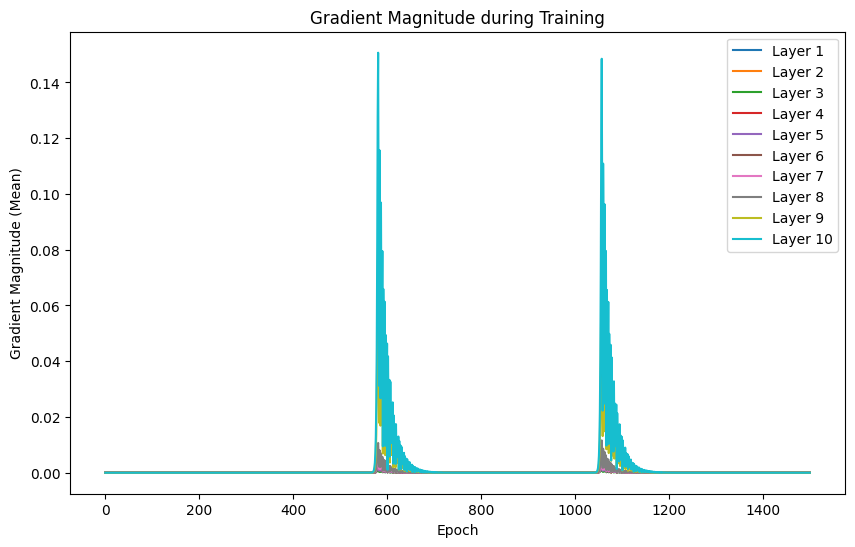

1500 Training Loss: tensor(2.6744e-06)
1501 Training Loss: tensor(2.6743e-06)
1502 Training Loss: tensor(2.6743e-06)
1503 Training Loss: tensor(2.6744e-06)
1504 Training Loss: tensor(2.6743e-06)
1505 Training Loss: tensor(2.6741e-06)
1506 Training Loss: tensor(2.6742e-06)
1507 Training Loss: tensor(2.6742e-06)
1508 Training Loss: tensor(2.6743e-06)
1509 Training Loss: tensor(2.6743e-06)
1510 Training Loss: tensor(2.6742e-06)
1511 Training Loss: tensor(2.6741e-06)
1512 Training Loss: tensor(2.6742e-06)
1513 Training Loss: tensor(2.6742e-06)
1514 Training Loss: tensor(2.6741e-06)
1515 Training Loss: tensor(2.6741e-06)
1516 Training Loss: tensor(2.6740e-06)
1517 Training Loss: tensor(2.6741e-06)
1518 Training Loss: tensor(2.6741e-06)
1519 Training Loss: tensor(2.6740e-06)
1520 Training Loss: tensor(2.6741e-06)
1521 Training Loss: tensor(2.6739e-06)
1522 Training Loss: tensor(2.6740e-06)
1523 Training Loss: tensor(2.6740e-06)
1524 Training Loss: tensor(2.6740e-06)
1525 Training Loss: tenso

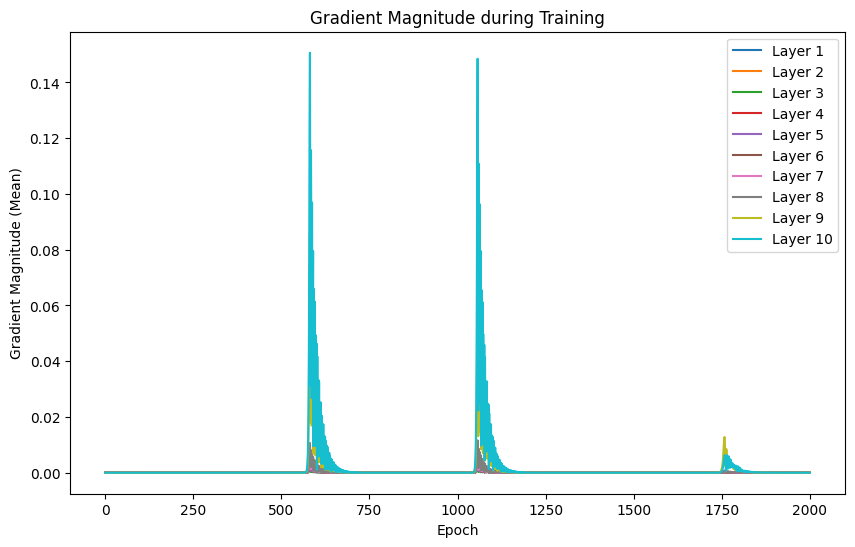

2000 Training Loss: tensor(2.6661e-06)
2001 Training Loss: tensor(2.6662e-06)
2002 Training Loss: tensor(2.6662e-06)
2003 Training Loss: tensor(2.6662e-06)
2004 Training Loss: tensor(2.6661e-06)
2005 Training Loss: tensor(2.6660e-06)
2006 Training Loss: tensor(2.6661e-06)
2007 Training Loss: tensor(2.6661e-06)
2008 Training Loss: tensor(2.6660e-06)
2009 Training Loss: tensor(2.6659e-06)
2010 Training Loss: tensor(2.6660e-06)
2011 Training Loss: tensor(2.6659e-06)
2012 Training Loss: tensor(2.6660e-06)
2013 Training Loss: tensor(2.6660e-06)
2014 Training Loss: tensor(2.6660e-06)
2015 Training Loss: tensor(2.6658e-06)
2016 Training Loss: tensor(2.6658e-06)
2017 Training Loss: tensor(2.6658e-06)
2018 Training Loss: tensor(2.6658e-06)
2019 Training Loss: tensor(2.6658e-06)
2020 Training Loss: tensor(2.6656e-06)
2021 Training Loss: tensor(2.6657e-06)
2022 Training Loss: tensor(2.6657e-06)
2023 Training Loss: tensor(2.6658e-06)
2024 Training Loss: tensor(2.6657e-06)
2025 Training Loss: tenso

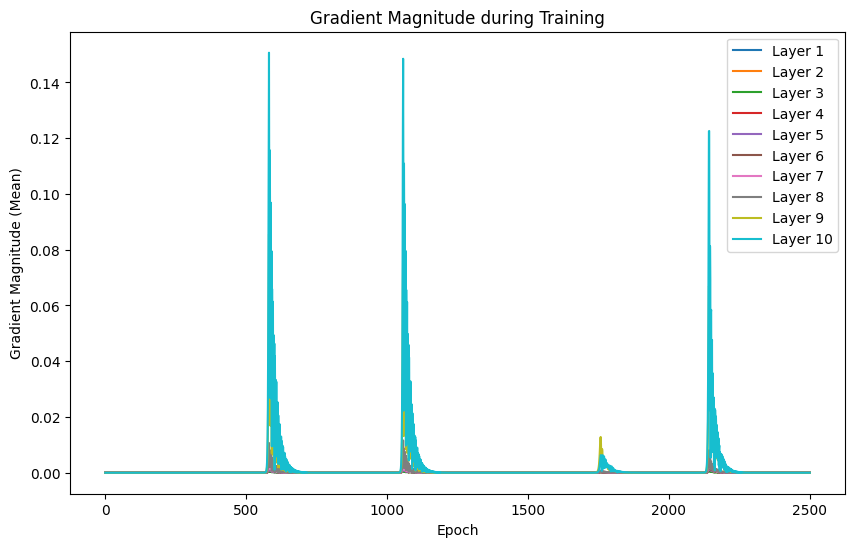

2500 Training Loss: tensor(2.6596e-06)
2501 Training Loss: tensor(2.6596e-06)
2502 Training Loss: tensor(2.6596e-06)
2503 Training Loss: tensor(2.6595e-06)
2504 Training Loss: tensor(2.6595e-06)
2505 Training Loss: tensor(2.6595e-06)
2506 Training Loss: tensor(2.6594e-06)
2507 Training Loss: tensor(2.6594e-06)
2508 Training Loss: tensor(2.6594e-06)
2509 Training Loss: tensor(2.6593e-06)
2510 Training Loss: tensor(2.6593e-06)
2511 Training Loss: tensor(2.6594e-06)
2512 Training Loss: tensor(2.6594e-06)
2513 Training Loss: tensor(2.6594e-06)
2514 Training Loss: tensor(2.6594e-06)
2515 Training Loss: tensor(2.6594e-06)
2516 Training Loss: tensor(2.6593e-06)
2517 Training Loss: tensor(2.6593e-06)
2518 Training Loss: tensor(2.6592e-06)
2519 Training Loss: tensor(2.6593e-06)
2520 Training Loss: tensor(2.6594e-06)
2521 Training Loss: tensor(2.6594e-06)
2522 Training Loss: tensor(2.6594e-06)
2523 Training Loss: tensor(2.6593e-06)
2524 Training Loss: tensor(2.6592e-06)
2525 Training Loss: tenso

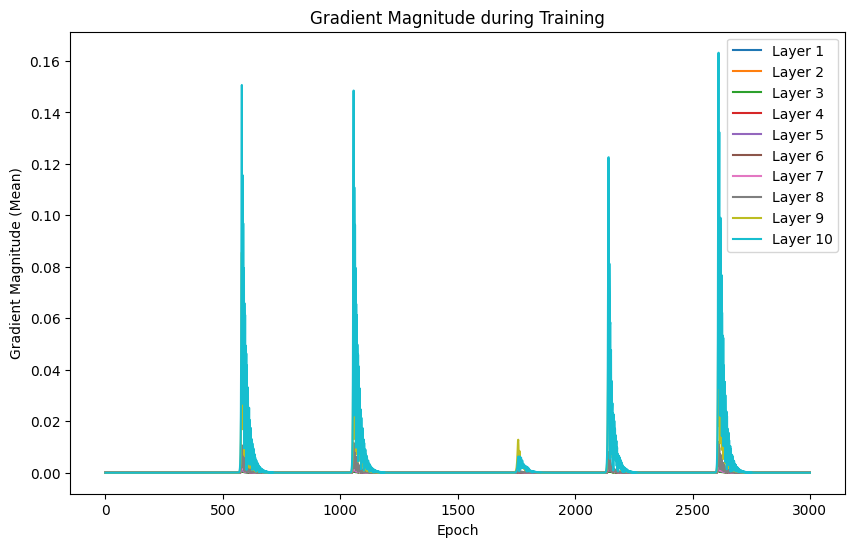

3000 Training Loss: tensor(2.6551e-06)
3001 Training Loss: tensor(2.6549e-06)
3002 Training Loss: tensor(2.6549e-06)
3003 Training Loss: tensor(2.6550e-06)
3004 Training Loss: tensor(2.6550e-06)
3005 Training Loss: tensor(2.6550e-06)
3006 Training Loss: tensor(2.6549e-06)
3007 Training Loss: tensor(2.6550e-06)
3008 Training Loss: tensor(2.6549e-06)
3009 Training Loss: tensor(2.6549e-06)
3010 Training Loss: tensor(2.6549e-06)
3011 Training Loss: tensor(2.6550e-06)
3012 Training Loss: tensor(2.6549e-06)
3013 Training Loss: tensor(2.6550e-06)
3014 Training Loss: tensor(2.6549e-06)
3015 Training Loss: tensor(2.6547e-06)
3016 Training Loss: tensor(2.6548e-06)
3017 Training Loss: tensor(2.6547e-06)
3018 Training Loss: tensor(2.6549e-06)
3019 Training Loss: tensor(2.6550e-06)
3020 Training Loss: tensor(2.6549e-06)
3021 Training Loss: tensor(2.6547e-06)
3022 Training Loss: tensor(2.6547e-06)
3023 Training Loss: tensor(2.6547e-06)
3024 Training Loss: tensor(2.6548e-06)
3025 Training Loss: tenso

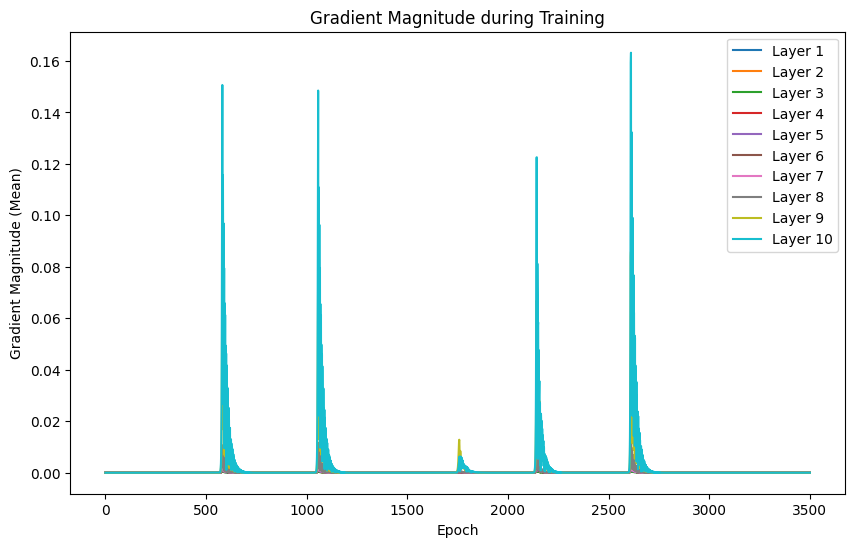

3500 Training Loss: tensor(2.6472e-06)
3501 Training Loss: tensor(2.6472e-06)
3502 Training Loss: tensor(2.6471e-06)
3503 Training Loss: tensor(2.6470e-06)
3504 Training Loss: tensor(2.6473e-06)
3505 Training Loss: tensor(2.6471e-06)
3506 Training Loss: tensor(2.6476e-06)
3507 Training Loss: tensor(2.6488e-06)
3508 Training Loss: tensor(2.6534e-06)
3509 Training Loss: tensor(2.6683e-06)
3510 Training Loss: tensor(2.7188e-06)
3511 Training Loss: tensor(2.8902e-06)
3512 Training Loss: tensor(3.4738e-06)
3513 Training Loss: tensor(5.4638e-06)
3514 Training Loss: tensor(1.2240e-05)
3515 Training Loss: tensor(3.5066e-05)
3516 Training Loss: tensor(0.0001)
3517 Training Loss: tensor(0.0003)
3518 Training Loss: tensor(0.0007)
3519 Training Loss: tensor(0.0007)
3520 Training Loss: tensor(0.0002)
3521 Training Loss: tensor(0.0001)
3522 Training Loss: tensor(0.0004)
3523 Training Loss: tensor(0.0002)
3524 Training Loss: tensor(7.2500e-05)
3525 Training Loss: tensor(0.0003)
3526 Training Loss: te

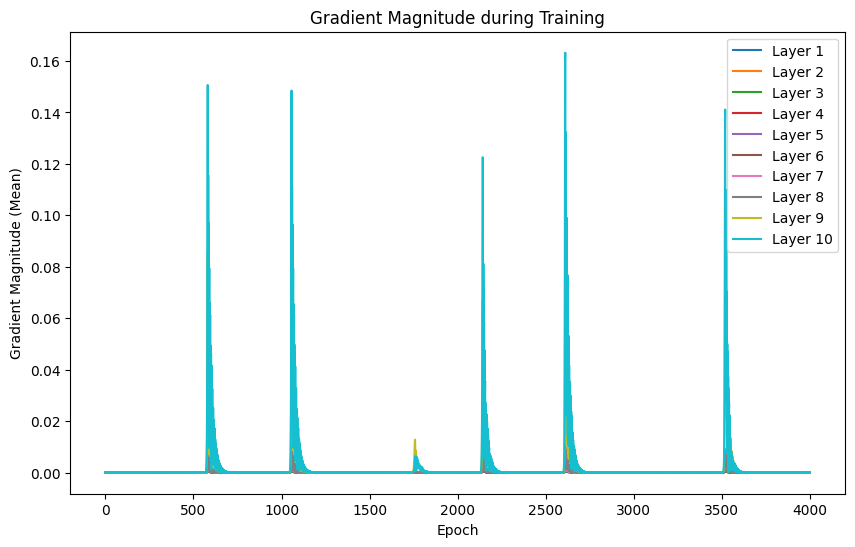

4000 Training Loss: tensor(2.6417e-06)
4001 Training Loss: tensor(2.6415e-06)
4002 Training Loss: tensor(2.6416e-06)
4003 Training Loss: tensor(2.6414e-06)
4004 Training Loss: tensor(2.6416e-06)
4005 Training Loss: tensor(2.6415e-06)
4006 Training Loss: tensor(2.6417e-06)
4007 Training Loss: tensor(2.6415e-06)
4008 Training Loss: tensor(2.6415e-06)
4009 Training Loss: tensor(2.6414e-06)
4010 Training Loss: tensor(2.6414e-06)
4011 Training Loss: tensor(2.6414e-06)
4012 Training Loss: tensor(2.6415e-06)
4013 Training Loss: tensor(2.6414e-06)
4014 Training Loss: tensor(2.6414e-06)
4015 Training Loss: tensor(2.6414e-06)
4016 Training Loss: tensor(2.6413e-06)
4017 Training Loss: tensor(2.6413e-06)
4018 Training Loss: tensor(2.6413e-06)
4019 Training Loss: tensor(2.6413e-06)
4020 Training Loss: tensor(2.6413e-06)
4021 Training Loss: tensor(2.6413e-06)
4022 Training Loss: tensor(2.6413e-06)
4023 Training Loss: tensor(2.6412e-06)
4024 Training Loss: tensor(2.6413e-06)
4025 Training Loss: tenso

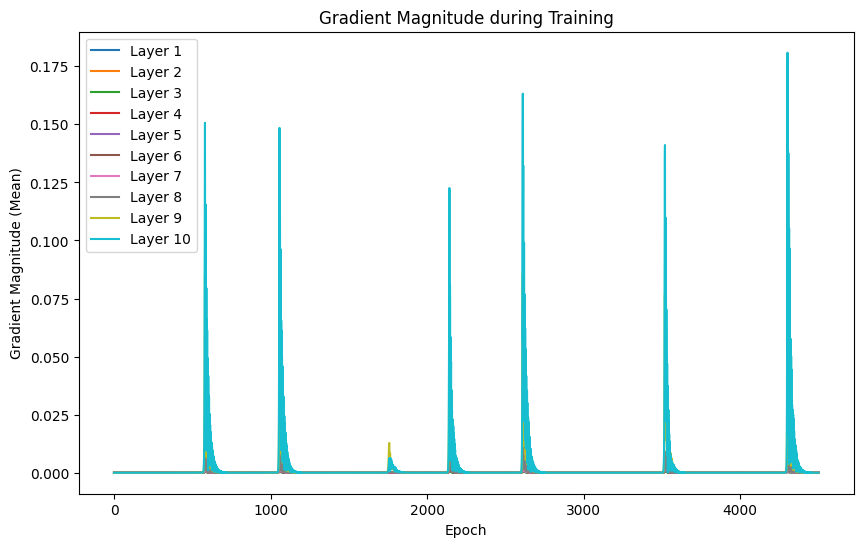

4500 Training Loss: tensor(2.6384e-06)
4501 Training Loss: tensor(2.6384e-06)
4502 Training Loss: tensor(2.6385e-06)
4503 Training Loss: tensor(2.6384e-06)
4504 Training Loss: tensor(2.6384e-06)
4505 Training Loss: tensor(2.6385e-06)
4506 Training Loss: tensor(2.6384e-06)
4507 Training Loss: tensor(2.6383e-06)
4508 Training Loss: tensor(2.6383e-06)
4509 Training Loss: tensor(2.6382e-06)
4510 Training Loss: tensor(2.6383e-06)
4511 Training Loss: tensor(2.6383e-06)
4512 Training Loss: tensor(2.6382e-06)
4513 Training Loss: tensor(2.6382e-06)
4514 Training Loss: tensor(2.6380e-06)
4515 Training Loss: tensor(2.6381e-06)
4516 Training Loss: tensor(2.6380e-06)
4517 Training Loss: tensor(2.6381e-06)
4518 Training Loss: tensor(2.6381e-06)
4519 Training Loss: tensor(2.6380e-06)
4520 Training Loss: tensor(2.6381e-06)
4521 Training Loss: tensor(2.6380e-06)
4522 Training Loss: tensor(2.6380e-06)
4523 Training Loss: tensor(2.6379e-06)
4524 Training Loss: tensor(2.6380e-06)
4525 Training Loss: tenso

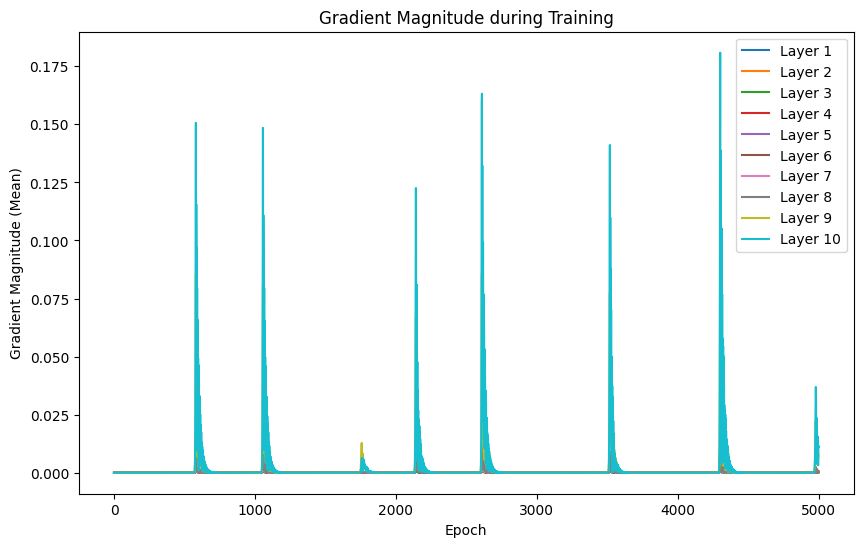

5000 Training Loss: tensor(9.9148e-06)
5001 Training Loss: tensor(8.2018e-06)
5002 Training Loss: tensor(3.3856e-06)
5003 Training Loss: tensor(5.1709e-06)
5004 Training Loss: tensor(8.4281e-06)
5005 Training Loss: tensor(6.3740e-06)
5006 Training Loss: tensor(4.8480e-06)
5007 Training Loss: tensor(5.3235e-06)
5008 Training Loss: tensor(3.9432e-06)
5009 Training Loss: tensor(3.7437e-06)
5010 Training Loss: tensor(5.7280e-06)
5011 Training Loss: tensor(5.1762e-06)
5012 Training Loss: tensor(3.2763e-06)
5013 Training Loss: tensor(3.5661e-06)
5014 Training Loss: tensor(3.9333e-06)
5015 Training Loss: tensor(3.4267e-06)
5016 Training Loss: tensor(3.9329e-06)
5017 Training Loss: tensor(4.1500e-06)
5018 Training Loss: tensor(3.0395e-06)
5019 Training Loss: tensor(2.7866e-06)
5020 Training Loss: tensor(3.4675e-06)
5021 Training Loss: tensor(3.3658e-06)
5022 Training Loss: tensor(3.1148e-06)
5023 Training Loss: tensor(3.3138e-06)
5024 Training Loss: tensor(3.0313e-06)
5025 Training Loss: tenso

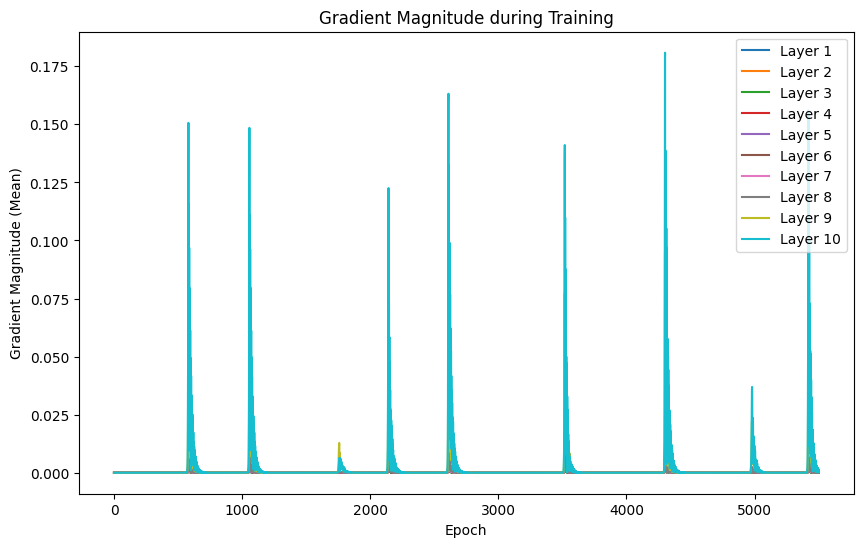

5500 Training Loss: tensor(2.6630e-06)
5501 Training Loss: tensor(2.7158e-06)
5502 Training Loss: tensor(2.7016e-06)
5503 Training Loss: tensor(2.6573e-06)
5504 Training Loss: tensor(2.7123e-06)
5505 Training Loss: tensor(2.6449e-06)
5506 Training Loss: tensor(2.6838e-06)
5507 Training Loss: tensor(2.6639e-06)
5508 Training Loss: tensor(2.6471e-06)
5509 Training Loss: tensor(2.6771e-06)
5510 Training Loss: tensor(2.6324e-06)
5511 Training Loss: tensor(2.6664e-06)
5512 Training Loss: tensor(2.6418e-06)
5513 Training Loss: tensor(2.6421e-06)
5514 Training Loss: tensor(2.6544e-06)
5515 Training Loss: tensor(2.6271e-06)
5516 Training Loss: tensor(2.6534e-06)
5517 Training Loss: tensor(2.6287e-06)
5518 Training Loss: tensor(2.6401e-06)
5519 Training Loss: tensor(2.6381e-06)
5520 Training Loss: tensor(2.6273e-06)
5521 Training Loss: tensor(2.6420e-06)
5522 Training Loss: tensor(2.6245e-06)
5523 Training Loss: tensor(2.6369e-06)
5524 Training Loss: tensor(2.6291e-06)
5525 Training Loss: tenso

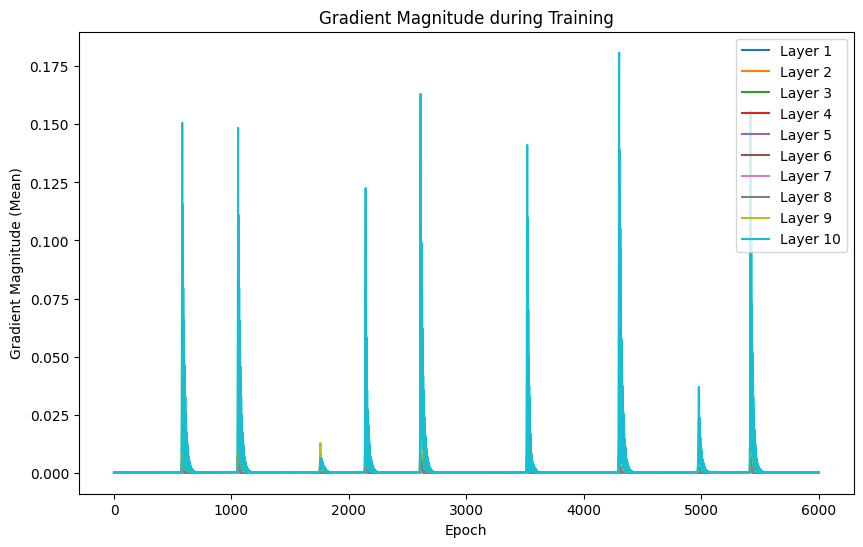

6000 Training Loss: tensor(2.6170e-06)
6001 Training Loss: tensor(2.6170e-06)
6002 Training Loss: tensor(2.6172e-06)
6003 Training Loss: tensor(2.6171e-06)
6004 Training Loss: tensor(2.6172e-06)
6005 Training Loss: tensor(2.6172e-06)
6006 Training Loss: tensor(2.6171e-06)
6007 Training Loss: tensor(2.6172e-06)
6008 Training Loss: tensor(2.6170e-06)
6009 Training Loss: tensor(2.6171e-06)
6010 Training Loss: tensor(2.6170e-06)
6011 Training Loss: tensor(2.6171e-06)
6012 Training Loss: tensor(2.6171e-06)
6013 Training Loss: tensor(2.6170e-06)
6014 Training Loss: tensor(2.6170e-06)
6015 Training Loss: tensor(2.6169e-06)
6016 Training Loss: tensor(2.6169e-06)
6017 Training Loss: tensor(2.6170e-06)
6018 Training Loss: tensor(2.6169e-06)
6019 Training Loss: tensor(2.6169e-06)
6020 Training Loss: tensor(2.6169e-06)
6021 Training Loss: tensor(2.6169e-06)
6022 Training Loss: tensor(2.6168e-06)
6023 Training Loss: tensor(2.6168e-06)
6024 Training Loss: tensor(2.6168e-06)
6025 Training Loss: tenso

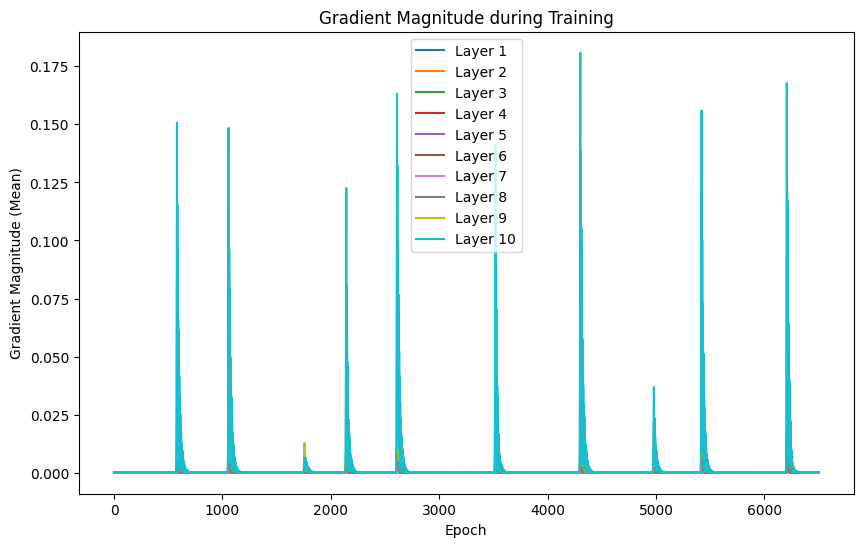

6500 Training Loss: tensor(2.6131e-06)
6501 Training Loss: tensor(2.6132e-06)
6502 Training Loss: tensor(2.6133e-06)
6503 Training Loss: tensor(2.6132e-06)
6504 Training Loss: tensor(2.6133e-06)
6505 Training Loss: tensor(2.6133e-06)
6506 Training Loss: tensor(2.6132e-06)
6507 Training Loss: tensor(2.6133e-06)
6508 Training Loss: tensor(2.6131e-06)
6509 Training Loss: tensor(2.6131e-06)
6510 Training Loss: tensor(2.6131e-06)
6511 Training Loss: tensor(2.6131e-06)
6512 Training Loss: tensor(2.6130e-06)
6513 Training Loss: tensor(2.6128e-06)
6514 Training Loss: tensor(2.6129e-06)
6515 Training Loss: tensor(2.6130e-06)
6516 Training Loss: tensor(2.6130e-06)
6517 Training Loss: tensor(2.6130e-06)
6518 Training Loss: tensor(2.6130e-06)
6519 Training Loss: tensor(2.6128e-06)
6520 Training Loss: tensor(2.6128e-06)
6521 Training Loss: tensor(2.6128e-06)
6522 Training Loss: tensor(2.6130e-06)
6523 Training Loss: tensor(2.6130e-06)
6524 Training Loss: tensor(2.6131e-06)
6525 Training Loss: tenso

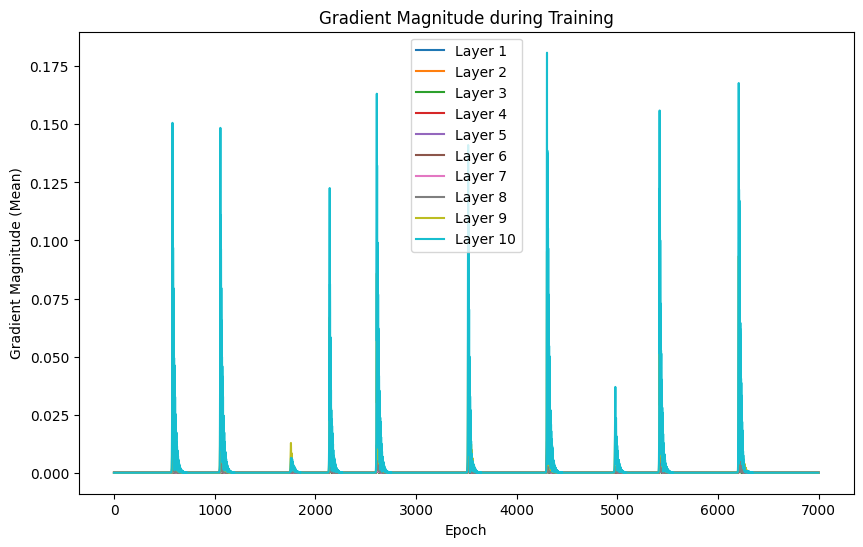

7000 Training Loss: tensor(2.6060e-06)
7001 Training Loss: tensor(2.6057e-06)
7002 Training Loss: tensor(2.6058e-06)
7003 Training Loss: tensor(2.6059e-06)
7004 Training Loss: tensor(2.6058e-06)
7005 Training Loss: tensor(2.6059e-06)
7006 Training Loss: tensor(2.6058e-06)
7007 Training Loss: tensor(2.6058e-06)
7008 Training Loss: tensor(2.6056e-06)
7009 Training Loss: tensor(2.6057e-06)
7010 Training Loss: tensor(2.6058e-06)
7011 Training Loss: tensor(2.6057e-06)
7012 Training Loss: tensor(2.6056e-06)
7013 Training Loss: tensor(2.6057e-06)
7014 Training Loss: tensor(2.6055e-06)
7015 Training Loss: tensor(2.6056e-06)
7016 Training Loss: tensor(2.6057e-06)
7017 Training Loss: tensor(2.6056e-06)
7018 Training Loss: tensor(2.6056e-06)
7019 Training Loss: tensor(2.6055e-06)
7020 Training Loss: tensor(2.6056e-06)
7021 Training Loss: tensor(2.6056e-06)
7022 Training Loss: tensor(2.6055e-06)
7023 Training Loss: tensor(2.6055e-06)
7024 Training Loss: tensor(2.6055e-06)
7025 Training Loss: tenso

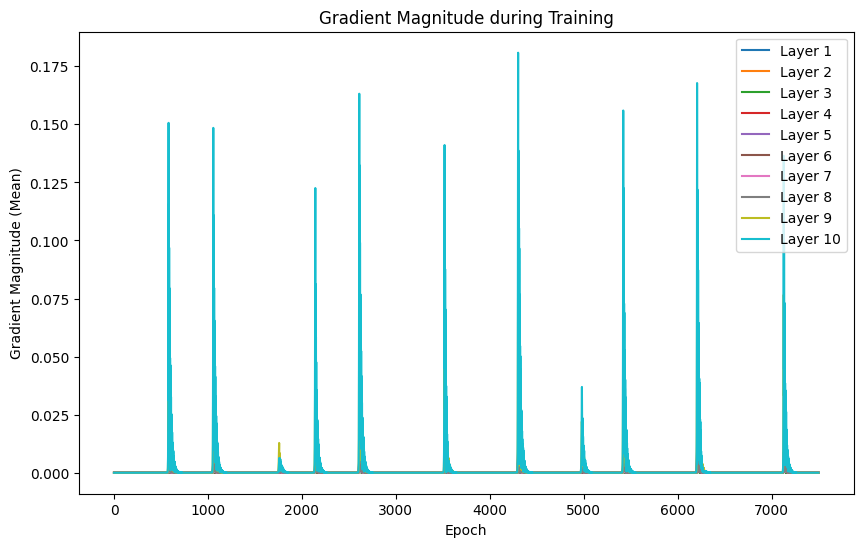

7500 Training Loss: tensor(2.6008e-06)
7501 Training Loss: tensor(2.6008e-06)
7502 Training Loss: tensor(2.6007e-06)
7503 Training Loss: tensor(2.6007e-06)
7504 Training Loss: tensor(2.6006e-06)
7505 Training Loss: tensor(2.6006e-06)
7506 Training Loss: tensor(2.6006e-06)
7507 Training Loss: tensor(2.6007e-06)
7508 Training Loss: tensor(2.6006e-06)
7509 Training Loss: tensor(2.6005e-06)
7510 Training Loss: tensor(2.6006e-06)
7511 Training Loss: tensor(2.6006e-06)
7512 Training Loss: tensor(2.6007e-06)
7513 Training Loss: tensor(2.6007e-06)
7514 Training Loss: tensor(2.6005e-06)
7515 Training Loss: tensor(2.6006e-06)
7516 Training Loss: tensor(2.6006e-06)
7517 Training Loss: tensor(2.6007e-06)
7518 Training Loss: tensor(2.6007e-06)
7519 Training Loss: tensor(2.6007e-06)
7520 Training Loss: tensor(2.6006e-06)
7521 Training Loss: tensor(2.6005e-06)
7522 Training Loss: tensor(2.6005e-06)
7523 Training Loss: tensor(2.6007e-06)
7524 Training Loss: tensor(2.6006e-06)
7525 Training Loss: tenso

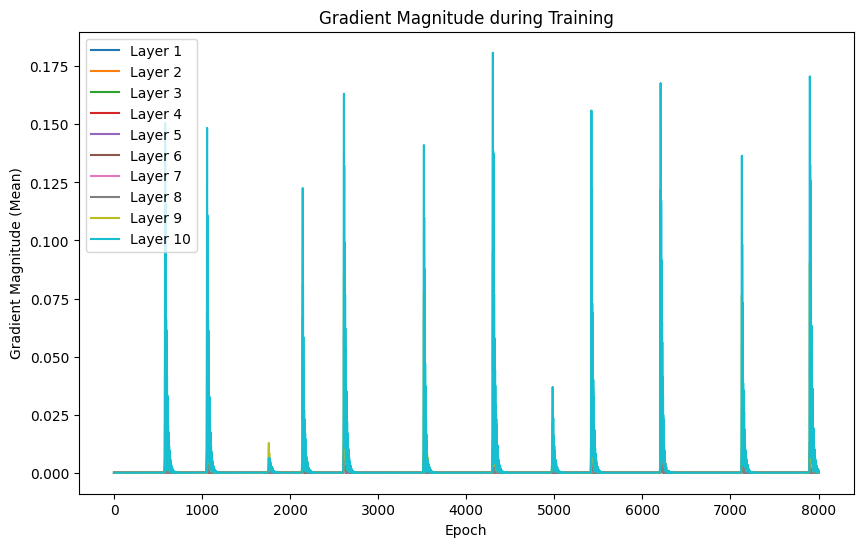

8000 Training Loss: tensor(2.6378e-06)
8001 Training Loss: tensor(2.6017e-06)
8002 Training Loss: tensor(2.6264e-06)
8003 Training Loss: tensor(2.6075e-06)
8004 Training Loss: tensor(2.6137e-06)
8005 Training Loss: tensor(2.6129e-06)
8006 Training Loss: tensor(2.6045e-06)
8007 Training Loss: tensor(2.6154e-06)
8008 Training Loss: tensor(2.5997e-06)
8009 Training Loss: tensor(2.6141e-06)
8010 Training Loss: tensor(2.5992e-06)
8011 Training Loss: tensor(2.6103e-06)
8012 Training Loss: tensor(2.6011e-06)
8013 Training Loss: tensor(2.6055e-06)
8014 Training Loss: tensor(2.6036e-06)
8015 Training Loss: tensor(2.6013e-06)
8016 Training Loss: tensor(2.6049e-06)
8017 Training Loss: tensor(2.5990e-06)
8018 Training Loss: tensor(2.6044e-06)
8019 Training Loss: tensor(2.5986e-06)
8020 Training Loss: tensor(2.6032e-06)
8021 Training Loss: tensor(2.5994e-06)
8022 Training Loss: tensor(2.6011e-06)
8023 Training Loss: tensor(2.6003e-06)
8024 Training Loss: tensor(2.5996e-06)
8025 Training Loss: tenso

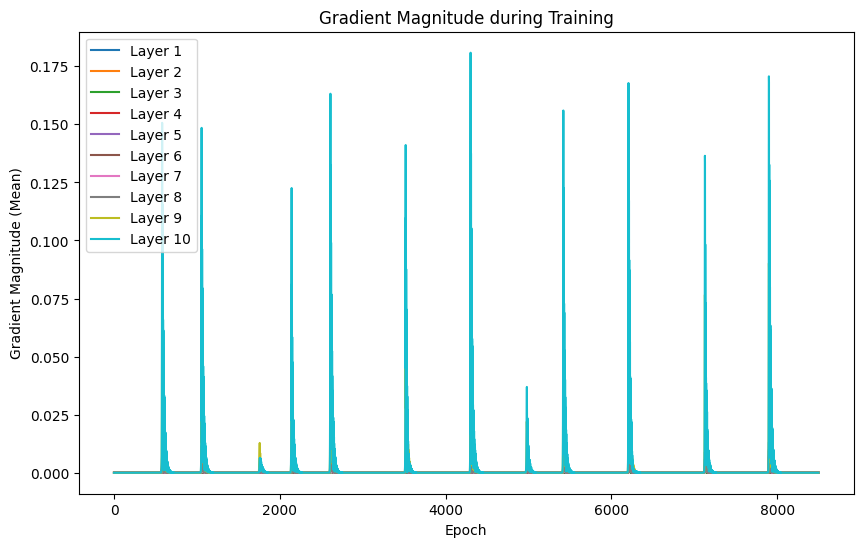

8500 Training Loss: tensor(2.5902e-06)
8501 Training Loss: tensor(2.5903e-06)
8502 Training Loss: tensor(2.5902e-06)
8503 Training Loss: tensor(2.5901e-06)
8504 Training Loss: tensor(2.5900e-06)
8505 Training Loss: tensor(2.5901e-06)
8506 Training Loss: tensor(2.5900e-06)
8507 Training Loss: tensor(2.5901e-06)
8508 Training Loss: tensor(2.5900e-06)
8509 Training Loss: tensor(2.5901e-06)
8510 Training Loss: tensor(2.5900e-06)
8511 Training Loss: tensor(2.5901e-06)
8512 Training Loss: tensor(2.5899e-06)
8513 Training Loss: tensor(2.5900e-06)
8514 Training Loss: tensor(2.5900e-06)
8515 Training Loss: tensor(2.5900e-06)
8516 Training Loss: tensor(2.5900e-06)
8517 Training Loss: tensor(2.5899e-06)
8518 Training Loss: tensor(2.5899e-06)
8519 Training Loss: tensor(2.5901e-06)
8520 Training Loss: tensor(2.5900e-06)
8521 Training Loss: tensor(2.5900e-06)
8522 Training Loss: tensor(2.5899e-06)
8523 Training Loss: tensor(2.5900e-06)
8524 Training Loss: tensor(2.5900e-06)
8525 Training Loss: tenso

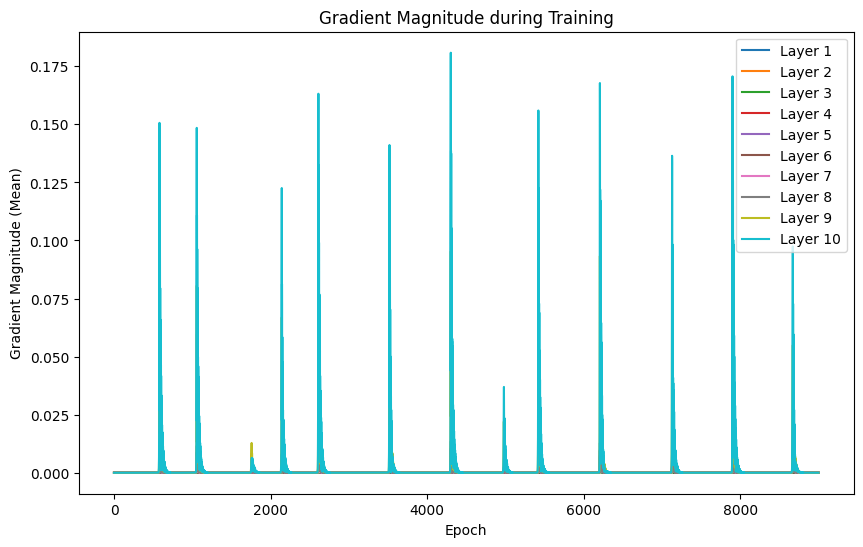

9000 Training Loss: tensor(2.5840e-06)
9001 Training Loss: tensor(2.5841e-06)
9002 Training Loss: tensor(2.5841e-06)
9003 Training Loss: tensor(2.5841e-06)
9004 Training Loss: tensor(2.5839e-06)
9005 Training Loss: tensor(2.5839e-06)
9006 Training Loss: tensor(2.5840e-06)
9007 Training Loss: tensor(2.5840e-06)
9008 Training Loss: tensor(2.5841e-06)
9009 Training Loss: tensor(2.5841e-06)
9010 Training Loss: tensor(2.5841e-06)
9011 Training Loss: tensor(2.5840e-06)
9012 Training Loss: tensor(2.5838e-06)
9013 Training Loss: tensor(2.5838e-06)
9014 Training Loss: tensor(2.5839e-06)
9015 Training Loss: tensor(2.5838e-06)
9016 Training Loss: tensor(2.5838e-06)
9017 Training Loss: tensor(2.5838e-06)
9018 Training Loss: tensor(2.5837e-06)
9019 Training Loss: tensor(2.5837e-06)
9020 Training Loss: tensor(2.5838e-06)
9021 Training Loss: tensor(2.5838e-06)
9022 Training Loss: tensor(2.5838e-06)
9023 Training Loss: tensor(2.5838e-06)
9024 Training Loss: tensor(2.5838e-06)
9025 Training Loss: tenso

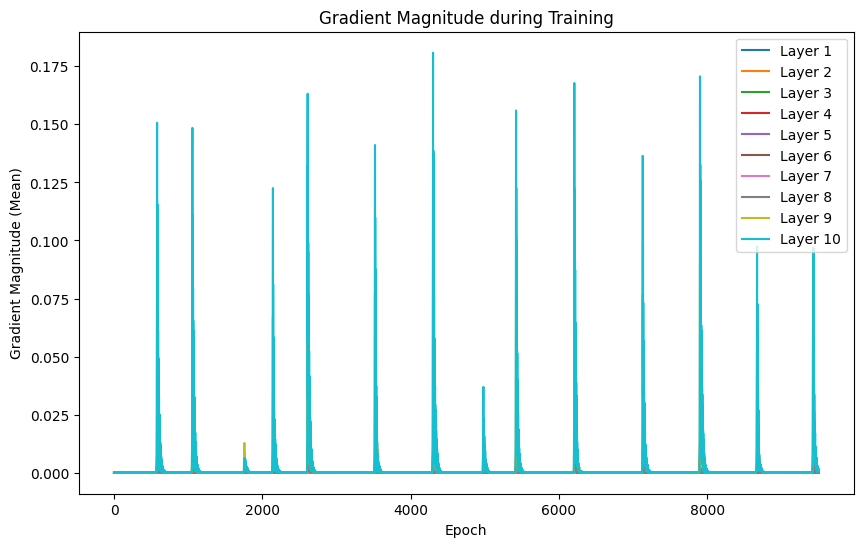

9500 Training Loss: tensor(2.6958e-06)
9501 Training Loss: tensor(2.6501e-06)
9502 Training Loss: tensor(2.7231e-06)
9503 Training Loss: tensor(2.6274e-06)
9504 Training Loss: tensor(2.6470e-06)
9505 Training Loss: tensor(2.6809e-06)
9506 Training Loss: tensor(2.5917e-06)
9507 Training Loss: tensor(2.6678e-06)
9508 Training Loss: tensor(2.6155e-06)
9509 Training Loss: tensor(2.6262e-06)
9510 Training Loss: tensor(2.6117e-06)
9511 Training Loss: tensor(2.6244e-06)
9512 Training Loss: tensor(2.5979e-06)
9513 Training Loss: tensor(2.6083e-06)
9514 Training Loss: tensor(2.6177e-06)
9515 Training Loss: tensor(2.5811e-06)
9516 Training Loss: tensor(2.6174e-06)
9517 Training Loss: tensor(2.5870e-06)
9518 Training Loss: tensor(2.5950e-06)
9519 Training Loss: tensor(2.5956e-06)
9520 Training Loss: tensor(2.5907e-06)
9521 Training Loss: tensor(2.5898e-06)
9522 Training Loss: tensor(2.5898e-06)
9523 Training Loss: tensor(2.5905e-06)
9524 Training Loss: tensor(2.5808e-06)
9525 Training Loss: tenso

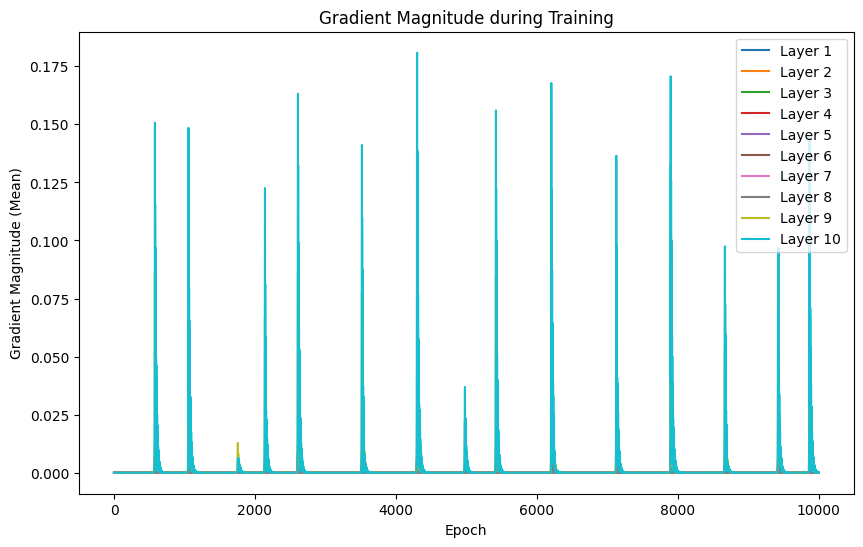

10000 Training Loss: tensor(2.5746e-06)
10001 Training Loss: tensor(2.5755e-06)
10002 Training Loss: tensor(2.5751e-06)
10003 Training Loss: tensor(2.5748e-06)
10004 Training Loss: tensor(2.5752e-06)
10005 Training Loss: tensor(2.5743e-06)
10006 Training Loss: tensor(2.5750e-06)
10007 Training Loss: tensor(2.5746e-06)
10008 Training Loss: tensor(2.5746e-06)
10009 Training Loss: tensor(2.5749e-06)
10010 Training Loss: tensor(2.5743e-06)
10011 Training Loss: tensor(2.5748e-06)
10012 Training Loss: tensor(2.5745e-06)
10013 Training Loss: tensor(2.5745e-06)
10014 Training Loss: tensor(2.5746e-06)
10015 Training Loss: tensor(2.5742e-06)
10016 Training Loss: tensor(2.5745e-06)
10017 Training Loss: tensor(2.5743e-06)
10018 Training Loss: tensor(2.5743e-06)
10019 Training Loss: tensor(2.5743e-06)
10020 Training Loss: tensor(2.5742e-06)
10021 Training Loss: tensor(2.5744e-06)
10022 Training Loss: tensor(2.5742e-06)
10023 Training Loss: tensor(2.5743e-06)
10024 Training Loss: tensor(2.5741e-06)


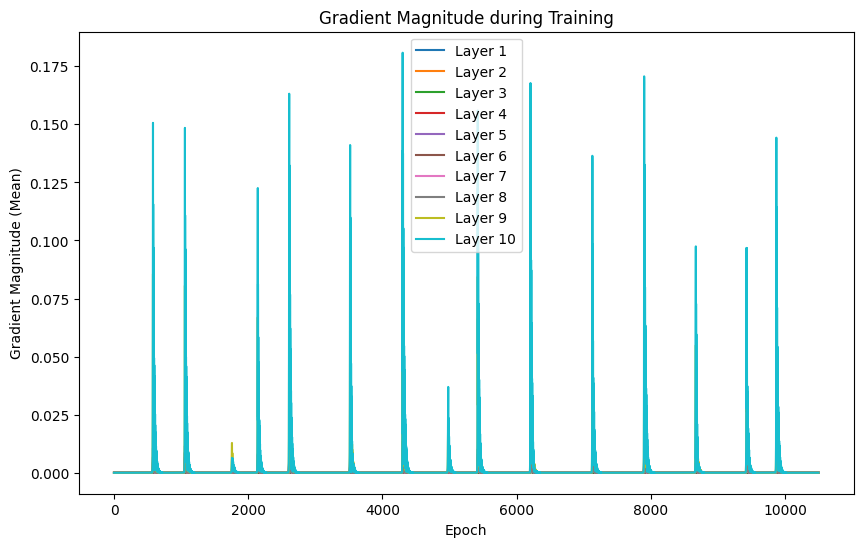

10500 Training Loss: tensor(2.5674e-06)
10501 Training Loss: tensor(2.5672e-06)
10502 Training Loss: tensor(2.5674e-06)
10503 Training Loss: tensor(2.5674e-06)
10504 Training Loss: tensor(2.5674e-06)
10505 Training Loss: tensor(2.5675e-06)
10506 Training Loss: tensor(2.5673e-06)
10507 Training Loss: tensor(2.5672e-06)
10508 Training Loss: tensor(2.5674e-06)
10509 Training Loss: tensor(2.5673e-06)
10510 Training Loss: tensor(2.5672e-06)
10511 Training Loss: tensor(2.5672e-06)
10512 Training Loss: tensor(2.5673e-06)
10513 Training Loss: tensor(2.5673e-06)
10514 Training Loss: tensor(2.5674e-06)
10515 Training Loss: tensor(2.5674e-06)
10516 Training Loss: tensor(2.5673e-06)
10517 Training Loss: tensor(2.5673e-06)
10518 Training Loss: tensor(2.5673e-06)
10519 Training Loss: tensor(2.5674e-06)
10520 Training Loss: tensor(2.5671e-06)
10521 Training Loss: tensor(2.5672e-06)
10522 Training Loss: tensor(2.5672e-06)
10523 Training Loss: tensor(2.5671e-06)
10524 Training Loss: tensor(2.5671e-06)


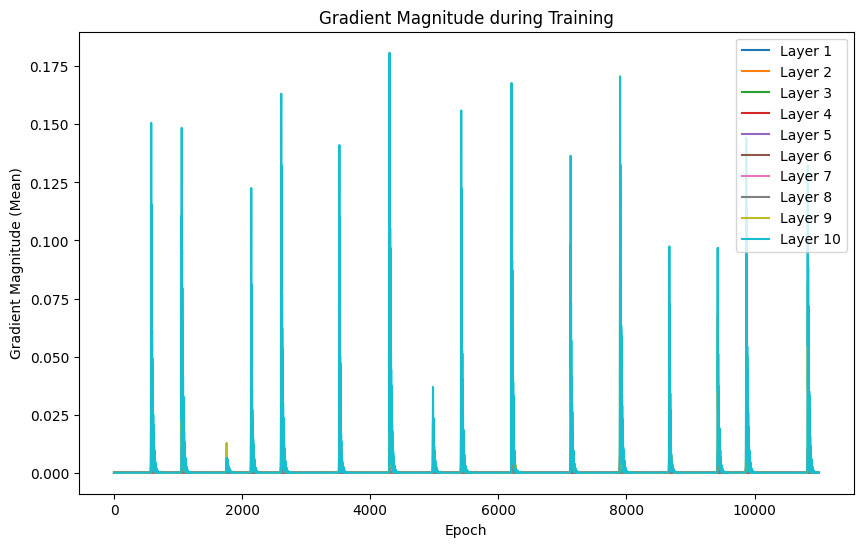

11000 Training Loss: tensor(2.5623e-06)
11001 Training Loss: tensor(2.5622e-06)
11002 Training Loss: tensor(2.5623e-06)
11003 Training Loss: tensor(2.5623e-06)
11004 Training Loss: tensor(2.5624e-06)
11005 Training Loss: tensor(2.5623e-06)
11006 Training Loss: tensor(2.5623e-06)
11007 Training Loss: tensor(2.5624e-06)
11008 Training Loss: tensor(2.5624e-06)
11009 Training Loss: tensor(2.5623e-06)
11010 Training Loss: tensor(2.5624e-06)
11011 Training Loss: tensor(2.5623e-06)
11012 Training Loss: tensor(2.5623e-06)
11013 Training Loss: tensor(2.5622e-06)
11014 Training Loss: tensor(2.5622e-06)
11015 Training Loss: tensor(2.5622e-06)
11016 Training Loss: tensor(2.5621e-06)
11017 Training Loss: tensor(2.5622e-06)
11018 Training Loss: tensor(2.5621e-06)
11019 Training Loss: tensor(2.5622e-06)
11020 Training Loss: tensor(2.5621e-06)
11021 Training Loss: tensor(2.5623e-06)
11022 Training Loss: tensor(2.5623e-06)
11023 Training Loss: tensor(2.5621e-06)
11024 Training Loss: tensor(2.5620e-06)


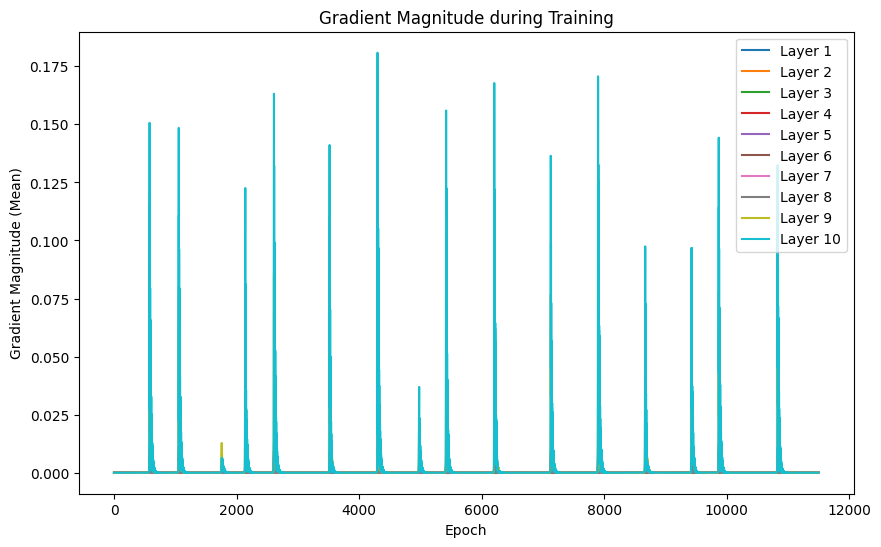

11500 Training Loss: tensor(2.5555e-06)
11501 Training Loss: tensor(2.5555e-06)
11502 Training Loss: tensor(2.5555e-06)
11503 Training Loss: tensor(2.5554e-06)
11504 Training Loss: tensor(2.5554e-06)
11505 Training Loss: tensor(2.5555e-06)
11506 Training Loss: tensor(2.5555e-06)
11507 Training Loss: tensor(2.5554e-06)
11508 Training Loss: tensor(2.5553e-06)
11509 Training Loss: tensor(2.5552e-06)
11510 Training Loss: tensor(2.5551e-06)
11511 Training Loss: tensor(2.5552e-06)
11512 Training Loss: tensor(2.5552e-06)
11513 Training Loss: tensor(2.5552e-06)
11514 Training Loss: tensor(2.5553e-06)
11515 Training Loss: tensor(2.5553e-06)
11516 Training Loss: tensor(2.5552e-06)
11517 Training Loss: tensor(2.5552e-06)
11518 Training Loss: tensor(2.5552e-06)
11519 Training Loss: tensor(2.5552e-06)
11520 Training Loss: tensor(2.5553e-06)
11521 Training Loss: tensor(2.5551e-06)
11522 Training Loss: tensor(2.5551e-06)
11523 Training Loss: tensor(2.5551e-06)
11524 Training Loss: tensor(2.5552e-06)


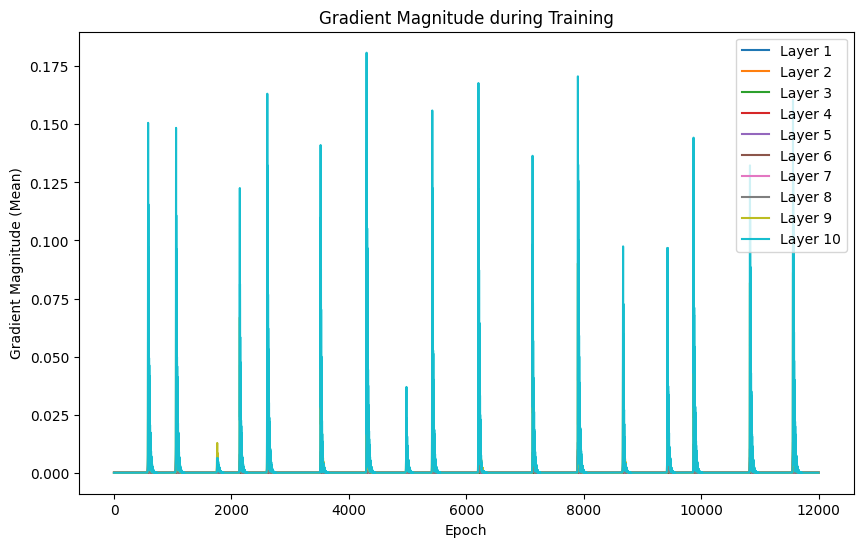

12000 Training Loss: tensor(2.5518e-06)
12001 Training Loss: tensor(2.5519e-06)
12002 Training Loss: tensor(2.5519e-06)
12003 Training Loss: tensor(2.5519e-06)
12004 Training Loss: tensor(2.5520e-06)
12005 Training Loss: tensor(2.5519e-06)
12006 Training Loss: tensor(2.5518e-06)
12007 Training Loss: tensor(2.5518e-06)
12008 Training Loss: tensor(2.5516e-06)
12009 Training Loss: tensor(2.5517e-06)
12010 Training Loss: tensor(2.5516e-06)
12011 Training Loss: tensor(2.5516e-06)
12012 Training Loss: tensor(2.5517e-06)
12013 Training Loss: tensor(2.5516e-06)
12014 Training Loss: tensor(2.5516e-06)
12015 Training Loss: tensor(2.5516e-06)
12016 Training Loss: tensor(2.5516e-06)
12017 Training Loss: tensor(2.5516e-06)
12018 Training Loss: tensor(2.5517e-06)
12019 Training Loss: tensor(2.5516e-06)
12020 Training Loss: tensor(2.5516e-06)
12021 Training Loss: tensor(2.5517e-06)
12022 Training Loss: tensor(2.5516e-06)
12023 Training Loss: tensor(2.5517e-06)
12024 Training Loss: tensor(2.5516e-06)


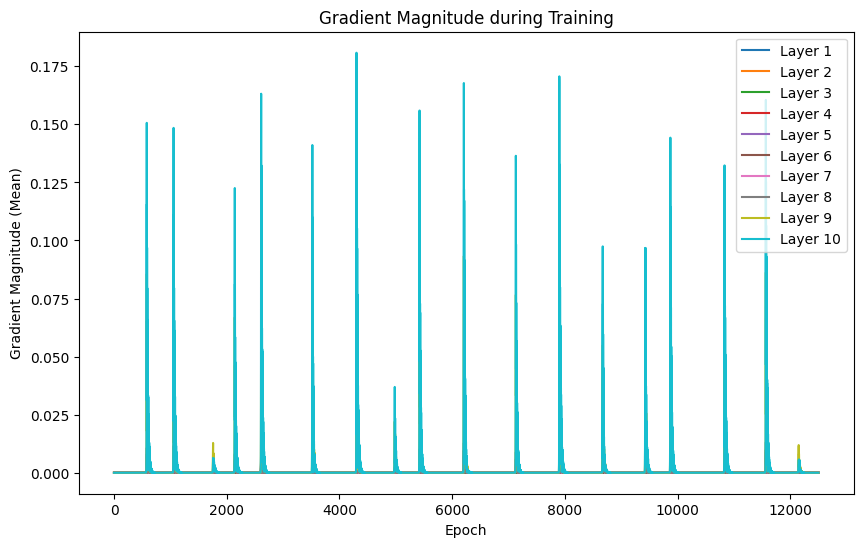

12500 Training Loss: tensor(2.5449e-06)
12501 Training Loss: tensor(2.5448e-06)
12502 Training Loss: tensor(2.5450e-06)
12503 Training Loss: tensor(2.5449e-06)
12504 Training Loss: tensor(2.5447e-06)
12505 Training Loss: tensor(2.5448e-06)
12506 Training Loss: tensor(2.5447e-06)
12507 Training Loss: tensor(2.5447e-06)
12508 Training Loss: tensor(2.5446e-06)
12509 Training Loss: tensor(2.5446e-06)
12510 Training Loss: tensor(2.5447e-06)
12511 Training Loss: tensor(2.5447e-06)
12512 Training Loss: tensor(2.5446e-06)
12513 Training Loss: tensor(2.5446e-06)
12514 Training Loss: tensor(2.5446e-06)
12515 Training Loss: tensor(2.5445e-06)
12516 Training Loss: tensor(2.5446e-06)
12517 Training Loss: tensor(2.5445e-06)
12518 Training Loss: tensor(2.5443e-06)
12519 Training Loss: tensor(2.5445e-06)
12520 Training Loss: tensor(2.5444e-06)
12521 Training Loss: tensor(2.5444e-06)
12522 Training Loss: tensor(2.5446e-06)
12523 Training Loss: tensor(2.5445e-06)
12524 Training Loss: tensor(2.5445e-06)


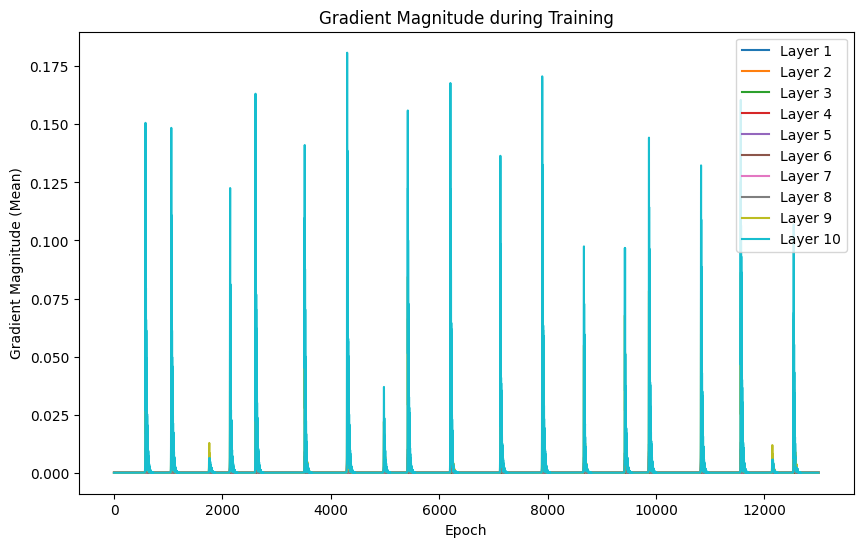

13000 Training Loss: tensor(2.5397e-06)
13001 Training Loss: tensor(2.5397e-06)
13002 Training Loss: tensor(2.5396e-06)
13003 Training Loss: tensor(2.5396e-06)
13004 Training Loss: tensor(2.5396e-06)
13005 Training Loss: tensor(2.5396e-06)
13006 Training Loss: tensor(2.5394e-06)
13007 Training Loss: tensor(2.5394e-06)
13008 Training Loss: tensor(2.5396e-06)
13009 Training Loss: tensor(2.5395e-06)
13010 Training Loss: tensor(2.5395e-06)
13011 Training Loss: tensor(2.5395e-06)
13012 Training Loss: tensor(2.5394e-06)
13013 Training Loss: tensor(2.5393e-06)
13014 Training Loss: tensor(2.5394e-06)
13015 Training Loss: tensor(2.5395e-06)
13016 Training Loss: tensor(2.5394e-06)
13017 Training Loss: tensor(2.5395e-06)
13018 Training Loss: tensor(2.5395e-06)
13019 Training Loss: tensor(2.5393e-06)
13020 Training Loss: tensor(2.5395e-06)
13021 Training Loss: tensor(2.5395e-06)
13022 Training Loss: tensor(2.5393e-06)
13023 Training Loss: tensor(2.5393e-06)
13024 Training Loss: tensor(2.5393e-06)


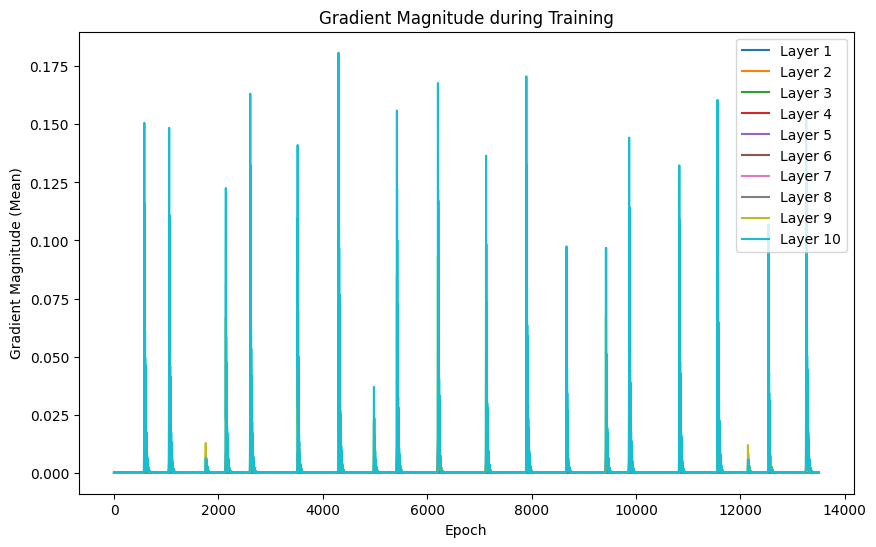

13500 Training Loss: tensor(2.5364e-06)
13501 Training Loss: tensor(2.5362e-06)
13502 Training Loss: tensor(2.5363e-06)
13503 Training Loss: tensor(2.5364e-06)
13504 Training Loss: tensor(2.5363e-06)
13505 Training Loss: tensor(2.5362e-06)
13506 Training Loss: tensor(2.5363e-06)
13507 Training Loss: tensor(2.5362e-06)
13508 Training Loss: tensor(2.5361e-06)
13509 Training Loss: tensor(2.5361e-06)
13510 Training Loss: tensor(2.5361e-06)
13511 Training Loss: tensor(2.5361e-06)
13512 Training Loss: tensor(2.5361e-06)
13513 Training Loss: tensor(2.5361e-06)
13514 Training Loss: tensor(2.5361e-06)
13515 Training Loss: tensor(2.5360e-06)
13516 Training Loss: tensor(2.5358e-06)
13517 Training Loss: tensor(2.5359e-06)
13518 Training Loss: tensor(2.5360e-06)
13519 Training Loss: tensor(2.5359e-06)
13520 Training Loss: tensor(2.5359e-06)
13521 Training Loss: tensor(2.5358e-06)
13522 Training Loss: tensor(2.5359e-06)
13523 Training Loss: tensor(2.5360e-06)
13524 Training Loss: tensor(2.5360e-06)


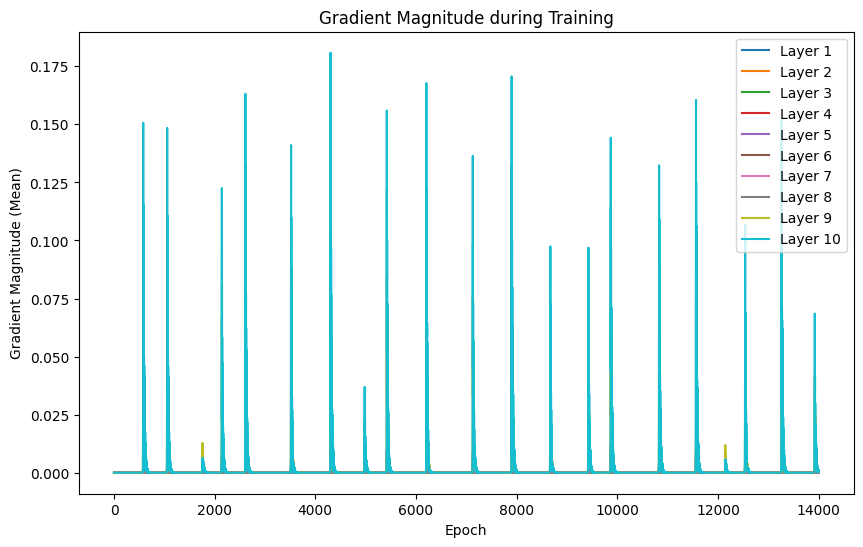

14000 Training Loss: tensor(2.6152e-06)
14001 Training Loss: tensor(2.5509e-06)
14002 Training Loss: tensor(2.5527e-06)
14003 Training Loss: tensor(2.5766e-06)
14004 Training Loss: tensor(2.5578e-06)
14005 Training Loss: tensor(2.5600e-06)
14006 Training Loss: tensor(2.5430e-06)
14007 Training Loss: tensor(2.5518e-06)
14008 Training Loss: tensor(2.5643e-06)
14009 Training Loss: tensor(2.5350e-06)
14010 Training Loss: tensor(2.5417e-06)
14011 Training Loss: tensor(2.5530e-06)
14012 Training Loss: tensor(2.5402e-06)
14013 Training Loss: tensor(2.5400e-06)
14014 Training Loss: tensor(2.5374e-06)
14015 Training Loss: tensor(2.5406e-06)
14016 Training Loss: tensor(2.5425e-06)
14017 Training Loss: tensor(2.5313e-06)
14018 Training Loss: tensor(2.5364e-06)
14019 Training Loss: tensor(2.5401e-06)
14020 Training Loss: tensor(2.5331e-06)
14021 Training Loss: tensor(2.5340e-06)
14022 Training Loss: tensor(2.5339e-06)
14023 Training Loss: tensor(2.5342e-06)
14024 Training Loss: tensor(2.5349e-06)


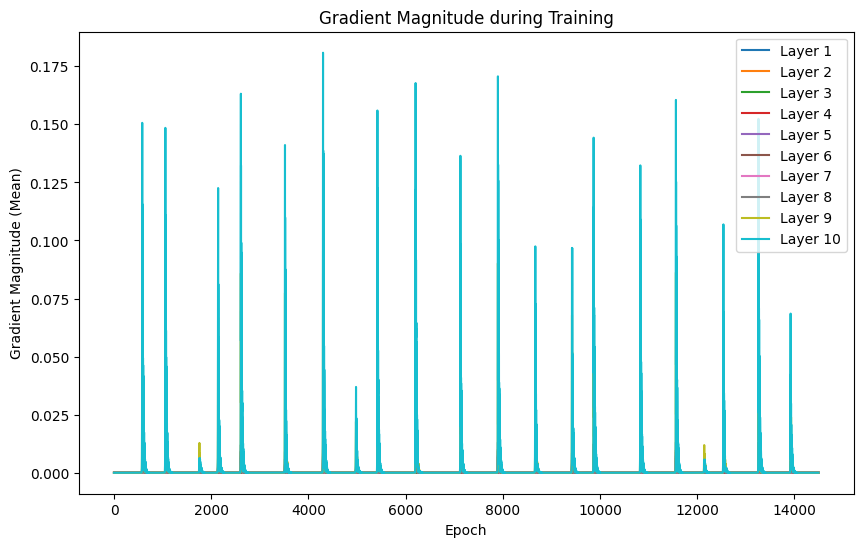

14500 Training Loss: tensor(2.5233e-06)
14501 Training Loss: tensor(2.5232e-06)
14502 Training Loss: tensor(2.5232e-06)
14503 Training Loss: tensor(2.5233e-06)
14504 Training Loss: tensor(2.5234e-06)
14505 Training Loss: tensor(2.5234e-06)
14506 Training Loss: tensor(2.5233e-06)
14507 Training Loss: tensor(2.5233e-06)
14508 Training Loss: tensor(2.5233e-06)
14509 Training Loss: tensor(2.5232e-06)
14510 Training Loss: tensor(2.5232e-06)
14511 Training Loss: tensor(2.5231e-06)
14512 Training Loss: tensor(2.5230e-06)
14513 Training Loss: tensor(2.5231e-06)
14514 Training Loss: tensor(2.5230e-06)
14515 Training Loss: tensor(2.5231e-06)
14516 Training Loss: tensor(2.5231e-06)
14517 Training Loss: tensor(2.5230e-06)
14518 Training Loss: tensor(2.5230e-06)
14519 Training Loss: tensor(2.5230e-06)
14520 Training Loss: tensor(2.5229e-06)
14521 Training Loss: tensor(2.5229e-06)
14522 Training Loss: tensor(2.5230e-06)
14523 Training Loss: tensor(2.5230e-06)
14524 Training Loss: tensor(2.5231e-06)


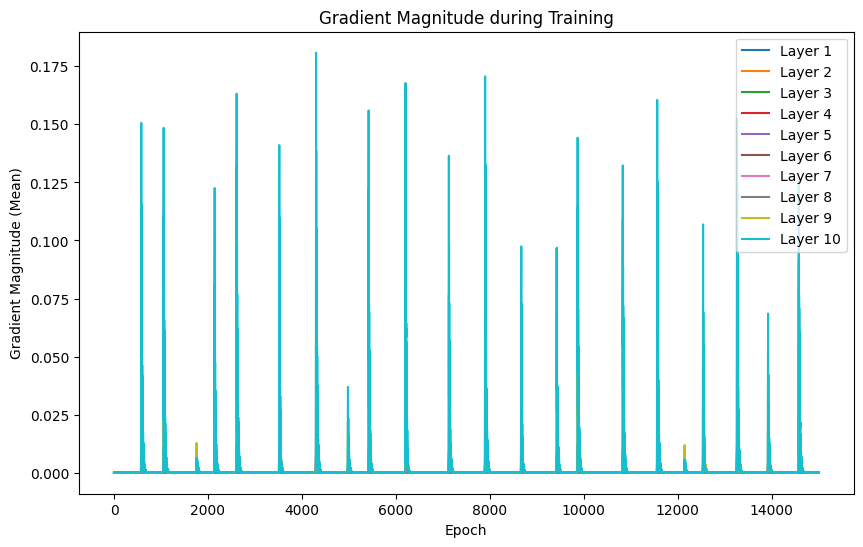

15000 Training Loss: tensor(2.5187e-06)
15001 Training Loss: tensor(2.5185e-06)
15002 Training Loss: tensor(2.5185e-06)
15003 Training Loss: tensor(2.5185e-06)
15004 Training Loss: tensor(2.5183e-06)
15005 Training Loss: tensor(2.5183e-06)
15006 Training Loss: tensor(2.5184e-06)
15007 Training Loss: tensor(2.5184e-06)
15008 Training Loss: tensor(2.5184e-06)
15009 Training Loss: tensor(2.5184e-06)
15010 Training Loss: tensor(2.5183e-06)
15011 Training Loss: tensor(2.5183e-06)
15012 Training Loss: tensor(2.5183e-06)
15013 Training Loss: tensor(2.5183e-06)
15014 Training Loss: tensor(2.5182e-06)
15015 Training Loss: tensor(2.5183e-06)
15016 Training Loss: tensor(2.5182e-06)
15017 Training Loss: tensor(2.5181e-06)
15018 Training Loss: tensor(2.5182e-06)
15019 Training Loss: tensor(2.5181e-06)
15020 Training Loss: tensor(2.5183e-06)
15021 Training Loss: tensor(2.5182e-06)
15022 Training Loss: tensor(2.5182e-06)
15023 Training Loss: tensor(2.5182e-06)
15024 Training Loss: tensor(2.5182e-06)


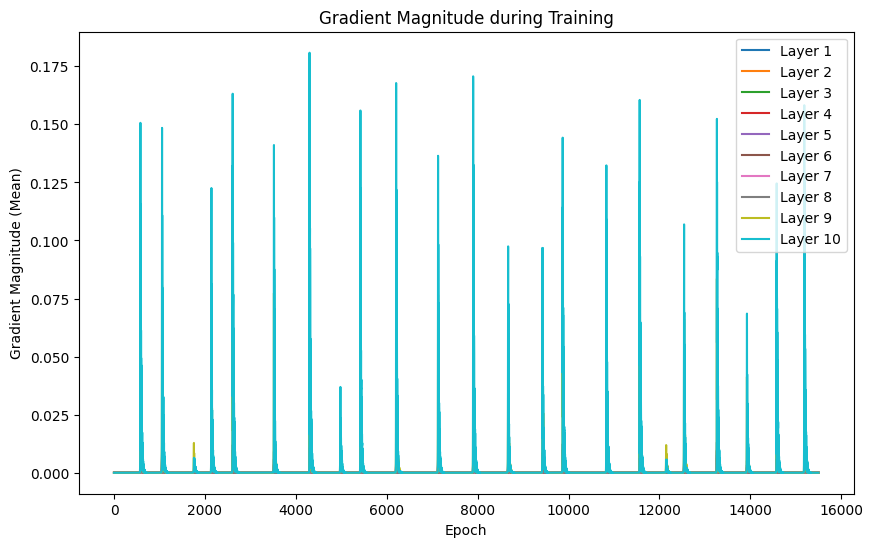

15500 Training Loss: tensor(2.5152e-06)
15501 Training Loss: tensor(2.5153e-06)
15502 Training Loss: tensor(2.5153e-06)
15503 Training Loss: tensor(2.5152e-06)
15504 Training Loss: tensor(2.5152e-06)
15505 Training Loss: tensor(2.5151e-06)
15506 Training Loss: tensor(2.5153e-06)
15507 Training Loss: tensor(2.5152e-06)
15508 Training Loss: tensor(2.5151e-06)
15509 Training Loss: tensor(2.5151e-06)
15510 Training Loss: tensor(2.5151e-06)
15511 Training Loss: tensor(2.5151e-06)
15512 Training Loss: tensor(2.5151e-06)
15513 Training Loss: tensor(2.5152e-06)
15514 Training Loss: tensor(2.5151e-06)
15515 Training Loss: tensor(2.5152e-06)
15516 Training Loss: tensor(2.5152e-06)
15517 Training Loss: tensor(2.5151e-06)
15518 Training Loss: tensor(2.5150e-06)
15519 Training Loss: tensor(2.5150e-06)
15520 Training Loss: tensor(2.5150e-06)
15521 Training Loss: tensor(2.5150e-06)
15522 Training Loss: tensor(2.5150e-06)
15523 Training Loss: tensor(2.5151e-06)
15524 Training Loss: tensor(2.5151e-06)


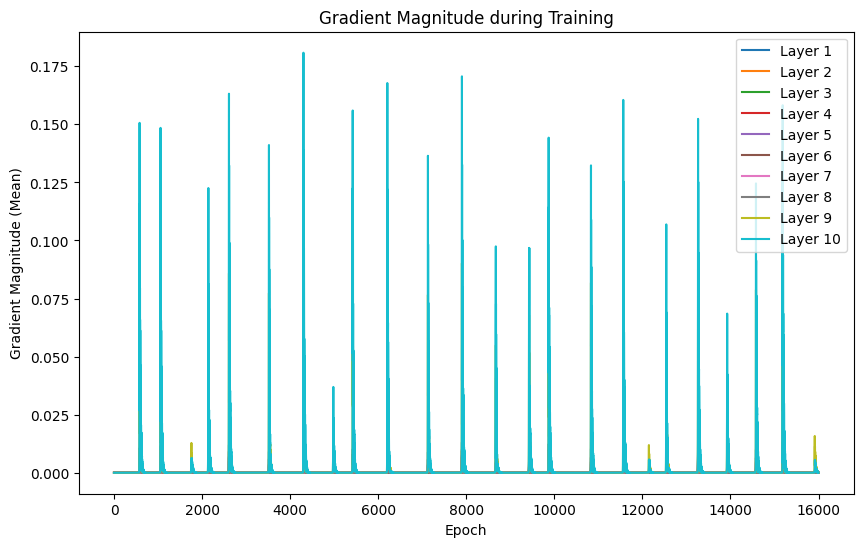

16000 Training Loss: tensor(2.5108e-06)
16001 Training Loss: tensor(2.5093e-06)
16002 Training Loss: tensor(2.5113e-06)
16003 Training Loss: tensor(2.5117e-06)
16004 Training Loss: tensor(2.5097e-06)
16005 Training Loss: tensor(2.5090e-06)
16006 Training Loss: tensor(2.5104e-06)
16007 Training Loss: tensor(2.5108e-06)
16008 Training Loss: tensor(2.5095e-06)
16009 Training Loss: tensor(2.5089e-06)
16010 Training Loss: tensor(2.5097e-06)
16011 Training Loss: tensor(2.5100e-06)
16012 Training Loss: tensor(2.5090e-06)
16013 Training Loss: tensor(2.5088e-06)
16014 Training Loss: tensor(2.5094e-06)
16015 Training Loss: tensor(2.5093e-06)
16016 Training Loss: tensor(2.5088e-06)
16017 Training Loss: tensor(2.5085e-06)
16018 Training Loss: tensor(2.5089e-06)
16019 Training Loss: tensor(2.5090e-06)
16020 Training Loss: tensor(2.5087e-06)
16021 Training Loss: tensor(2.5085e-06)
16022 Training Loss: tensor(2.5087e-06)
16023 Training Loss: tensor(2.5088e-06)
16024 Training Loss: tensor(2.5085e-06)


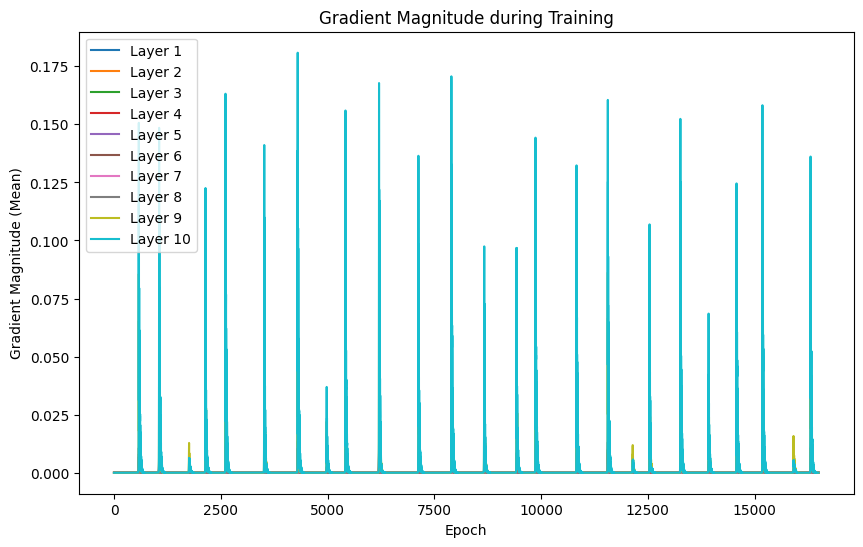

16500 Training Loss: tensor(2.5040e-06)
16501 Training Loss: tensor(2.5041e-06)
16502 Training Loss: tensor(2.5040e-06)
16503 Training Loss: tensor(2.5041e-06)
16504 Training Loss: tensor(2.5040e-06)
16505 Training Loss: tensor(2.5038e-06)
16506 Training Loss: tensor(2.5040e-06)
16507 Training Loss: tensor(2.5040e-06)
16508 Training Loss: tensor(2.5039e-06)
16509 Training Loss: tensor(2.5039e-06)
16510 Training Loss: tensor(2.5039e-06)
16511 Training Loss: tensor(2.5040e-06)
16512 Training Loss: tensor(2.5039e-06)
16513 Training Loss: tensor(2.5040e-06)
16514 Training Loss: tensor(2.5039e-06)
16515 Training Loss: tensor(2.5039e-06)
16516 Training Loss: tensor(2.5039e-06)
16517 Training Loss: tensor(2.5039e-06)
16518 Training Loss: tensor(2.5038e-06)
16519 Training Loss: tensor(2.5038e-06)
16520 Training Loss: tensor(2.5038e-06)
16521 Training Loss: tensor(2.5038e-06)
16522 Training Loss: tensor(2.5039e-06)
16523 Training Loss: tensor(2.5038e-06)
16524 Training Loss: tensor(2.5038e-06)


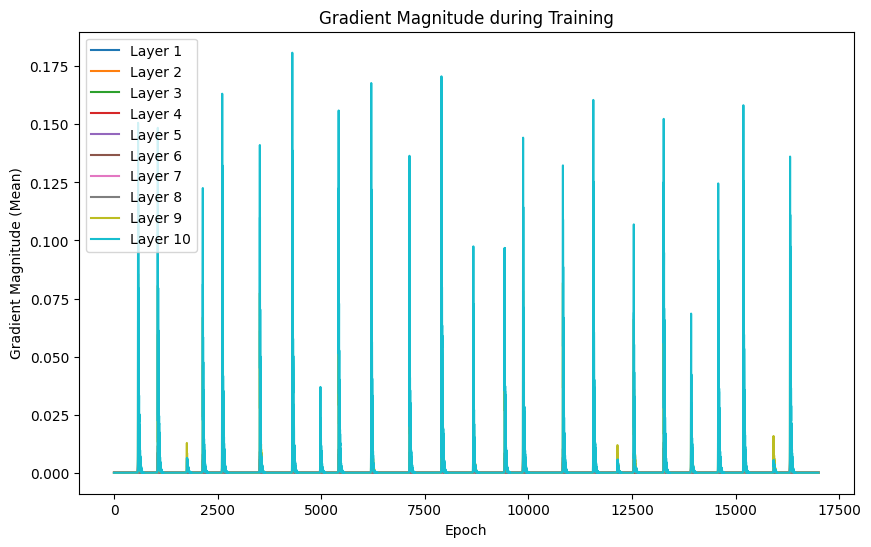

17000 Training Loss: tensor(2.4974e-06)
17001 Training Loss: tensor(2.4974e-06)
17002 Training Loss: tensor(2.4975e-06)
17003 Training Loss: tensor(2.4974e-06)
17004 Training Loss: tensor(2.4974e-06)
17005 Training Loss: tensor(2.4974e-06)
17006 Training Loss: tensor(2.4975e-06)
17007 Training Loss: tensor(2.4974e-06)
17008 Training Loss: tensor(2.4973e-06)
17009 Training Loss: tensor(2.4973e-06)
17010 Training Loss: tensor(2.4974e-06)
17011 Training Loss: tensor(2.4974e-06)
17012 Training Loss: tensor(2.4972e-06)
17013 Training Loss: tensor(2.4973e-06)
17014 Training Loss: tensor(2.4974e-06)
17015 Training Loss: tensor(2.4972e-06)
17016 Training Loss: tensor(2.4971e-06)
17017 Training Loss: tensor(2.4971e-06)
17018 Training Loss: tensor(2.4972e-06)
17019 Training Loss: tensor(2.4972e-06)
17020 Training Loss: tensor(2.4973e-06)
17021 Training Loss: tensor(2.4973e-06)
17022 Training Loss: tensor(2.4973e-06)
17023 Training Loss: tensor(2.4975e-06)
17024 Training Loss: tensor(2.4979e-06)


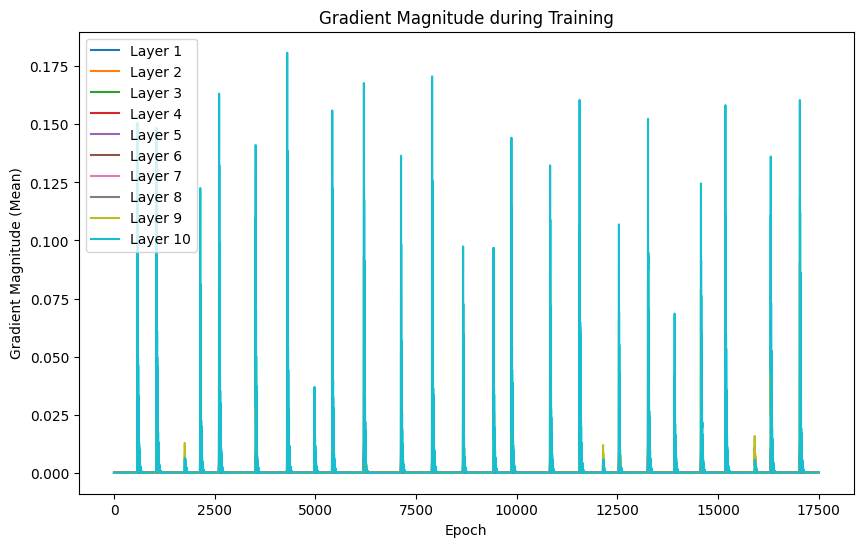

17500 Training Loss: tensor(2.4943e-06)
17501 Training Loss: tensor(2.4943e-06)
17502 Training Loss: tensor(2.4943e-06)
17503 Training Loss: tensor(2.4943e-06)
17504 Training Loss: tensor(2.4943e-06)
17505 Training Loss: tensor(2.4943e-06)
17506 Training Loss: tensor(2.4942e-06)
17507 Training Loss: tensor(2.4942e-06)
17508 Training Loss: tensor(2.4942e-06)
17509 Training Loss: tensor(2.4943e-06)
17510 Training Loss: tensor(2.4941e-06)
17511 Training Loss: tensor(2.4941e-06)
17512 Training Loss: tensor(2.4941e-06)
17513 Training Loss: tensor(2.4942e-06)
17514 Training Loss: tensor(2.4942e-06)
17515 Training Loss: tensor(2.4940e-06)
17516 Training Loss: tensor(2.4941e-06)
17517 Training Loss: tensor(2.4940e-06)
17518 Training Loss: tensor(2.4941e-06)
17519 Training Loss: tensor(2.4941e-06)
17520 Training Loss: tensor(2.4941e-06)
17521 Training Loss: tensor(2.4940e-06)
17522 Training Loss: tensor(2.4941e-06)
17523 Training Loss: tensor(2.4941e-06)
17524 Training Loss: tensor(2.4941e-06)


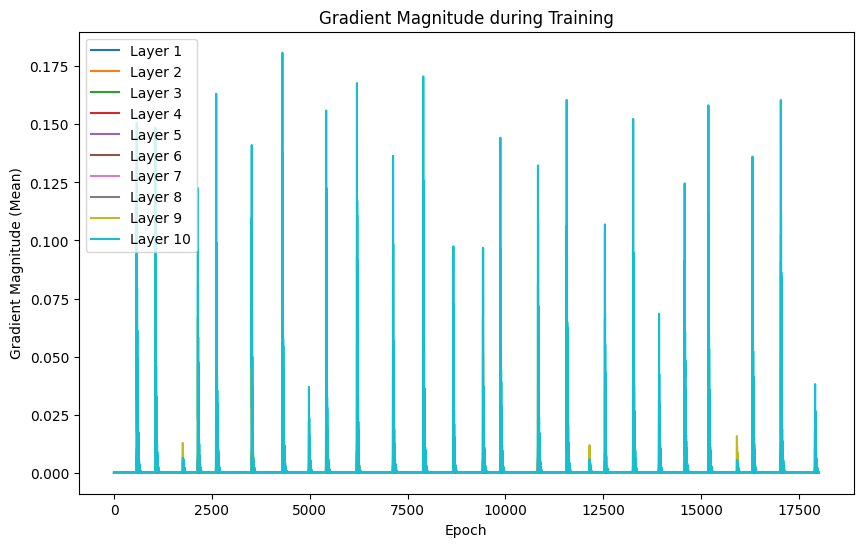

18000 Training Loss: tensor(2.4959e-06)
18001 Training Loss: tensor(2.4930e-06)
18002 Training Loss: tensor(2.4890e-06)
18003 Training Loss: tensor(2.4898e-06)
18004 Training Loss: tensor(2.4918e-06)
18005 Training Loss: tensor(2.4917e-06)
18006 Training Loss: tensor(2.4918e-06)
18007 Training Loss: tensor(2.4921e-06)
18008 Training Loss: tensor(2.4907e-06)
18009 Training Loss: tensor(2.4887e-06)
18010 Training Loss: tensor(2.4887e-06)
18011 Training Loss: tensor(2.4896e-06)
18012 Training Loss: tensor(2.4899e-06)
18013 Training Loss: tensor(2.4899e-06)
18014 Training Loss: tensor(2.4900e-06)
18015 Training Loss: tensor(2.4895e-06)
18016 Training Loss: tensor(2.4885e-06)
18017 Training Loss: tensor(2.4883e-06)
18018 Training Loss: tensor(2.4885e-06)
18019 Training Loss: tensor(2.4887e-06)
18020 Training Loss: tensor(2.4889e-06)
18021 Training Loss: tensor(2.4889e-06)
18022 Training Loss: tensor(2.4887e-06)
18023 Training Loss: tensor(2.4882e-06)
18024 Training Loss: tensor(2.4880e-06)


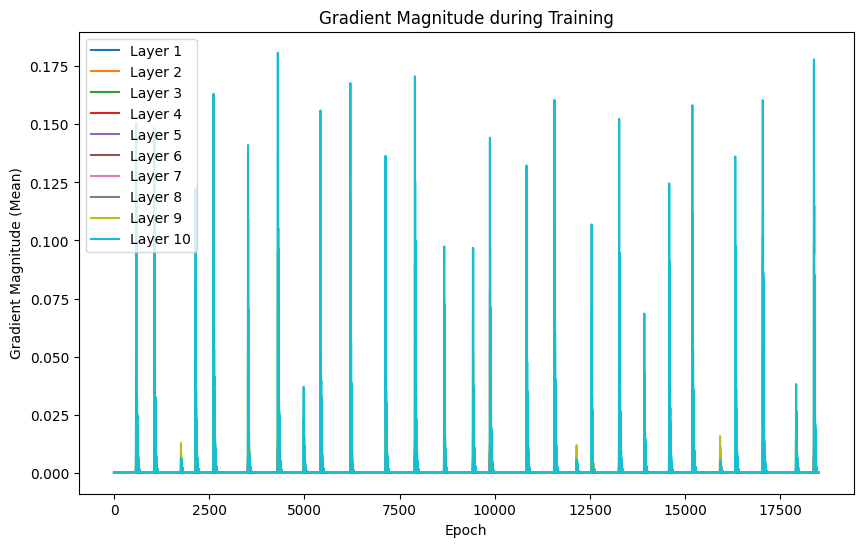

18500 Training Loss: tensor(2.4863e-06)
18501 Training Loss: tensor(2.4851e-06)
18502 Training Loss: tensor(2.4859e-06)
18503 Training Loss: tensor(2.4848e-06)
18504 Training Loss: tensor(2.4856e-06)
18505 Training Loss: tensor(2.4849e-06)
18506 Training Loss: tensor(2.4848e-06)
18507 Training Loss: tensor(2.4851e-06)
18508 Training Loss: tensor(2.4845e-06)
18509 Training Loss: tensor(2.4850e-06)
18510 Training Loss: tensor(2.4843e-06)
18511 Training Loss: tensor(2.4847e-06)
18512 Training Loss: tensor(2.4843e-06)
18513 Training Loss: tensor(2.4843e-06)
18514 Training Loss: tensor(2.4845e-06)
18515 Training Loss: tensor(2.4842e-06)
18516 Training Loss: tensor(2.4843e-06)
18517 Training Loss: tensor(2.4841e-06)
18518 Training Loss: tensor(2.4844e-06)
18519 Training Loss: tensor(2.4841e-06)
18520 Training Loss: tensor(2.4842e-06)
18521 Training Loss: tensor(2.4842e-06)
18522 Training Loss: tensor(2.4841e-06)
18523 Training Loss: tensor(2.4843e-06)
18524 Training Loss: tensor(2.4839e-06)


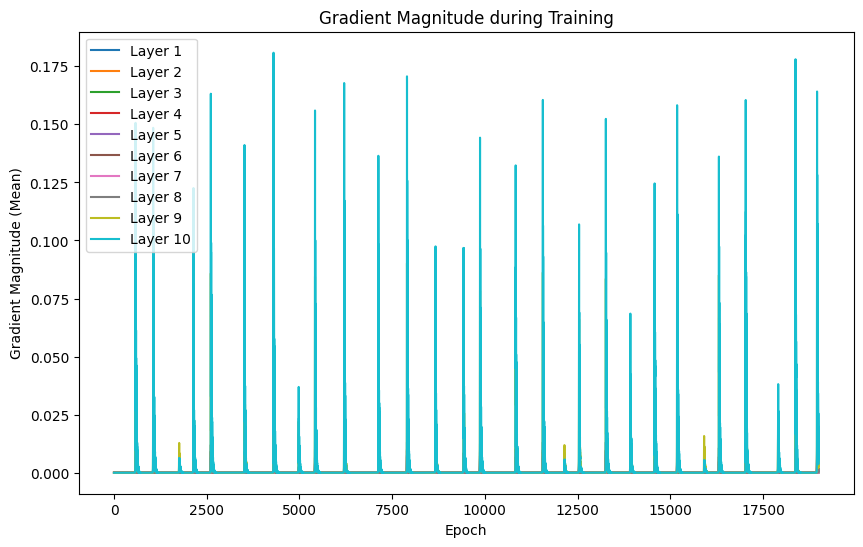

19000 Training Loss: tensor(3.9475e-06)
19001 Training Loss: tensor(1.4909e-05)
19002 Training Loss: tensor(2.5858e-06)
19003 Training Loss: tensor(1.2057e-05)
19004 Training Loss: tensor(4.3492e-06)
19005 Training Loss: tensor(7.6965e-06)
19006 Training Loss: tensor(6.7678e-06)
19007 Training Loss: tensor(4.1650e-06)
19008 Training Loss: tensor(7.9421e-06)
19009 Training Loss: tensor(2.5909e-06)
19010 Training Loss: tensor(7.3957e-06)
19011 Training Loss: tensor(2.8105e-06)
19012 Training Loss: tensor(5.6564e-06)
19013 Training Loss: tensor(3.8882e-06)
19014 Training Loss: tensor(3.8220e-06)
19015 Training Loss: tensor(4.7361e-06)
19016 Training Loss: tensor(2.7162e-06)
19017 Training Loss: tensor(4.8221e-06)
19018 Training Loss: tensor(2.5098e-06)
19019 Training Loss: tensor(4.2225e-06)
19020 Training Loss: tensor(2.9029e-06)
19021 Training Loss: tensor(3.3624e-06)
19022 Training Loss: tensor(3.3723e-06)
19023 Training Loss: tensor(2.7194e-06)
19024 Training Loss: tensor(3.5493e-06)


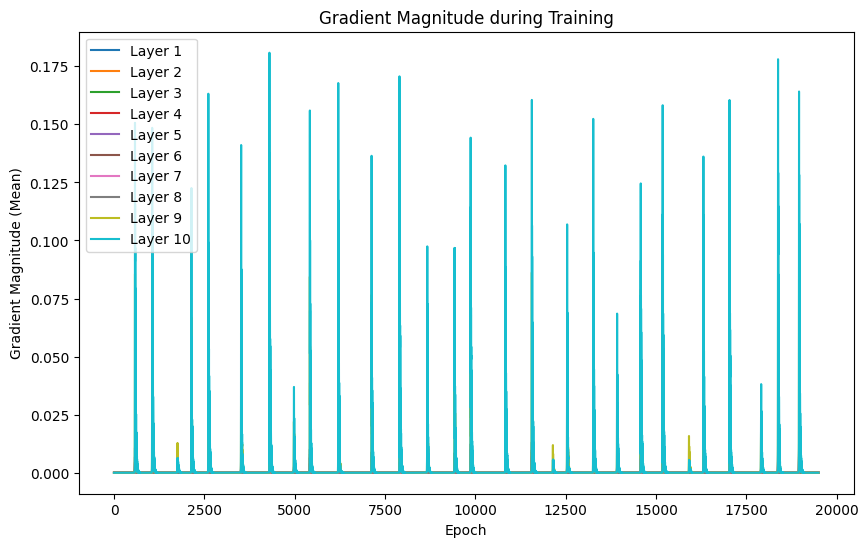

19500 Training Loss: tensor(2.4745e-06)
19501 Training Loss: tensor(2.4744e-06)
19502 Training Loss: tensor(2.4744e-06)
19503 Training Loss: tensor(2.4744e-06)
19504 Training Loss: tensor(2.4744e-06)
19505 Training Loss: tensor(2.4745e-06)
19506 Training Loss: tensor(2.4744e-06)
19507 Training Loss: tensor(2.4743e-06)
19508 Training Loss: tensor(2.4742e-06)
19509 Training Loss: tensor(2.4742e-06)
19510 Training Loss: tensor(2.4742e-06)
19511 Training Loss: tensor(2.4742e-06)
19512 Training Loss: tensor(2.4742e-06)
19513 Training Loss: tensor(2.4742e-06)
19514 Training Loss: tensor(2.4742e-06)
19515 Training Loss: tensor(2.4743e-06)
19516 Training Loss: tensor(2.4741e-06)
19517 Training Loss: tensor(2.4741e-06)
19518 Training Loss: tensor(2.4742e-06)
19519 Training Loss: tensor(2.4743e-06)
19520 Training Loss: tensor(2.4743e-06)
19521 Training Loss: tensor(2.4741e-06)
19522 Training Loss: tensor(2.4742e-06)
19523 Training Loss: tensor(2.4743e-06)
19524 Training Loss: tensor(2.4742e-06)


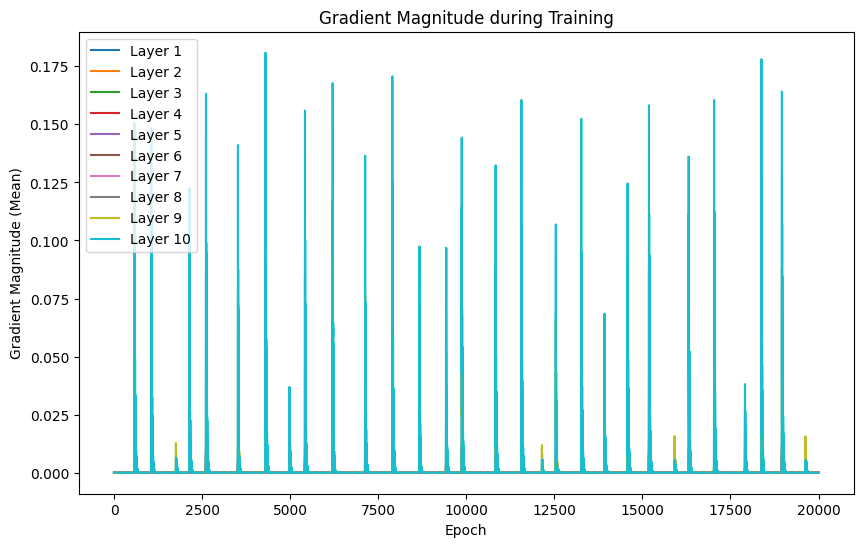

20000 Training Loss: tensor(2.4681e-06)
20001 Training Loss: tensor(2.4681e-06)
20002 Training Loss: tensor(2.4680e-06)
20003 Training Loss: tensor(2.4681e-06)
20004 Training Loss: tensor(2.4680e-06)
20005 Training Loss: tensor(2.4679e-06)
20006 Training Loss: tensor(2.4679e-06)
20007 Training Loss: tensor(2.4679e-06)
20008 Training Loss: tensor(2.4680e-06)
20009 Training Loss: tensor(2.4679e-06)
20010 Training Loss: tensor(2.4679e-06)
20011 Training Loss: tensor(2.4681e-06)
20012 Training Loss: tensor(2.4679e-06)
20013 Training Loss: tensor(2.4679e-06)
20014 Training Loss: tensor(2.4678e-06)
20015 Training Loss: tensor(2.4678e-06)
20016 Training Loss: tensor(2.4678e-06)
20017 Training Loss: tensor(2.4676e-06)
20018 Training Loss: tensor(2.4676e-06)
20019 Training Loss: tensor(2.4676e-06)
20020 Training Loss: tensor(2.4678e-06)
20021 Training Loss: tensor(2.4678e-06)
20022 Training Loss: tensor(2.4676e-06)
20023 Training Loss: tensor(2.4679e-06)
20024 Training Loss: tensor(2.4678e-06)


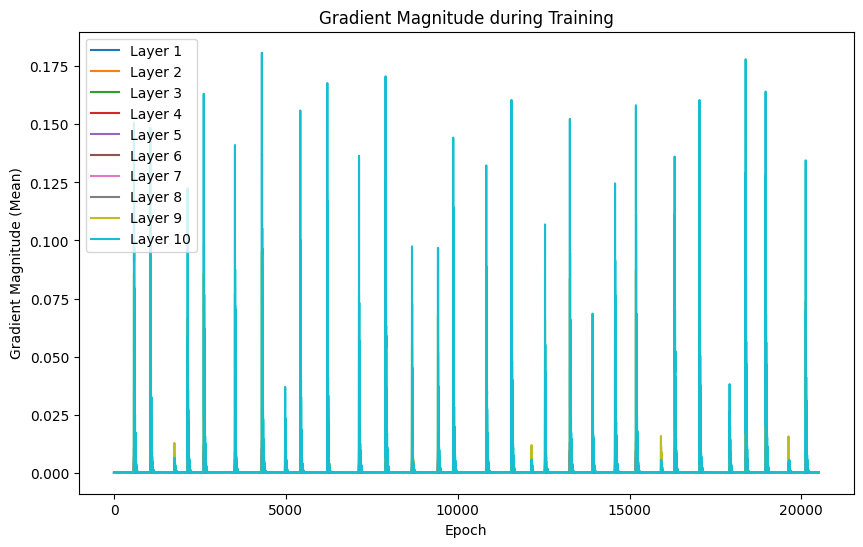

20500 Training Loss: tensor(2.4633e-06)
20501 Training Loss: tensor(2.4631e-06)
20502 Training Loss: tensor(2.4632e-06)
20503 Training Loss: tensor(2.4632e-06)
20504 Training Loss: tensor(2.4633e-06)
20505 Training Loss: tensor(2.4632e-06)
20506 Training Loss: tensor(2.4632e-06)
20507 Training Loss: tensor(2.4630e-06)
20508 Training Loss: tensor(2.4632e-06)
20509 Training Loss: tensor(2.4632e-06)
20510 Training Loss: tensor(2.4631e-06)
20511 Training Loss: tensor(2.4632e-06)
20512 Training Loss: tensor(2.4630e-06)
20513 Training Loss: tensor(2.4630e-06)
20514 Training Loss: tensor(2.4631e-06)
20515 Training Loss: tensor(2.4631e-06)
20516 Training Loss: tensor(2.4631e-06)
20517 Training Loss: tensor(2.4631e-06)
20518 Training Loss: tensor(2.4631e-06)
20519 Training Loss: tensor(2.4630e-06)
20520 Training Loss: tensor(2.4629e-06)
20521 Training Loss: tensor(2.4631e-06)
20522 Training Loss: tensor(2.4629e-06)
20523 Training Loss: tensor(2.4630e-06)
20524 Training Loss: tensor(2.4630e-06)


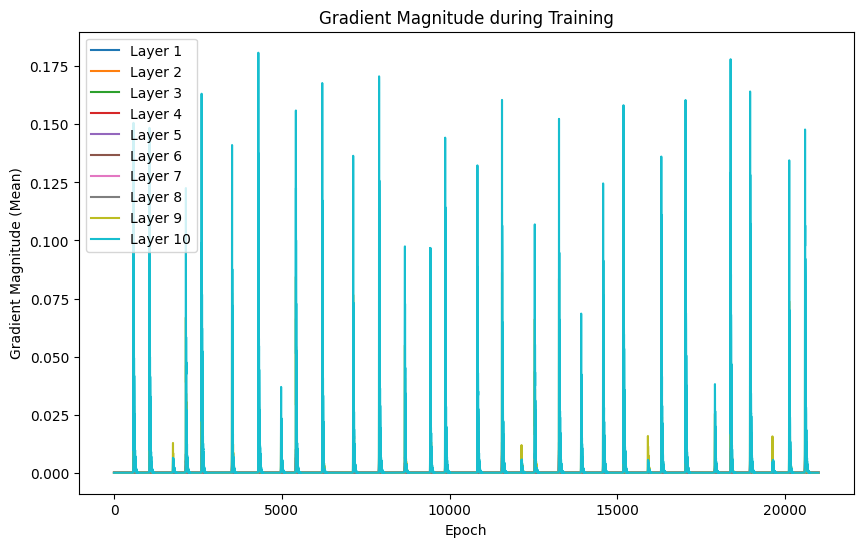

21000 Training Loss: tensor(2.4596e-06)
21001 Training Loss: tensor(2.4596e-06)
21002 Training Loss: tensor(2.4595e-06)
21003 Training Loss: tensor(2.4596e-06)
21004 Training Loss: tensor(2.4596e-06)
21005 Training Loss: tensor(2.4595e-06)
21006 Training Loss: tensor(2.4594e-06)
21007 Training Loss: tensor(2.4596e-06)
21008 Training Loss: tensor(2.4595e-06)
21009 Training Loss: tensor(2.4595e-06)
21010 Training Loss: tensor(2.4596e-06)
21011 Training Loss: tensor(2.4595e-06)
21012 Training Loss: tensor(2.4595e-06)
21013 Training Loss: tensor(2.4595e-06)
21014 Training Loss: tensor(2.4595e-06)
21015 Training Loss: tensor(2.4595e-06)
21016 Training Loss: tensor(2.4594e-06)
21017 Training Loss: tensor(2.4593e-06)
21018 Training Loss: tensor(2.4593e-06)
21019 Training Loss: tensor(2.4595e-06)
21020 Training Loss: tensor(2.4594e-06)
21021 Training Loss: tensor(2.4594e-06)
21022 Training Loss: tensor(2.4595e-06)
21023 Training Loss: tensor(2.4594e-06)
21024 Training Loss: tensor(2.4593e-06)


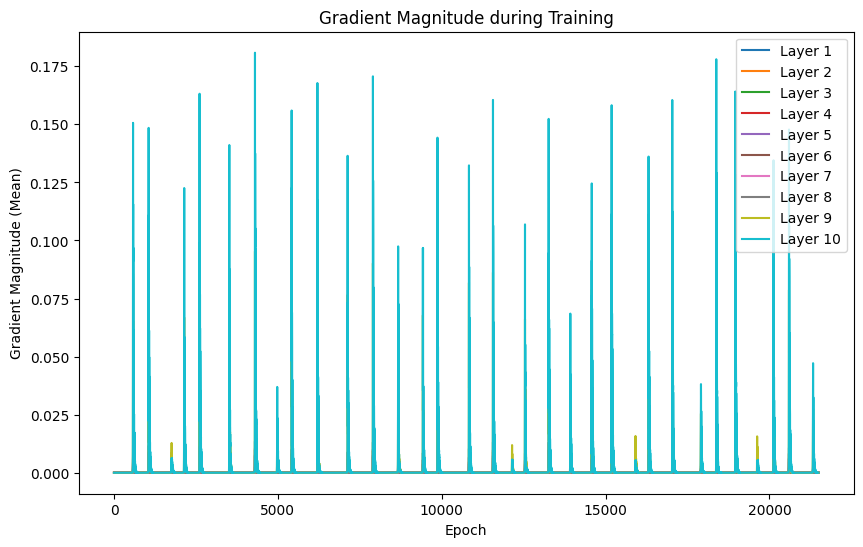

21500 Training Loss: tensor(2.4535e-06)
21501 Training Loss: tensor(2.4536e-06)
21502 Training Loss: tensor(2.4535e-06)
21503 Training Loss: tensor(2.4534e-06)
21504 Training Loss: tensor(2.4535e-06)
21505 Training Loss: tensor(2.4535e-06)
21506 Training Loss: tensor(2.4534e-06)
21507 Training Loss: tensor(2.4535e-06)
21508 Training Loss: tensor(2.4534e-06)
21509 Training Loss: tensor(2.4535e-06)
21510 Training Loss: tensor(2.4534e-06)
21511 Training Loss: tensor(2.4535e-06)
21512 Training Loss: tensor(2.4534e-06)
21513 Training Loss: tensor(2.4534e-06)
21514 Training Loss: tensor(2.4534e-06)
21515 Training Loss: tensor(2.4533e-06)
21516 Training Loss: tensor(2.4534e-06)
21517 Training Loss: tensor(2.4533e-06)
21518 Training Loss: tensor(2.4533e-06)
21519 Training Loss: tensor(2.4532e-06)
21520 Training Loss: tensor(2.4533e-06)
21521 Training Loss: tensor(2.4534e-06)
21522 Training Loss: tensor(2.4533e-06)
21523 Training Loss: tensor(2.4533e-06)
21524 Training Loss: tensor(2.4533e-06)


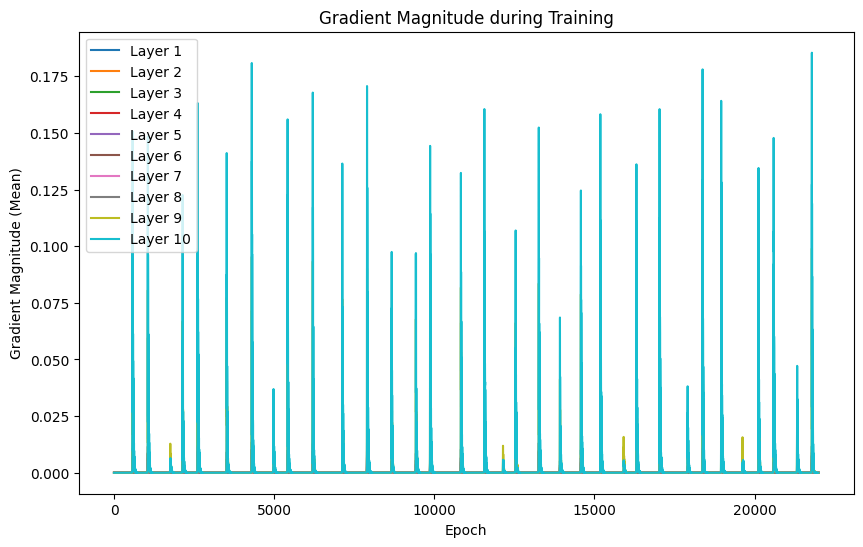

22000 Training Loss: tensor(2.4495e-06)
22001 Training Loss: tensor(2.4495e-06)
22002 Training Loss: tensor(2.4495e-06)
22003 Training Loss: tensor(2.4495e-06)
22004 Training Loss: tensor(2.4495e-06)
22005 Training Loss: tensor(2.4496e-06)
22006 Training Loss: tensor(2.4495e-06)
22007 Training Loss: tensor(2.4495e-06)
22008 Training Loss: tensor(2.4494e-06)
22009 Training Loss: tensor(2.4494e-06)
22010 Training Loss: tensor(2.4494e-06)
22011 Training Loss: tensor(2.4494e-06)
22012 Training Loss: tensor(2.4494e-06)
22013 Training Loss: tensor(2.4493e-06)
22014 Training Loss: tensor(2.4493e-06)
22015 Training Loss: tensor(2.4492e-06)
22016 Training Loss: tensor(2.4493e-06)
22017 Training Loss: tensor(2.4493e-06)
22018 Training Loss: tensor(2.4492e-06)
22019 Training Loss: tensor(2.4493e-06)
22020 Training Loss: tensor(2.4492e-06)
22021 Training Loss: tensor(2.4492e-06)
22022 Training Loss: tensor(2.4492e-06)
22023 Training Loss: tensor(2.4492e-06)
22024 Training Loss: tensor(2.4493e-06)


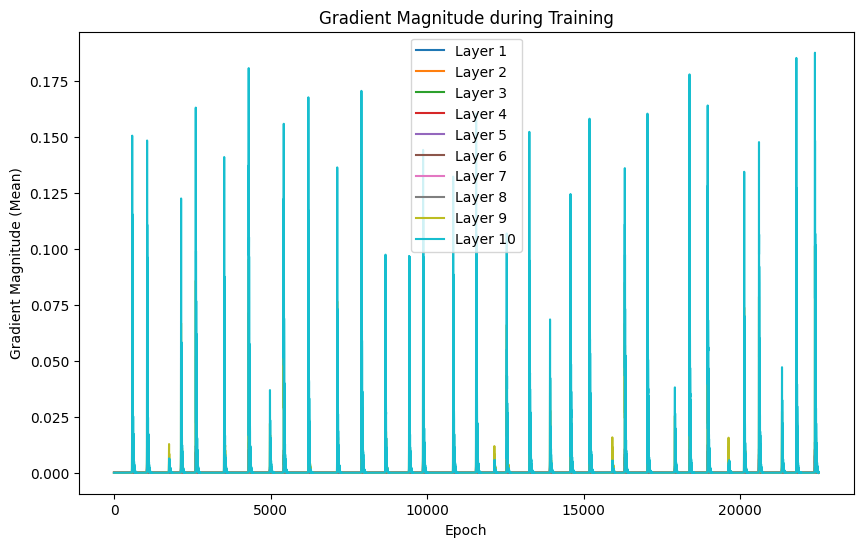

22500 Training Loss: tensor(2.4487e-06)
22501 Training Loss: tensor(2.4546e-06)
22502 Training Loss: tensor(2.4488e-06)
22503 Training Loss: tensor(2.4530e-06)
22504 Training Loss: tensor(2.4495e-06)
22505 Training Loss: tensor(2.4511e-06)
22506 Training Loss: tensor(2.4502e-06)
22507 Training Loss: tensor(2.4497e-06)
22508 Training Loss: tensor(2.4506e-06)
22509 Training Loss: tensor(2.4488e-06)
22510 Training Loss: tensor(2.4505e-06)
22511 Training Loss: tensor(2.4483e-06)
22512 Training Loss: tensor(2.4502e-06)
22513 Training Loss: tensor(2.4483e-06)
22514 Training Loss: tensor(2.4496e-06)
22515 Training Loss: tensor(2.4486e-06)
22516 Training Loss: tensor(2.4488e-06)
22517 Training Loss: tensor(2.4486e-06)
22518 Training Loss: tensor(2.4483e-06)
22519 Training Loss: tensor(2.4487e-06)
22520 Training Loss: tensor(2.4481e-06)
22521 Training Loss: tensor(2.4487e-06)
22522 Training Loss: tensor(2.4479e-06)
22523 Training Loss: tensor(2.4485e-06)
22524 Training Loss: tensor(2.4480e-06)


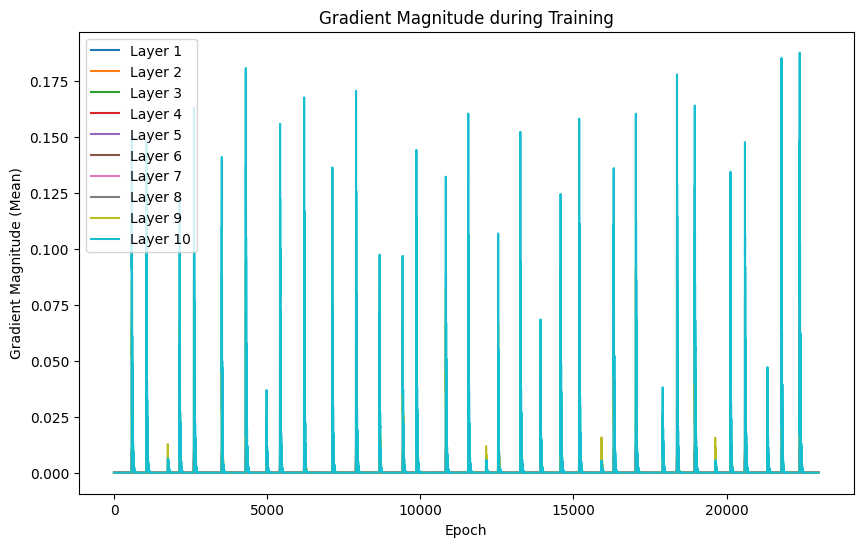

23000 Training Loss: tensor(2.4409e-06)
23001 Training Loss: tensor(2.4409e-06)
23002 Training Loss: tensor(2.4408e-06)
23003 Training Loss: tensor(2.4408e-06)
23004 Training Loss: tensor(2.4408e-06)
23005 Training Loss: tensor(2.4407e-06)
23006 Training Loss: tensor(2.4407e-06)
23007 Training Loss: tensor(2.4408e-06)
23008 Training Loss: tensor(2.4408e-06)
23009 Training Loss: tensor(2.4407e-06)
23010 Training Loss: tensor(2.4407e-06)
23011 Training Loss: tensor(2.4407e-06)
23012 Training Loss: tensor(2.4408e-06)
23013 Training Loss: tensor(2.4406e-06)
23014 Training Loss: tensor(2.4407e-06)
23015 Training Loss: tensor(2.4407e-06)
23016 Training Loss: tensor(2.4406e-06)
23017 Training Loss: tensor(2.4406e-06)
23018 Training Loss: tensor(2.4407e-06)
23019 Training Loss: tensor(2.4407e-06)
23020 Training Loss: tensor(2.4406e-06)
23021 Training Loss: tensor(2.4405e-06)
23022 Training Loss: tensor(2.4406e-06)
23023 Training Loss: tensor(2.4406e-06)
23024 Training Loss: tensor(2.4406e-06)


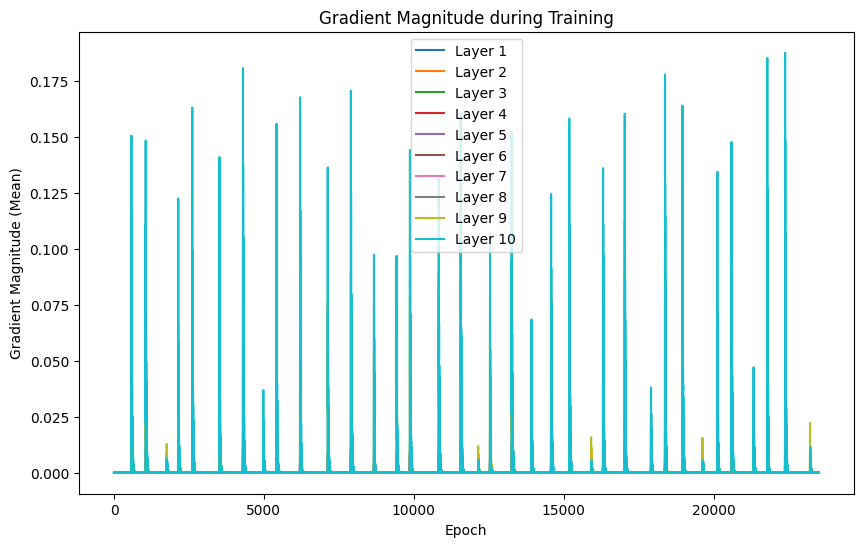

23500 Training Loss: tensor(2.4348e-06)
23501 Training Loss: tensor(2.4348e-06)
23502 Training Loss: tensor(2.4349e-06)
23503 Training Loss: tensor(2.4349e-06)
23504 Training Loss: tensor(2.4347e-06)
23505 Training Loss: tensor(2.4347e-06)
23506 Training Loss: tensor(2.4347e-06)
23507 Training Loss: tensor(2.4347e-06)
23508 Training Loss: tensor(2.4347e-06)
23509 Training Loss: tensor(2.4347e-06)
23510 Training Loss: tensor(2.4347e-06)
23511 Training Loss: tensor(2.4347e-06)
23512 Training Loss: tensor(2.4347e-06)
23513 Training Loss: tensor(2.4347e-06)
23514 Training Loss: tensor(2.4347e-06)
23515 Training Loss: tensor(2.4345e-06)
23516 Training Loss: tensor(2.4346e-06)
23517 Training Loss: tensor(2.4347e-06)
23518 Training Loss: tensor(2.4346e-06)
23519 Training Loss: tensor(2.4347e-06)
23520 Training Loss: tensor(2.4347e-06)
23521 Training Loss: tensor(2.4347e-06)
23522 Training Loss: tensor(2.4345e-06)
23523 Training Loss: tensor(2.4345e-06)
23524 Training Loss: tensor(2.4344e-06)


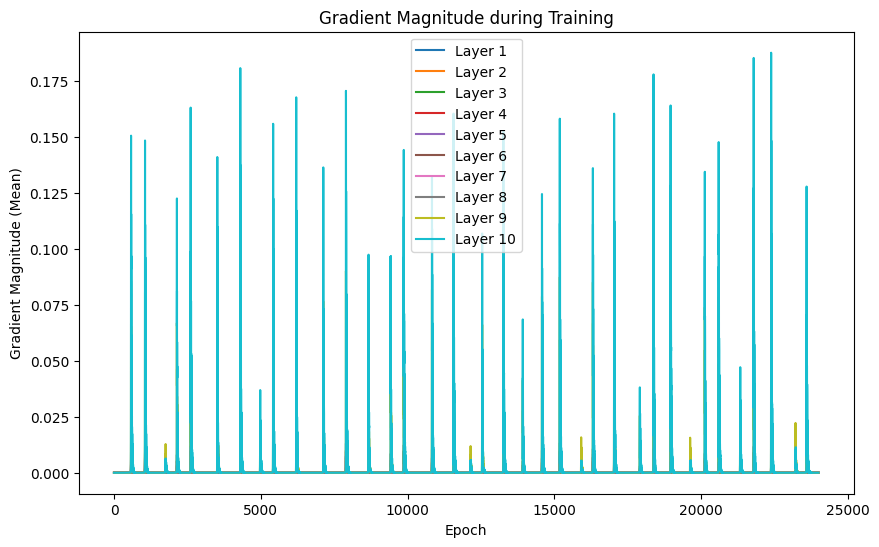

24000 Training Loss: tensor(2.4298e-06)
24001 Training Loss: tensor(2.4298e-06)
24002 Training Loss: tensor(2.4297e-06)
24003 Training Loss: tensor(2.4299e-06)
24004 Training Loss: tensor(2.4299e-06)
24005 Training Loss: tensor(2.4299e-06)
24006 Training Loss: tensor(2.4298e-06)
24007 Training Loss: tensor(2.4298e-06)
24008 Training Loss: tensor(2.4297e-06)
24009 Training Loss: tensor(2.4297e-06)
24010 Training Loss: tensor(2.4297e-06)
24011 Training Loss: tensor(2.4296e-06)
24012 Training Loss: tensor(2.4297e-06)
24013 Training Loss: tensor(2.4297e-06)
24014 Training Loss: tensor(2.4295e-06)
24015 Training Loss: tensor(2.4295e-06)
24016 Training Loss: tensor(2.4295e-06)
24017 Training Loss: tensor(2.4296e-06)
24018 Training Loss: tensor(2.4296e-06)
24019 Training Loss: tensor(2.4296e-06)
24020 Training Loss: tensor(2.4295e-06)
24021 Training Loss: tensor(2.4296e-06)
24022 Training Loss: tensor(2.4297e-06)
24023 Training Loss: tensor(2.4295e-06)
24024 Training Loss: tensor(2.4295e-06)


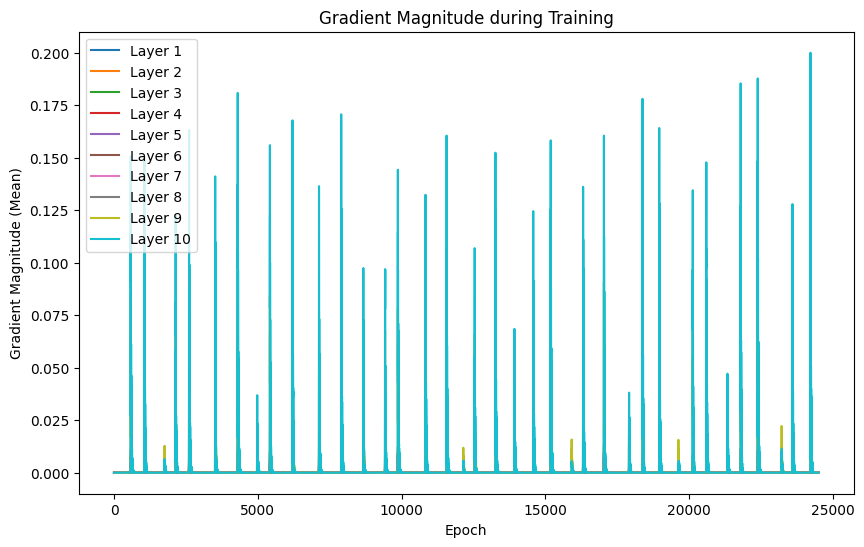

24500 Training Loss: tensor(2.4275e-06)
24501 Training Loss: tensor(2.4275e-06)
24502 Training Loss: tensor(2.4276e-06)
24503 Training Loss: tensor(2.4275e-06)
24504 Training Loss: tensor(2.4276e-06)
24505 Training Loss: tensor(2.4274e-06)
24506 Training Loss: tensor(2.4274e-06)
24507 Training Loss: tensor(2.4274e-06)
24508 Training Loss: tensor(2.4273e-06)
24509 Training Loss: tensor(2.4273e-06)
24510 Training Loss: tensor(2.4273e-06)
24511 Training Loss: tensor(2.4273e-06)
24512 Training Loss: tensor(2.4273e-06)
24513 Training Loss: tensor(2.4272e-06)
24514 Training Loss: tensor(2.4272e-06)
24515 Training Loss: tensor(2.4272e-06)
24516 Training Loss: tensor(2.4272e-06)
24517 Training Loss: tensor(2.4273e-06)
24518 Training Loss: tensor(2.4274e-06)
24519 Training Loss: tensor(2.4273e-06)
24520 Training Loss: tensor(2.4272e-06)
24521 Training Loss: tensor(2.4272e-06)
24522 Training Loss: tensor(2.4273e-06)
24523 Training Loss: tensor(2.4272e-06)
24524 Training Loss: tensor(2.4272e-06)


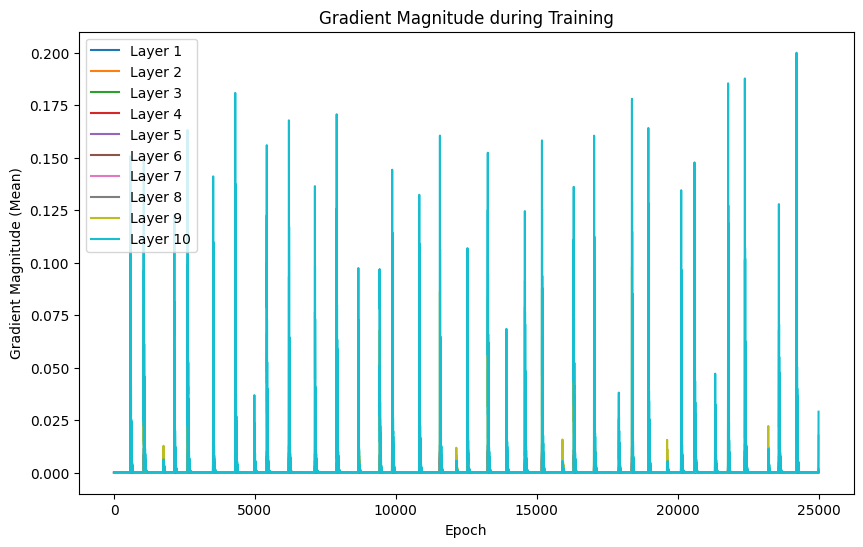

25000 Training Loss: tensor(3.9307e-05)
25001 Training Loss: tensor(8.6334e-05)
25002 Training Loss: tensor(0.0002)
25003 Training Loss: tensor(0.0003)
25004 Training Loss: tensor(0.0003)
25005 Training Loss: tensor(0.0002)
25006 Training Loss: tensor(4.6433e-05)
25007 Training Loss: tensor(7.0223e-05)
25008 Training Loss: tensor(0.0001)
25009 Training Loss: tensor(0.0001)
25010 Training Loss: tensor(4.9748e-05)
25011 Training Loss: tensor(3.7521e-05)
25012 Training Loss: tensor(7.4492e-05)
25013 Training Loss: tensor(7.2172e-05)
25014 Training Loss: tensor(2.0725e-05)
25015 Training Loss: tensor(2.8935e-05)
25016 Training Loss: tensor(6.4530e-05)
25017 Training Loss: tensor(2.8935e-05)
25018 Training Loss: tensor(7.8000e-06)
25019 Training Loss: tensor(4.2637e-05)
25020 Training Loss: tensor(3.2537e-05)
25021 Training Loss: tensor(5.2591e-06)
25022 Training Loss: tensor(2.3902e-05)
25023 Training Loss: tensor(2.7513e-05)
25024 Training Loss: tensor(9.1145e-06)
25025 Training Loss: ten

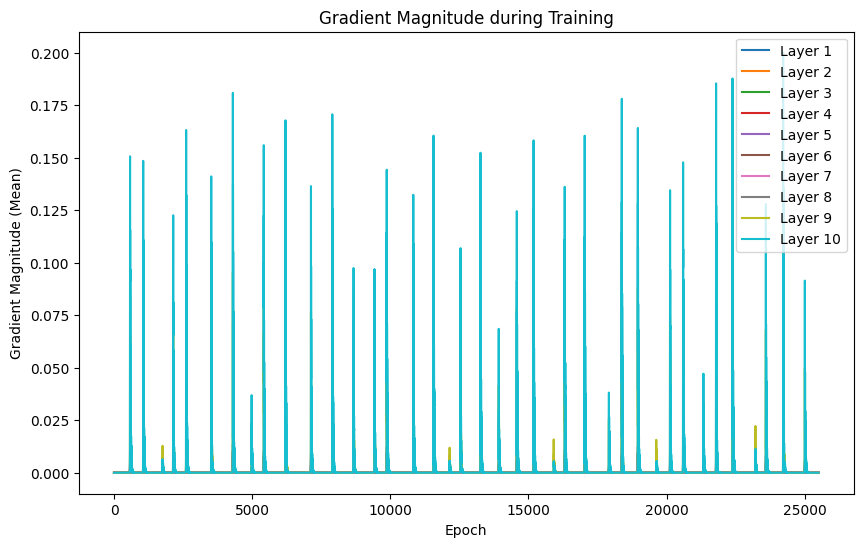

25500 Training Loss: tensor(2.4163e-06)
25501 Training Loss: tensor(2.4162e-06)
25502 Training Loss: tensor(2.4163e-06)
25503 Training Loss: tensor(2.4162e-06)
25504 Training Loss: tensor(2.4162e-06)
25505 Training Loss: tensor(2.4162e-06)
25506 Training Loss: tensor(2.4162e-06)
25507 Training Loss: tensor(2.4160e-06)
25508 Training Loss: tensor(2.4160e-06)
25509 Training Loss: tensor(2.4161e-06)
25510 Training Loss: tensor(2.4162e-06)
25511 Training Loss: tensor(2.4161e-06)
25512 Training Loss: tensor(2.4162e-06)
25513 Training Loss: tensor(2.4159e-06)
25514 Training Loss: tensor(2.4160e-06)
25515 Training Loss: tensor(2.4160e-06)
25516 Training Loss: tensor(2.4160e-06)
25517 Training Loss: tensor(2.4160e-06)
25518 Training Loss: tensor(2.4159e-06)
25519 Training Loss: tensor(2.4160e-06)
25520 Training Loss: tensor(2.4159e-06)
25521 Training Loss: tensor(2.4160e-06)
25522 Training Loss: tensor(2.4160e-06)
25523 Training Loss: tensor(2.4159e-06)
25524 Training Loss: tensor(2.4158e-06)


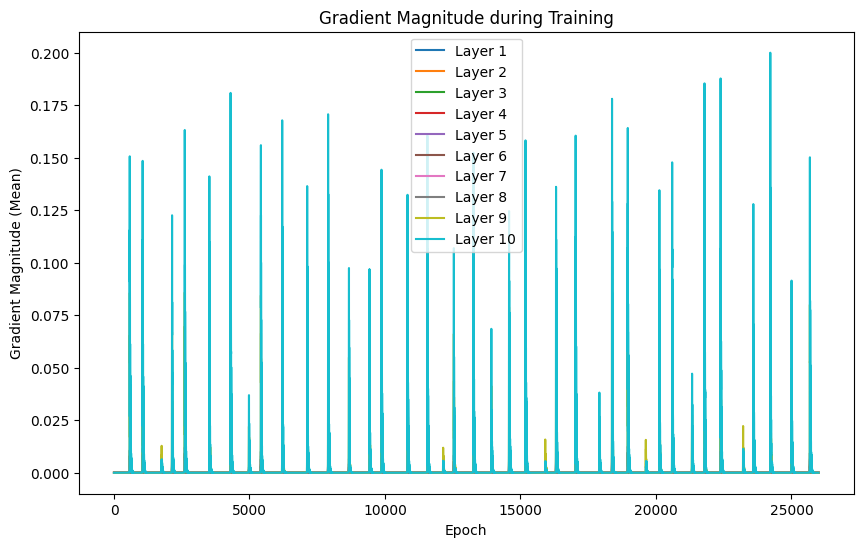

26000 Training Loss: tensor(2.4118e-06)
26001 Training Loss: tensor(2.4117e-06)
26002 Training Loss: tensor(2.4117e-06)
26003 Training Loss: tensor(2.4116e-06)
26004 Training Loss: tensor(2.4117e-06)
26005 Training Loss: tensor(2.4117e-06)
26006 Training Loss: tensor(2.4116e-06)
26007 Training Loss: tensor(2.4116e-06)
26008 Training Loss: tensor(2.4116e-06)
26009 Training Loss: tensor(2.4116e-06)
26010 Training Loss: tensor(2.4115e-06)
26011 Training Loss: tensor(2.4115e-06)
26012 Training Loss: tensor(2.4116e-06)
26013 Training Loss: tensor(2.4115e-06)
26014 Training Loss: tensor(2.4115e-06)
26015 Training Loss: tensor(2.4114e-06)
26016 Training Loss: tensor(2.4114e-06)
26017 Training Loss: tensor(2.4115e-06)
26018 Training Loss: tensor(2.4115e-06)
26019 Training Loss: tensor(2.4115e-06)
26020 Training Loss: tensor(2.4116e-06)
26021 Training Loss: tensor(2.4115e-06)
26022 Training Loss: tensor(2.4115e-06)
26023 Training Loss: tensor(2.4114e-06)
26024 Training Loss: tensor(2.4114e-06)


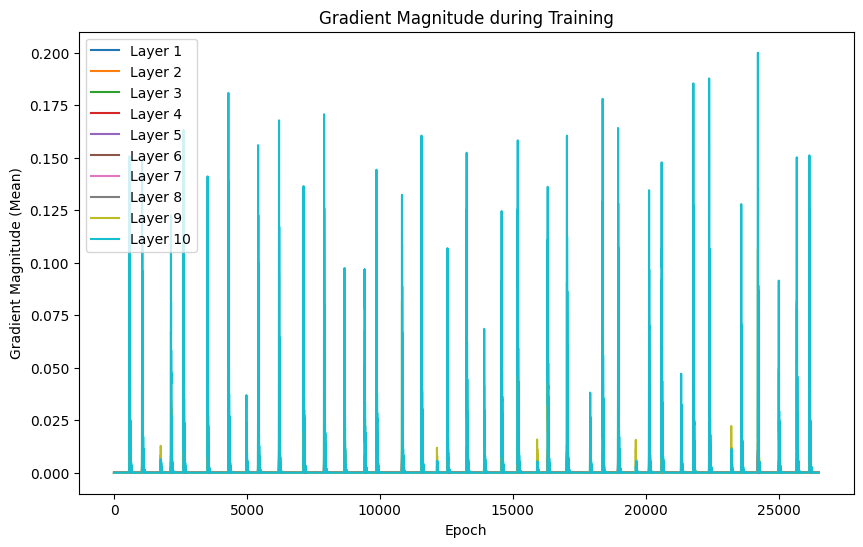

26500 Training Loss: tensor(2.4086e-06)
26501 Training Loss: tensor(2.4085e-06)
26502 Training Loss: tensor(2.4084e-06)
26503 Training Loss: tensor(2.4085e-06)
26504 Training Loss: tensor(2.4085e-06)
26505 Training Loss: tensor(2.4085e-06)
26506 Training Loss: tensor(2.4084e-06)
26507 Training Loss: tensor(2.4084e-06)
26508 Training Loss: tensor(2.4085e-06)
26509 Training Loss: tensor(2.4084e-06)
26510 Training Loss: tensor(2.4084e-06)
26511 Training Loss: tensor(2.4084e-06)
26512 Training Loss: tensor(2.4084e-06)
26513 Training Loss: tensor(2.4085e-06)
26514 Training Loss: tensor(2.4085e-06)
26515 Training Loss: tensor(2.4083e-06)
26516 Training Loss: tensor(2.4084e-06)
26517 Training Loss: tensor(2.4084e-06)
26518 Training Loss: tensor(2.4084e-06)
26519 Training Loss: tensor(2.4084e-06)
26520 Training Loss: tensor(2.4082e-06)
26521 Training Loss: tensor(2.4083e-06)
26522 Training Loss: tensor(2.4083e-06)
26523 Training Loss: tensor(2.4082e-06)
26524 Training Loss: tensor(2.4081e-06)


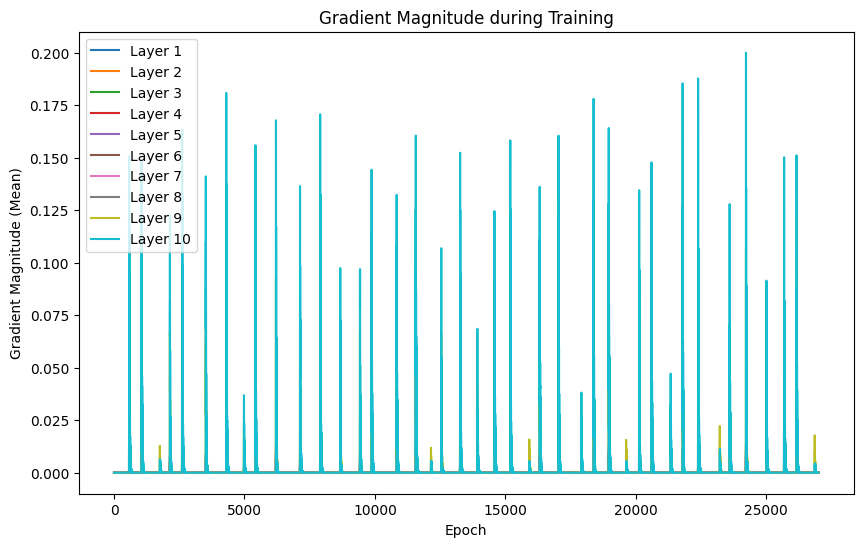

27000 Training Loss: tensor(2.4027e-06)
27001 Training Loss: tensor(2.4026e-06)
27002 Training Loss: tensor(2.4025e-06)
27003 Training Loss: tensor(2.4024e-06)
27004 Training Loss: tensor(2.4025e-06)
27005 Training Loss: tensor(2.4024e-06)
27006 Training Loss: tensor(2.4025e-06)
27007 Training Loss: tensor(2.4025e-06)
27008 Training Loss: tensor(2.4025e-06)
27009 Training Loss: tensor(2.4026e-06)
27010 Training Loss: tensor(2.4025e-06)
27011 Training Loss: tensor(2.4025e-06)
27012 Training Loss: tensor(2.4025e-06)
27013 Training Loss: tensor(2.4025e-06)
27014 Training Loss: tensor(2.4025e-06)
27015 Training Loss: tensor(2.4025e-06)
27016 Training Loss: tensor(2.4027e-06)
27017 Training Loss: tensor(2.4026e-06)
27018 Training Loss: tensor(2.4027e-06)
27019 Training Loss: tensor(2.4026e-06)
27020 Training Loss: tensor(2.4024e-06)
27021 Training Loss: tensor(2.4023e-06)
27022 Training Loss: tensor(2.4023e-06)
27023 Training Loss: tensor(2.4023e-06)
27024 Training Loss: tensor(2.4024e-06)


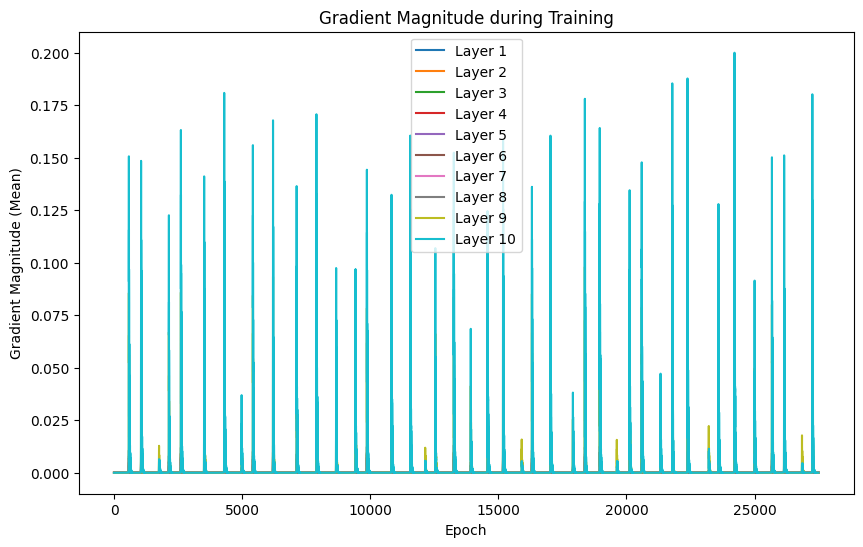

27500 Training Loss: tensor(2.3986e-06)
27501 Training Loss: tensor(2.3985e-06)
27502 Training Loss: tensor(2.3986e-06)
27503 Training Loss: tensor(2.3986e-06)
27504 Training Loss: tensor(2.3986e-06)
27505 Training Loss: tensor(2.3986e-06)
27506 Training Loss: tensor(2.3986e-06)
27507 Training Loss: tensor(2.3986e-06)
27508 Training Loss: tensor(2.3986e-06)
27509 Training Loss: tensor(2.3985e-06)
27510 Training Loss: tensor(2.3985e-06)
27511 Training Loss: tensor(2.3986e-06)
27512 Training Loss: tensor(2.3985e-06)
27513 Training Loss: tensor(2.3983e-06)
27514 Training Loss: tensor(2.3984e-06)
27515 Training Loss: tensor(2.3985e-06)
27516 Training Loss: tensor(2.3984e-06)
27517 Training Loss: tensor(2.3984e-06)
27518 Training Loss: tensor(2.3984e-06)
27519 Training Loss: tensor(2.3984e-06)
27520 Training Loss: tensor(2.3985e-06)
27521 Training Loss: tensor(2.3984e-06)
27522 Training Loss: tensor(2.3983e-06)
27523 Training Loss: tensor(2.3983e-06)
27524 Training Loss: tensor(2.3983e-06)


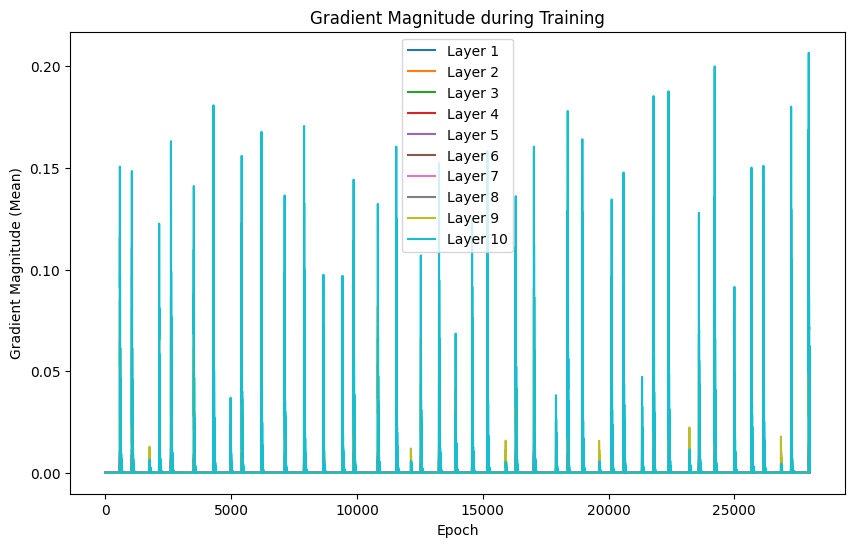

28000 Training Loss: tensor(1.7831e-05)
28001 Training Loss: tensor(3.7413e-06)
28002 Training Loss: tensor(1.4380e-05)
28003 Training Loss: tensor(4.1919e-06)
28004 Training Loss: tensor(1.1271e-05)
28005 Training Loss: tensor(4.7510e-06)
28006 Training Loss: tensor(8.6856e-06)
28007 Training Loss: tensor(5.1849e-06)
28008 Training Loss: tensor(6.6798e-06)
28009 Training Loss: tensor(5.4203e-06)
28010 Training Loss: tensor(5.1484e-06)
28011 Training Loss: tensor(5.5030e-06)
28012 Training Loss: tensor(4.0604e-06)
28013 Training Loss: tensor(5.3858e-06)
28014 Training Loss: tensor(3.3658e-06)
28015 Training Loss: tensor(5.1304e-06)
28016 Training Loss: tensor(2.9363e-06)
28017 Training Loss: tensor(4.8056e-06)
28018 Training Loss: tensor(2.7001e-06)
28019 Training Loss: tensor(4.4283e-06)
28020 Training Loss: tensor(2.6175e-06)
28021 Training Loss: tensor(4.0354e-06)
28022 Training Loss: tensor(2.6118e-06)
28023 Training Loss: tensor(3.6694e-06)
28024 Training Loss: tensor(2.6451e-06)


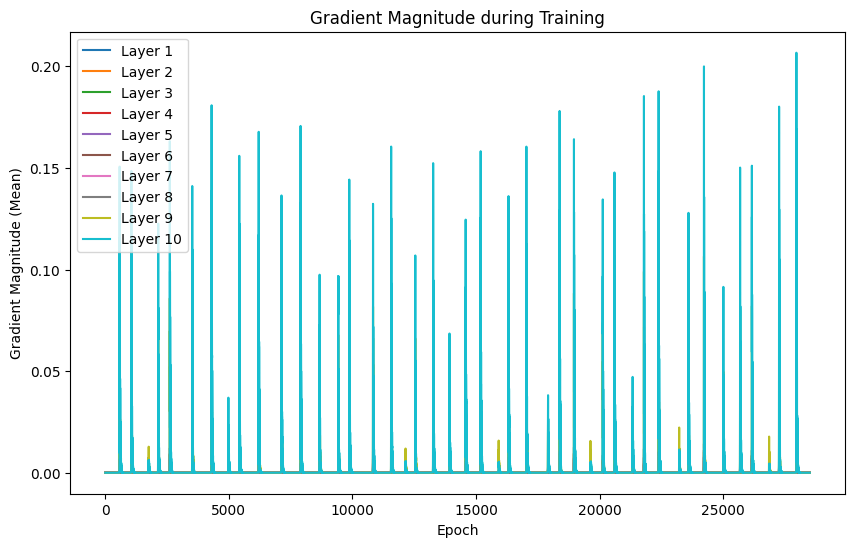

28500 Training Loss: tensor(2.3911e-06)
28501 Training Loss: tensor(2.3911e-06)
28502 Training Loss: tensor(2.3911e-06)
28503 Training Loss: tensor(2.3911e-06)
28504 Training Loss: tensor(2.3911e-06)
28505 Training Loss: tensor(2.3914e-06)
28506 Training Loss: tensor(2.3912e-06)
28507 Training Loss: tensor(2.3912e-06)
28508 Training Loss: tensor(2.3911e-06)
28509 Training Loss: tensor(2.3911e-06)
28510 Training Loss: tensor(2.3911e-06)
28511 Training Loss: tensor(2.3911e-06)
28512 Training Loss: tensor(2.3910e-06)
28513 Training Loss: tensor(2.3910e-06)
28514 Training Loss: tensor(2.3910e-06)
28515 Training Loss: tensor(2.3909e-06)
28516 Training Loss: tensor(2.3909e-06)
28517 Training Loss: tensor(2.3909e-06)
28518 Training Loss: tensor(2.3910e-06)
28519 Training Loss: tensor(2.3909e-06)
28520 Training Loss: tensor(2.3908e-06)
28521 Training Loss: tensor(2.3908e-06)
28522 Training Loss: tensor(2.3908e-06)
28523 Training Loss: tensor(2.3909e-06)
28524 Training Loss: tensor(2.3908e-06)


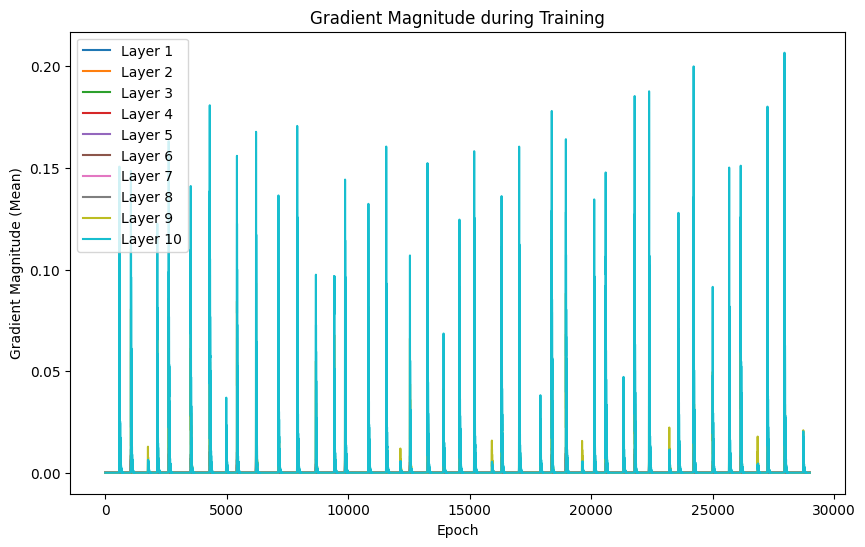

29000 Training Loss: tensor(2.3855e-06)
29001 Training Loss: tensor(2.3855e-06)
29002 Training Loss: tensor(2.3857e-06)
29003 Training Loss: tensor(2.3855e-06)
29004 Training Loss: tensor(2.3855e-06)
29005 Training Loss: tensor(2.3854e-06)
29006 Training Loss: tensor(2.3853e-06)
29007 Training Loss: tensor(2.3853e-06)
29008 Training Loss: tensor(2.3854e-06)
29009 Training Loss: tensor(2.3853e-06)
29010 Training Loss: tensor(2.3855e-06)
29011 Training Loss: tensor(2.3855e-06)
29012 Training Loss: tensor(2.3854e-06)
29013 Training Loss: tensor(2.3853e-06)
29014 Training Loss: tensor(2.3853e-06)
29015 Training Loss: tensor(2.3852e-06)
29016 Training Loss: tensor(2.3852e-06)
29017 Training Loss: tensor(2.3852e-06)
29018 Training Loss: tensor(2.3853e-06)
29019 Training Loss: tensor(2.3852e-06)
29020 Training Loss: tensor(2.3852e-06)
29021 Training Loss: tensor(2.3852e-06)
29022 Training Loss: tensor(2.3851e-06)
29023 Training Loss: tensor(2.3851e-06)
29024 Training Loss: tensor(2.3851e-06)


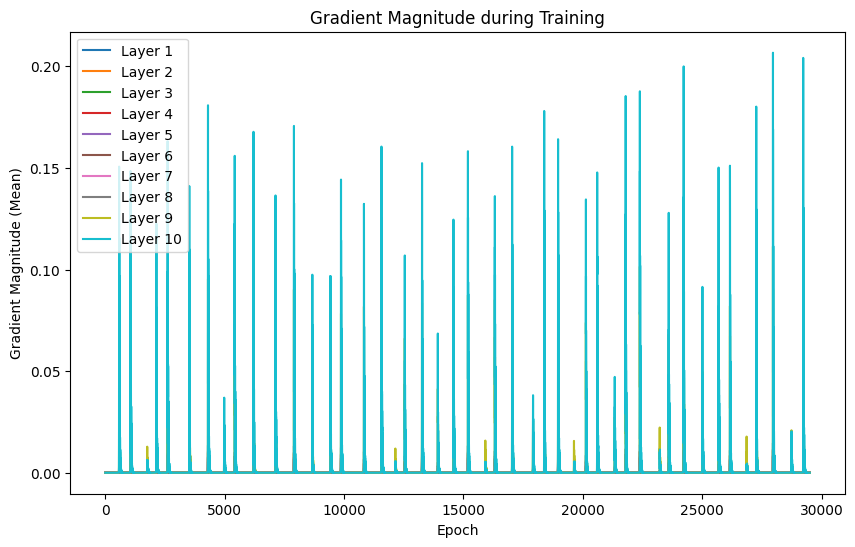

29500 Training Loss: tensor(2.3824e-06)
29501 Training Loss: tensor(2.3823e-06)
29502 Training Loss: tensor(2.3824e-06)
29503 Training Loss: tensor(2.3824e-06)
29504 Training Loss: tensor(2.3822e-06)
29505 Training Loss: tensor(2.3822e-06)
29506 Training Loss: tensor(2.3821e-06)
29507 Training Loss: tensor(2.3822e-06)
29508 Training Loss: tensor(2.3822e-06)
29509 Training Loss: tensor(2.3822e-06)
29510 Training Loss: tensor(2.3822e-06)
29511 Training Loss: tensor(2.3823e-06)
29512 Training Loss: tensor(2.3822e-06)
29513 Training Loss: tensor(2.3822e-06)
29514 Training Loss: tensor(2.3822e-06)
29515 Training Loss: tensor(2.3821e-06)
29516 Training Loss: tensor(2.3820e-06)
29517 Training Loss: tensor(2.3821e-06)
29518 Training Loss: tensor(2.3822e-06)
29519 Training Loss: tensor(2.3821e-06)
29520 Training Loss: tensor(2.3821e-06)
29521 Training Loss: tensor(2.3821e-06)
29522 Training Loss: tensor(2.3820e-06)
29523 Training Loss: tensor(2.3820e-06)
29524 Training Loss: tensor(2.3820e-06)


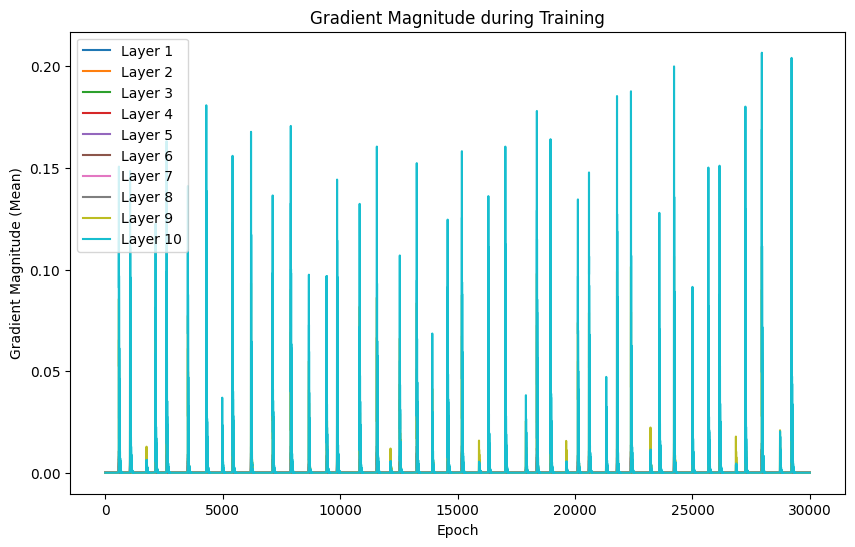

30000 Training Loss: tensor(2.3769e-06)
30001 Training Loss: tensor(2.3768e-06)
30002 Training Loss: tensor(2.3768e-06)
30003 Training Loss: tensor(2.3767e-06)
30004 Training Loss: tensor(2.3767e-06)
30005 Training Loss: tensor(2.3768e-06)
30006 Training Loss: tensor(2.3767e-06)
30007 Training Loss: tensor(2.3767e-06)
30008 Training Loss: tensor(2.3768e-06)
30009 Training Loss: tensor(2.3768e-06)
30010 Training Loss: tensor(2.3768e-06)
30011 Training Loss: tensor(2.3767e-06)
30012 Training Loss: tensor(2.3767e-06)
30013 Training Loss: tensor(2.3766e-06)
30014 Training Loss: tensor(2.3765e-06)
30015 Training Loss: tensor(2.3765e-06)
30016 Training Loss: tensor(2.3765e-06)
30017 Training Loss: tensor(2.3766e-06)
30018 Training Loss: tensor(2.3765e-06)
30019 Training Loss: tensor(2.3766e-06)
30020 Training Loss: tensor(2.3766e-06)
30021 Training Loss: tensor(2.3764e-06)
30022 Training Loss: tensor(2.3765e-06)
30023 Training Loss: tensor(2.3765e-06)
30024 Training Loss: tensor(2.3765e-06)


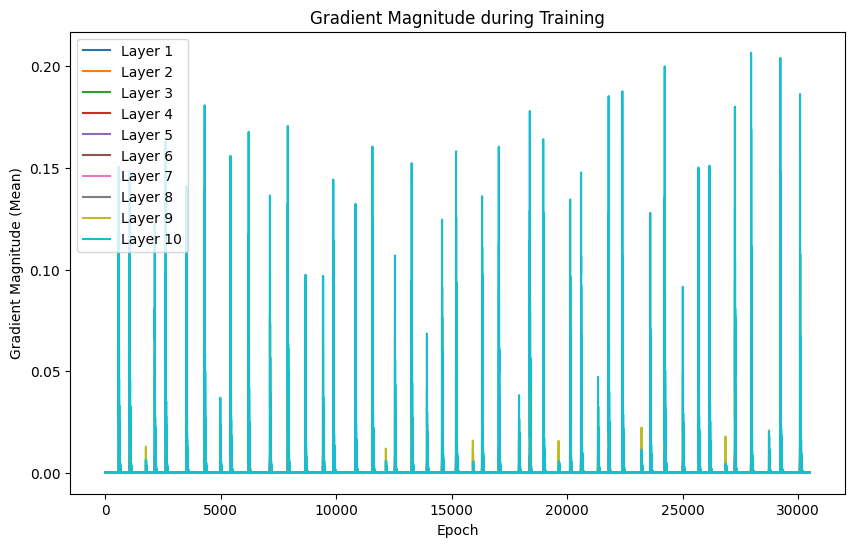

30500 Training Loss: tensor(2.3745e-06)
30501 Training Loss: tensor(2.3746e-06)
30502 Training Loss: tensor(2.3745e-06)
30503 Training Loss: tensor(2.3744e-06)
30504 Training Loss: tensor(2.3744e-06)
30505 Training Loss: tensor(2.3744e-06)
30506 Training Loss: tensor(2.3744e-06)
30507 Training Loss: tensor(2.3743e-06)
30508 Training Loss: tensor(2.3744e-06)
30509 Training Loss: tensor(2.3743e-06)
30510 Training Loss: tensor(2.3744e-06)
30511 Training Loss: tensor(2.3743e-06)
30512 Training Loss: tensor(2.3744e-06)
30513 Training Loss: tensor(2.3742e-06)
30514 Training Loss: tensor(2.3743e-06)
30515 Training Loss: tensor(2.3744e-06)
30516 Training Loss: tensor(2.3743e-06)
30517 Training Loss: tensor(2.3743e-06)
30518 Training Loss: tensor(2.3744e-06)
30519 Training Loss: tensor(2.3742e-06)
30520 Training Loss: tensor(2.3744e-06)
30521 Training Loss: tensor(2.3743e-06)
30522 Training Loss: tensor(2.3743e-06)
30523 Training Loss: tensor(2.3743e-06)
30524 Training Loss: tensor(2.3742e-06)


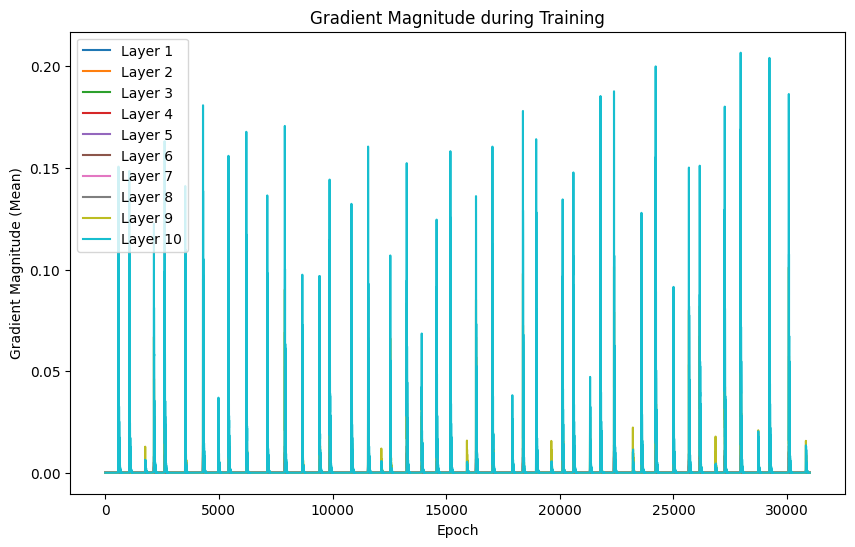

31000 Training Loss: tensor(2.3687e-06)
31001 Training Loss: tensor(2.3688e-06)
31002 Training Loss: tensor(2.3687e-06)
31003 Training Loss: tensor(2.3687e-06)
31004 Training Loss: tensor(2.3687e-06)
31005 Training Loss: tensor(2.3687e-06)
31006 Training Loss: tensor(2.3687e-06)
31007 Training Loss: tensor(2.3687e-06)
31008 Training Loss: tensor(2.3688e-06)
31009 Training Loss: tensor(2.3688e-06)
31010 Training Loss: tensor(2.3687e-06)
31011 Training Loss: tensor(2.3687e-06)
31012 Training Loss: tensor(2.3687e-06)
31013 Training Loss: tensor(2.3687e-06)
31014 Training Loss: tensor(2.3685e-06)
31015 Training Loss: tensor(2.3686e-06)
31016 Training Loss: tensor(2.3685e-06)
31017 Training Loss: tensor(2.3686e-06)
31018 Training Loss: tensor(2.3686e-06)
31019 Training Loss: tensor(2.3686e-06)
31020 Training Loss: tensor(2.3685e-06)
31021 Training Loss: tensor(2.3685e-06)
31022 Training Loss: tensor(2.3685e-06)
31023 Training Loss: tensor(2.3685e-06)
31024 Training Loss: tensor(2.3685e-06)


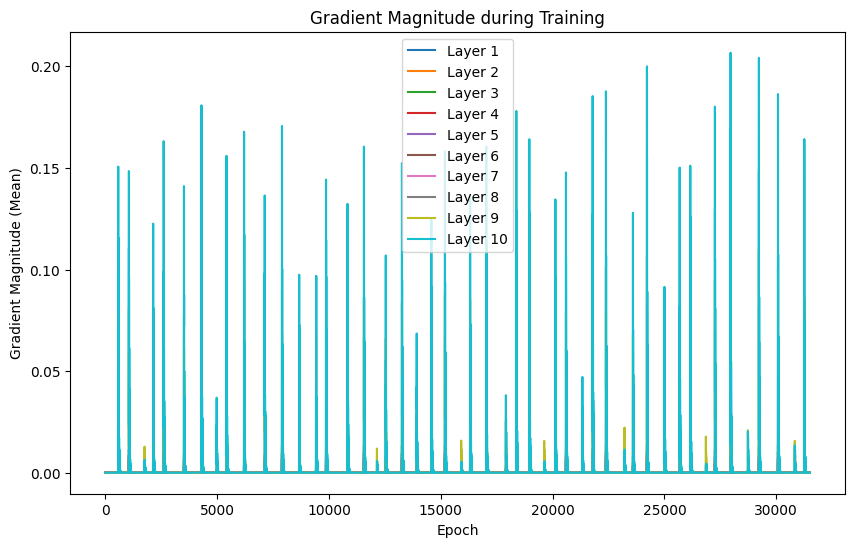

31500 Training Loss: tensor(2.3651e-06)
31501 Training Loss: tensor(2.3649e-06)
31502 Training Loss: tensor(2.3649e-06)
31503 Training Loss: tensor(2.3649e-06)
31504 Training Loss: tensor(2.3648e-06)
31505 Training Loss: tensor(2.3648e-06)
31506 Training Loss: tensor(2.3649e-06)
31507 Training Loss: tensor(2.3648e-06)
31508 Training Loss: tensor(2.3648e-06)
31509 Training Loss: tensor(2.3649e-06)
31510 Training Loss: tensor(2.3648e-06)
31511 Training Loss: tensor(2.3648e-06)
31512 Training Loss: tensor(2.3648e-06)
31513 Training Loss: tensor(2.3649e-06)
31514 Training Loss: tensor(2.3647e-06)
31515 Training Loss: tensor(2.3648e-06)
31516 Training Loss: tensor(2.3648e-06)
31517 Training Loss: tensor(2.3648e-06)
31518 Training Loss: tensor(2.3647e-06)
31519 Training Loss: tensor(2.3647e-06)
31520 Training Loss: tensor(2.3647e-06)
31521 Training Loss: tensor(2.3647e-06)
31522 Training Loss: tensor(2.3647e-06)
31523 Training Loss: tensor(2.3647e-06)
31524 Training Loss: tensor(2.3647e-06)


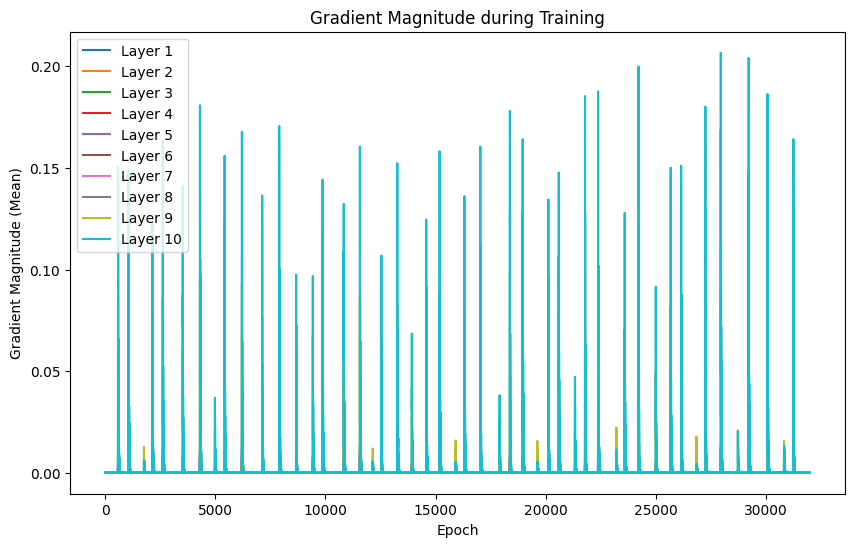

32000 Training Loss: tensor(2.3594e-06)
32001 Training Loss: tensor(2.3595e-06)
32002 Training Loss: tensor(2.3595e-06)
32003 Training Loss: tensor(2.3594e-06)
32004 Training Loss: tensor(2.3595e-06)
32005 Training Loss: tensor(2.3595e-06)
32006 Training Loss: tensor(2.3596e-06)
32007 Training Loss: tensor(2.3594e-06)
32008 Training Loss: tensor(2.3596e-06)
32009 Training Loss: tensor(2.3594e-06)
32010 Training Loss: tensor(2.3595e-06)
32011 Training Loss: tensor(2.3594e-06)
32012 Training Loss: tensor(2.3594e-06)
32013 Training Loss: tensor(2.3592e-06)
32014 Training Loss: tensor(2.3593e-06)
32015 Training Loss: tensor(2.3592e-06)
32016 Training Loss: tensor(2.3592e-06)
32017 Training Loss: tensor(2.3592e-06)
32018 Training Loss: tensor(2.3593e-06)
32019 Training Loss: tensor(2.3592e-06)
32020 Training Loss: tensor(2.3592e-06)
32021 Training Loss: tensor(2.3593e-06)
32022 Training Loss: tensor(2.3593e-06)
32023 Training Loss: tensor(2.3593e-06)
32024 Training Loss: tensor(2.3593e-06)


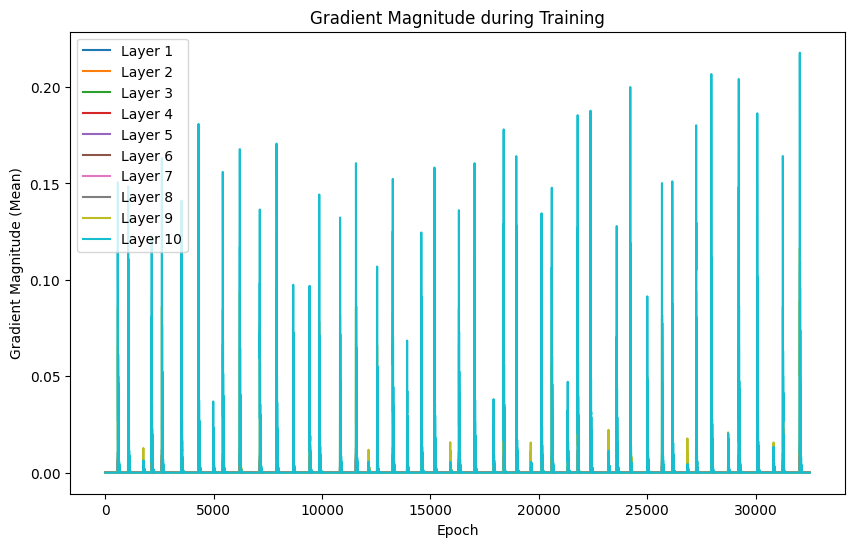

32500 Training Loss: tensor(2.3582e-06)
32501 Training Loss: tensor(2.3583e-06)
32502 Training Loss: tensor(2.3582e-06)
32503 Training Loss: tensor(2.3582e-06)
32504 Training Loss: tensor(2.3583e-06)
32505 Training Loss: tensor(2.3582e-06)
32506 Training Loss: tensor(2.3581e-06)
32507 Training Loss: tensor(2.3582e-06)
32508 Training Loss: tensor(2.3580e-06)
32509 Training Loss: tensor(2.3581e-06)
32510 Training Loss: tensor(2.3580e-06)
32511 Training Loss: tensor(2.3579e-06)
32512 Training Loss: tensor(2.3580e-06)
32513 Training Loss: tensor(2.3581e-06)
32514 Training Loss: tensor(2.3580e-06)
32515 Training Loss: tensor(2.3580e-06)
32516 Training Loss: tensor(2.3581e-06)
32517 Training Loss: tensor(2.3581e-06)
32518 Training Loss: tensor(2.3581e-06)
32519 Training Loss: tensor(2.3580e-06)
32520 Training Loss: tensor(2.3581e-06)
32521 Training Loss: tensor(2.3580e-06)
32522 Training Loss: tensor(2.3579e-06)
32523 Training Loss: tensor(2.3579e-06)
32524 Training Loss: tensor(2.3579e-06)


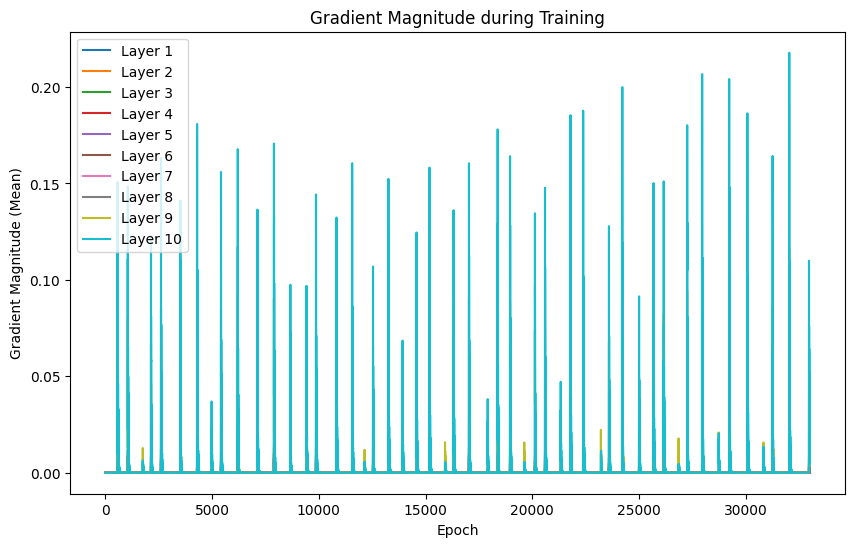

33000 Training Loss: tensor(6.2747e-06)
33001 Training Loss: tensor(7.5967e-06)
33002 Training Loss: tensor(4.6058e-06)
33003 Training Loss: tensor(5.1859e-06)
33004 Training Loss: tensor(5.6401e-06)
33005 Training Loss: tensor(4.9037e-06)
33006 Training Loss: tensor(3.2730e-06)
33007 Training Loss: tensor(6.0331e-06)
33008 Training Loss: tensor(2.9440e-06)
33009 Training Loss: tensor(4.1284e-06)
33010 Training Loss: tensor(4.2429e-06)
33011 Training Loss: tensor(3.2196e-06)
33012 Training Loss: tensor(3.5676e-06)
33013 Training Loss: tensor(3.5334e-06)
33014 Training Loss: tensor(3.3808e-06)
33015 Training Loss: tensor(2.7439e-06)
33016 Training Loss: tensor(3.7256e-06)
33017 Training Loss: tensor(2.6430e-06)
33018 Training Loss: tensor(3.0004e-06)
33019 Training Loss: tensor(3.1176e-06)
33020 Training Loss: tensor(2.6835e-06)
33021 Training Loss: tensor(2.8103e-06)
33022 Training Loss: tensor(2.8485e-06)
33023 Training Loss: tensor(2.7114e-06)
33024 Training Loss: tensor(2.5402e-06)


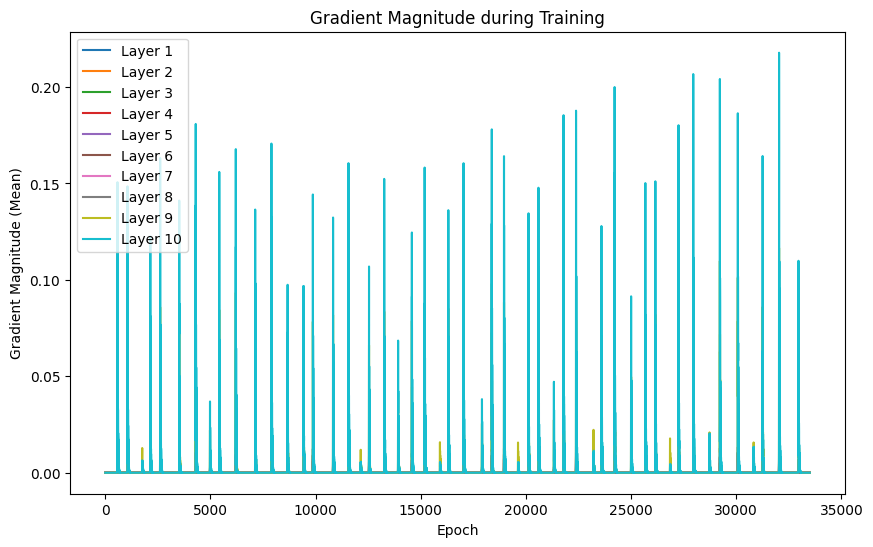

33500 Training Loss: tensor(2.3482e-06)
33501 Training Loss: tensor(2.3481e-06)
33502 Training Loss: tensor(2.3482e-06)
33503 Training Loss: tensor(2.3481e-06)
33504 Training Loss: tensor(2.3481e-06)
33505 Training Loss: tensor(2.3480e-06)
33506 Training Loss: tensor(2.3481e-06)
33507 Training Loss: tensor(2.3482e-06)
33508 Training Loss: tensor(2.3481e-06)
33509 Training Loss: tensor(2.3482e-06)
33510 Training Loss: tensor(2.3481e-06)
33511 Training Loss: tensor(2.3481e-06)
33512 Training Loss: tensor(2.3482e-06)
33513 Training Loss: tensor(2.3482e-06)
33514 Training Loss: tensor(2.3482e-06)
33515 Training Loss: tensor(2.3481e-06)
33516 Training Loss: tensor(2.3482e-06)
33517 Training Loss: tensor(2.3481e-06)
33518 Training Loss: tensor(2.3481e-06)
33519 Training Loss: tensor(2.3482e-06)
33520 Training Loss: tensor(2.3481e-06)
33521 Training Loss: tensor(2.3481e-06)
33522 Training Loss: tensor(2.3482e-06)
33523 Training Loss: tensor(2.3481e-06)
33524 Training Loss: tensor(2.3480e-06)


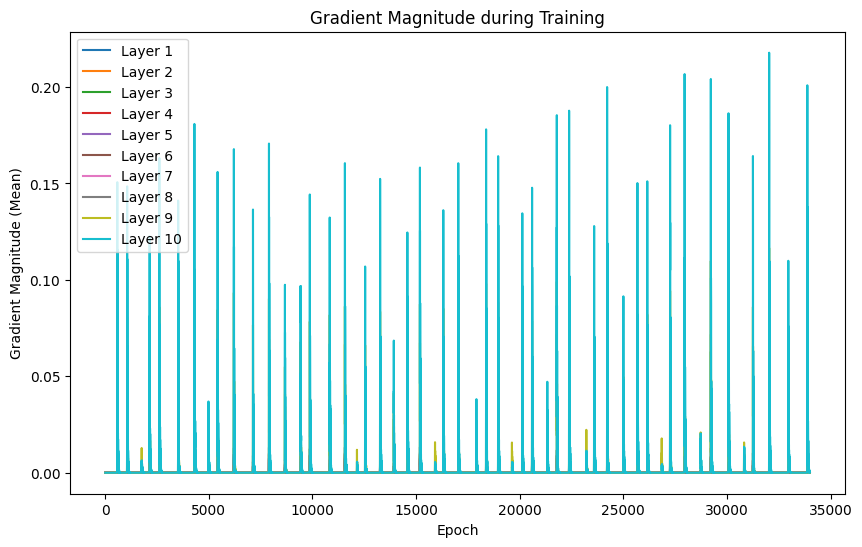

34000 Training Loss: tensor(2.3487e-06)
34001 Training Loss: tensor(2.3459e-06)
34002 Training Loss: tensor(2.3473e-06)
34003 Training Loss: tensor(2.3465e-06)
34004 Training Loss: tensor(2.3460e-06)
34005 Training Loss: tensor(2.3471e-06)
34006 Training Loss: tensor(2.3453e-06)
34007 Training Loss: tensor(2.3471e-06)
34008 Training Loss: tensor(2.3450e-06)
34009 Training Loss: tensor(2.3465e-06)
34010 Training Loss: tensor(2.3453e-06)
34011 Training Loss: tensor(2.3458e-06)
34012 Training Loss: tensor(2.3456e-06)
34013 Training Loss: tensor(2.3453e-06)
34014 Training Loss: tensor(2.3458e-06)
34015 Training Loss: tensor(2.3450e-06)
34016 Training Loss: tensor(2.3456e-06)
34017 Training Loss: tensor(2.3450e-06)
34018 Training Loss: tensor(2.3455e-06)
34019 Training Loss: tensor(2.3449e-06)
34020 Training Loss: tensor(2.3451e-06)
34021 Training Loss: tensor(2.3450e-06)
34022 Training Loss: tensor(2.3450e-06)
34023 Training Loss: tensor(2.3451e-06)
34024 Training Loss: tensor(2.3448e-06)


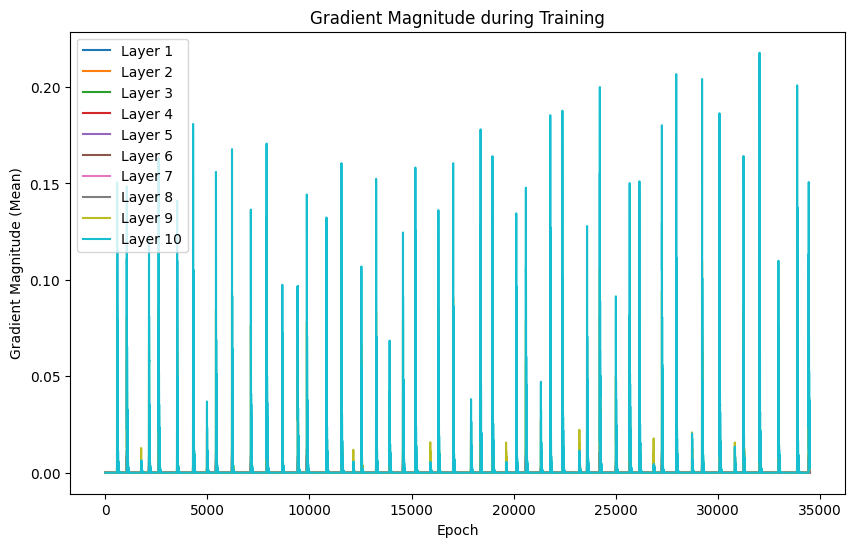

34500 Training Loss: tensor(4.8765e-06)
34501 Training Loss: tensor(2.8751e-06)
34502 Training Loss: tensor(5.2317e-06)
34503 Training Loss: tensor(2.6280e-06)
34504 Training Loss: tensor(4.2304e-06)
34505 Training Loss: tensor(3.3933e-06)
34506 Training Loss: tensor(2.9701e-06)
34507 Training Loss: tensor(3.9280e-06)
34508 Training Loss: tensor(2.4488e-06)
34509 Training Loss: tensor(3.6571e-06)
34510 Training Loss: tensor(2.7142e-06)
34511 Training Loss: tensor(2.9428e-06)
34512 Training Loss: tensor(3.1349e-06)
34513 Training Loss: tensor(2.4482e-06)
34514 Training Loss: tensor(3.1750e-06)
34515 Training Loss: tensor(2.4491e-06)
34516 Training Loss: tensor(2.8292e-06)
34517 Training Loss: tensor(2.7084e-06)
34518 Training Loss: tensor(2.4621e-06)
34519 Training Loss: tensor(2.8346e-06)
34520 Training Loss: tensor(2.3677e-06)
34521 Training Loss: tensor(2.6909e-06)
34522 Training Loss: tensor(2.5003e-06)
34523 Training Loss: tensor(2.4564e-06)
34524 Training Loss: tensor(2.6169e-06)


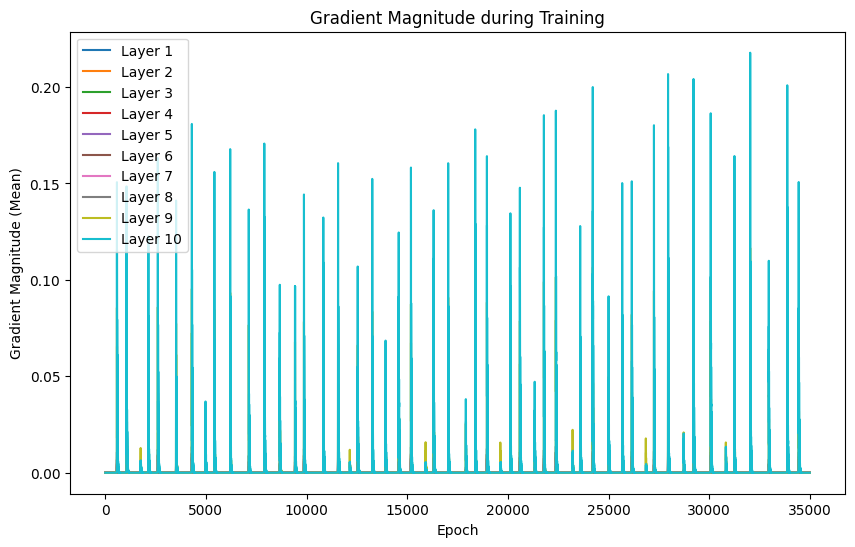

35000 Training Loss: tensor(2.3368e-06)
35001 Training Loss: tensor(2.3368e-06)
35002 Training Loss: tensor(2.3367e-06)
35003 Training Loss: tensor(2.3367e-06)
35004 Training Loss: tensor(2.3367e-06)
35005 Training Loss: tensor(2.3367e-06)
35006 Training Loss: tensor(2.3366e-06)
35007 Training Loss: tensor(2.3365e-06)
35008 Training Loss: tensor(2.3367e-06)
35009 Training Loss: tensor(2.3366e-06)
35010 Training Loss: tensor(2.3366e-06)
35011 Training Loss: tensor(2.3366e-06)
35012 Training Loss: tensor(2.3366e-06)
35013 Training Loss: tensor(2.3365e-06)
35014 Training Loss: tensor(2.3366e-06)
35015 Training Loss: tensor(2.3366e-06)
35016 Training Loss: tensor(2.3366e-06)
35017 Training Loss: tensor(2.3366e-06)
35018 Training Loss: tensor(2.3366e-06)
35019 Training Loss: tensor(2.3366e-06)
35020 Training Loss: tensor(2.3366e-06)
35021 Training Loss: tensor(2.3366e-06)
35022 Training Loss: tensor(2.3365e-06)
35023 Training Loss: tensor(2.3365e-06)
35024 Training Loss: tensor(2.3365e-06)


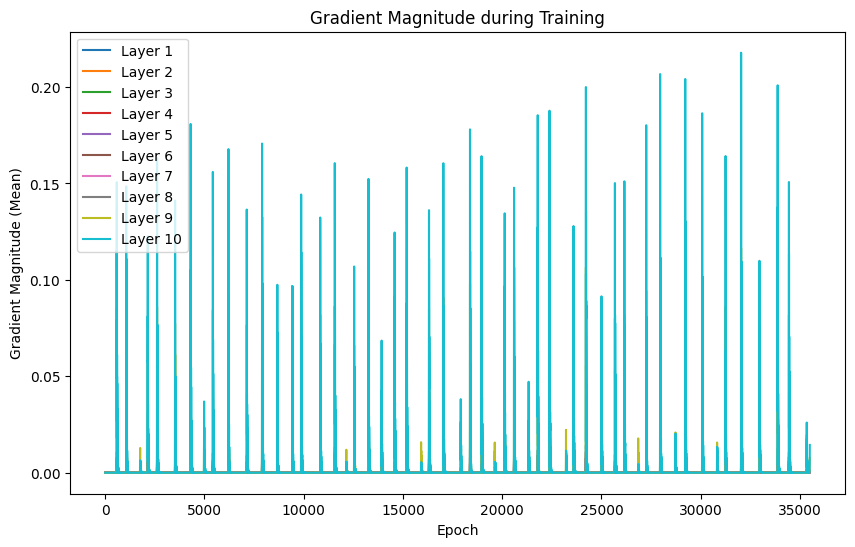

35500 Training Loss: tensor(1.3709e-05)
35501 Training Loss: tensor(1.9692e-05)
35502 Training Loss: tensor(2.8492e-05)
35503 Training Loss: tensor(4.0470e-05)
35504 Training Loss: tensor(5.5628e-05)
35505 Training Loss: tensor(7.1018e-05)
35506 Training Loss: tensor(8.2026e-05)
35507 Training Loss: tensor(8.0167e-05)
35508 Training Loss: tensor(6.2779e-05)
35509 Training Loss: tensor(3.4623e-05)
35510 Training Loss: tensor(1.0570e-05)
35511 Training Loss: tensor(2.3606e-06)
35512 Training Loss: tensor(1.0567e-05)
35513 Training Loss: tensor(2.5371e-05)
35514 Training Loss: tensor(3.4254e-05)
35515 Training Loss: tensor(3.0756e-05)
35516 Training Loss: tensor(1.7801e-05)
35517 Training Loss: tensor(5.7026e-06)
35518 Training Loss: tensor(2.5361e-06)
35519 Training Loss: tensor(8.1633e-06)
35520 Training Loss: tensor(1.5729e-05)
35521 Training Loss: tensor(1.8102e-05)
35522 Training Loss: tensor(1.3655e-05)
35523 Training Loss: tensor(6.5089e-06)
35524 Training Loss: tensor(2.4788e-06)


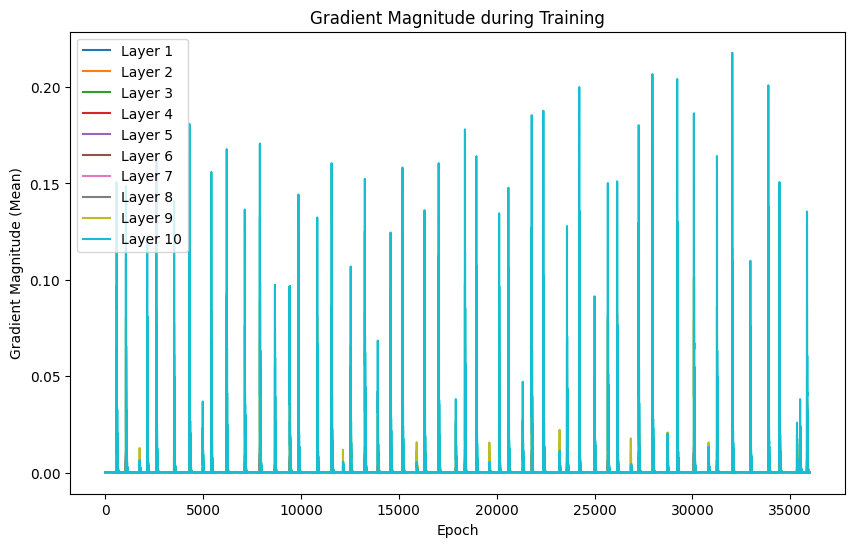

36000 Training Loss: tensor(2.3278e-06)
36001 Training Loss: tensor(2.3277e-06)
36002 Training Loss: tensor(2.3277e-06)
36003 Training Loss: tensor(2.3276e-06)
36004 Training Loss: tensor(2.3278e-06)
36005 Training Loss: tensor(2.3277e-06)
36006 Training Loss: tensor(2.3277e-06)
36007 Training Loss: tensor(2.3277e-06)
36008 Training Loss: tensor(2.3277e-06)
36009 Training Loss: tensor(2.3276e-06)
36010 Training Loss: tensor(2.3276e-06)
36011 Training Loss: tensor(2.3277e-06)
36012 Training Loss: tensor(2.3275e-06)
36013 Training Loss: tensor(2.3275e-06)
36014 Training Loss: tensor(2.3276e-06)
36015 Training Loss: tensor(2.3276e-06)
36016 Training Loss: tensor(2.3276e-06)
36017 Training Loss: tensor(2.3276e-06)
36018 Training Loss: tensor(2.3277e-06)
36019 Training Loss: tensor(2.3275e-06)
36020 Training Loss: tensor(2.3275e-06)
36021 Training Loss: tensor(2.3274e-06)
36022 Training Loss: tensor(2.3275e-06)
36023 Training Loss: tensor(2.3275e-06)
36024 Training Loss: tensor(2.3275e-06)


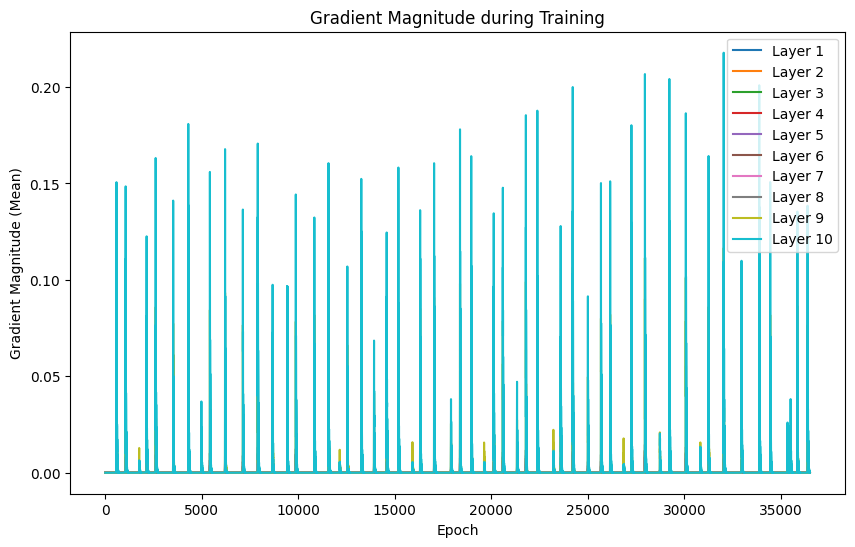

36500 Training Loss: tensor(2.3300e-06)
36501 Training Loss: tensor(2.3264e-06)
36502 Training Loss: tensor(2.3277e-06)
36503 Training Loss: tensor(2.3279e-06)
36504 Training Loss: tensor(2.3259e-06)
36505 Training Loss: tensor(2.3281e-06)
36506 Training Loss: tensor(2.3256e-06)
36507 Training Loss: tensor(2.3273e-06)
36508 Training Loss: tensor(2.3263e-06)
36509 Training Loss: tensor(2.3261e-06)
36510 Training Loss: tensor(2.3269e-06)
36511 Training Loss: tensor(2.3254e-06)
36512 Training Loss: tensor(2.3267e-06)
36513 Training Loss: tensor(2.3256e-06)
36514 Training Loss: tensor(2.3259e-06)
36515 Training Loss: tensor(2.3259e-06)
36516 Training Loss: tensor(2.3254e-06)
36517 Training Loss: tensor(2.3260e-06)
36518 Training Loss: tensor(2.3254e-06)
36519 Training Loss: tensor(2.3255e-06)
36520 Training Loss: tensor(2.3256e-06)
36521 Training Loss: tensor(2.3254e-06)
36522 Training Loss: tensor(2.3254e-06)
36523 Training Loss: tensor(2.3252e-06)
36524 Training Loss: tensor(2.3255e-06)


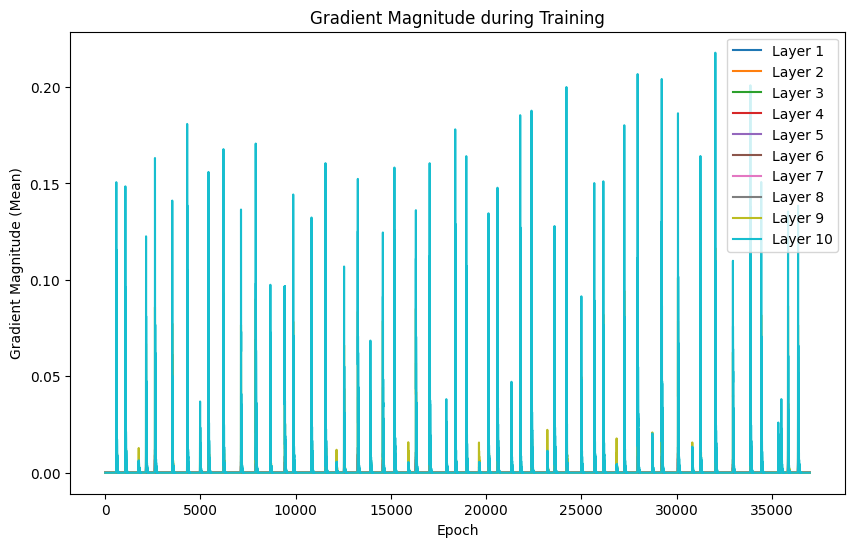

37000 Training Loss: tensor(2.3199e-06)
37001 Training Loss: tensor(2.3199e-06)
37002 Training Loss: tensor(2.3198e-06)
37003 Training Loss: tensor(2.3197e-06)
37004 Training Loss: tensor(2.3196e-06)
37005 Training Loss: tensor(2.3197e-06)
37006 Training Loss: tensor(2.3197e-06)
37007 Training Loss: tensor(2.3197e-06)
37008 Training Loss: tensor(2.3197e-06)
37009 Training Loss: tensor(2.3198e-06)
37010 Training Loss: tensor(2.3196e-06)
37011 Training Loss: tensor(2.3196e-06)
37012 Training Loss: tensor(2.3197e-06)
37013 Training Loss: tensor(2.3197e-06)
37014 Training Loss: tensor(2.3197e-06)
37015 Training Loss: tensor(2.3196e-06)
37016 Training Loss: tensor(2.3197e-06)
37017 Training Loss: tensor(2.3196e-06)
37018 Training Loss: tensor(2.3197e-06)
37019 Training Loss: tensor(2.3197e-06)
37020 Training Loss: tensor(2.3196e-06)
37021 Training Loss: tensor(2.3195e-06)
37022 Training Loss: tensor(2.3195e-06)
37023 Training Loss: tensor(2.3196e-06)
37024 Training Loss: tensor(2.3195e-06)


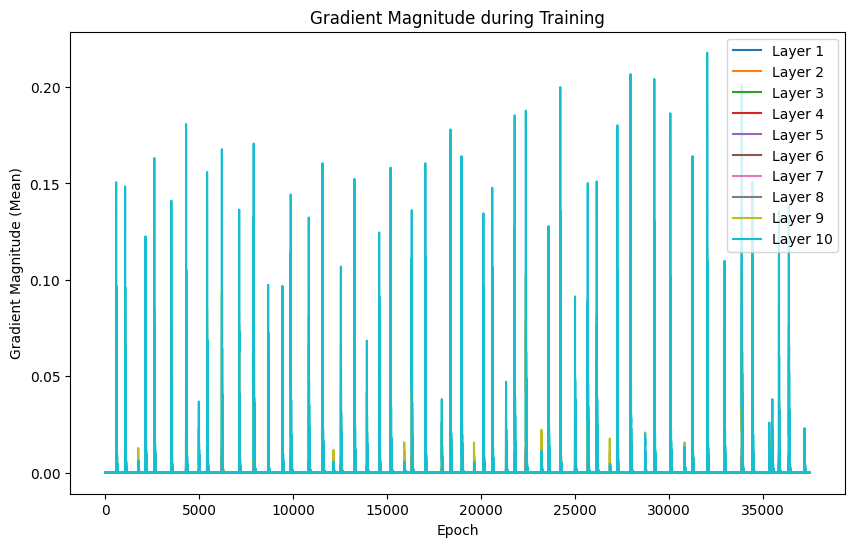

37500 Training Loss: tensor(2.3145e-06)
37501 Training Loss: tensor(2.3145e-06)
37502 Training Loss: tensor(2.3144e-06)
37503 Training Loss: tensor(2.3144e-06)
37504 Training Loss: tensor(2.3144e-06)
37505 Training Loss: tensor(2.3142e-06)
37506 Training Loss: tensor(2.3144e-06)
37507 Training Loss: tensor(2.3144e-06)
37508 Training Loss: tensor(2.3144e-06)
37509 Training Loss: tensor(2.3143e-06)
37510 Training Loss: tensor(2.3143e-06)
37511 Training Loss: tensor(2.3143e-06)
37512 Training Loss: tensor(2.3144e-06)
37513 Training Loss: tensor(2.3144e-06)
37514 Training Loss: tensor(2.3143e-06)
37515 Training Loss: tensor(2.3143e-06)
37516 Training Loss: tensor(2.3142e-06)
37517 Training Loss: tensor(2.3143e-06)
37518 Training Loss: tensor(2.3143e-06)
37519 Training Loss: tensor(2.3142e-06)
37520 Training Loss: tensor(2.3143e-06)
37521 Training Loss: tensor(2.3142e-06)
37522 Training Loss: tensor(2.3141e-06)
37523 Training Loss: tensor(2.3141e-06)
37524 Training Loss: tensor(2.3141e-06)


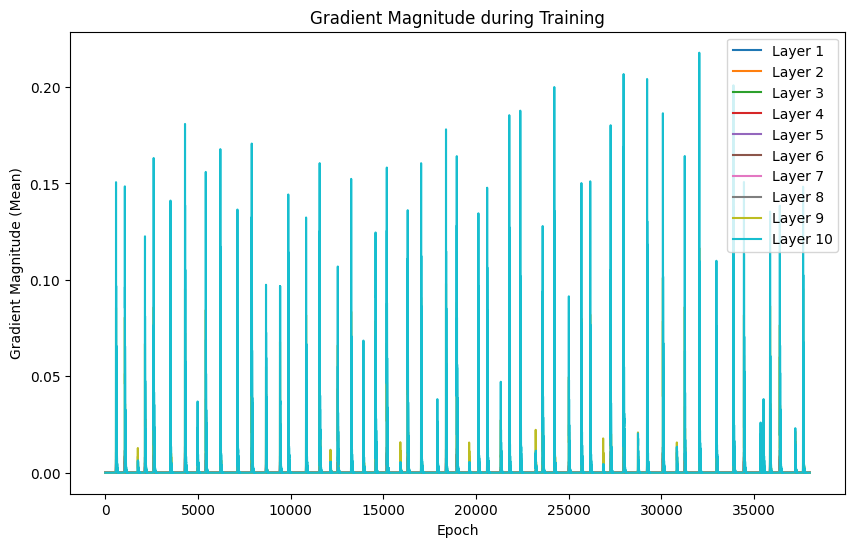

38000 Training Loss: tensor(2.3115e-06)
38001 Training Loss: tensor(2.3115e-06)
38002 Training Loss: tensor(2.3114e-06)
38003 Training Loss: tensor(2.3114e-06)
38004 Training Loss: tensor(2.3115e-06)
38005 Training Loss: tensor(2.3115e-06)
38006 Training Loss: tensor(2.3113e-06)
38007 Training Loss: tensor(2.3114e-06)
38008 Training Loss: tensor(2.3114e-06)
38009 Training Loss: tensor(2.3114e-06)
38010 Training Loss: tensor(2.3113e-06)
38011 Training Loss: tensor(2.3113e-06)
38012 Training Loss: tensor(2.3114e-06)
38013 Training Loss: tensor(2.3114e-06)
38014 Training Loss: tensor(2.3114e-06)
38015 Training Loss: tensor(2.3113e-06)
38016 Training Loss: tensor(2.3114e-06)
38017 Training Loss: tensor(2.3113e-06)
38018 Training Loss: tensor(2.3113e-06)
38019 Training Loss: tensor(2.3114e-06)
38020 Training Loss: tensor(2.3113e-06)
38021 Training Loss: tensor(2.3111e-06)
38022 Training Loss: tensor(2.3112e-06)
38023 Training Loss: tensor(2.3112e-06)
38024 Training Loss: tensor(2.3112e-06)


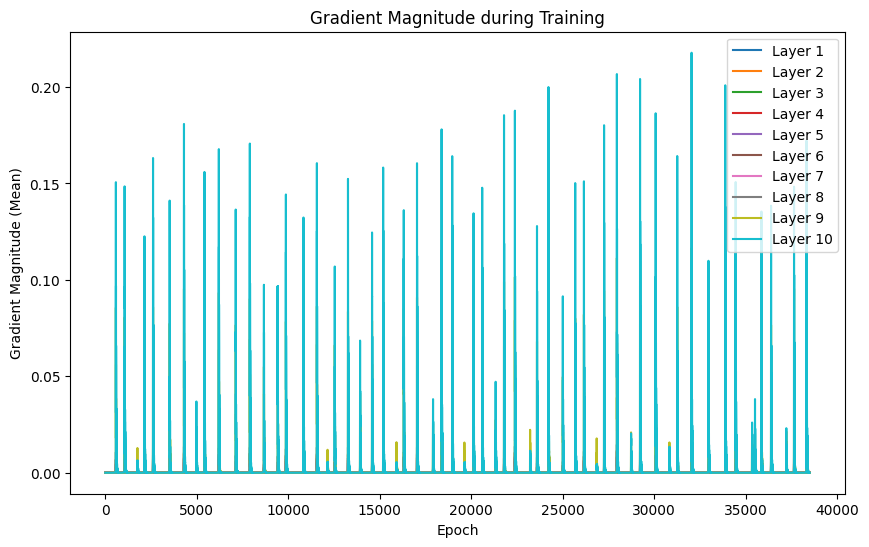

38500 Training Loss: tensor(2.3106e-06)
38501 Training Loss: tensor(2.3105e-06)
38502 Training Loss: tensor(2.3106e-06)
38503 Training Loss: tensor(2.3104e-06)
38504 Training Loss: tensor(2.3105e-06)
38505 Training Loss: tensor(2.3105e-06)
38506 Training Loss: tensor(2.3104e-06)
38507 Training Loss: tensor(2.3103e-06)
38508 Training Loss: tensor(2.3105e-06)
38509 Training Loss: tensor(2.3105e-06)
38510 Training Loss: tensor(2.3103e-06)
38511 Training Loss: tensor(2.3104e-06)
38512 Training Loss: tensor(2.3103e-06)
38513 Training Loss: tensor(2.3104e-06)
38514 Training Loss: tensor(2.3104e-06)
38515 Training Loss: tensor(2.3103e-06)
38516 Training Loss: tensor(2.3103e-06)
38517 Training Loss: tensor(2.3103e-06)
38518 Training Loss: tensor(2.3103e-06)
38519 Training Loss: tensor(2.3103e-06)
38520 Training Loss: tensor(2.3102e-06)
38521 Training Loss: tensor(2.3103e-06)
38522 Training Loss: tensor(2.3102e-06)
38523 Training Loss: tensor(2.3102e-06)
38524 Training Loss: tensor(2.3102e-06)


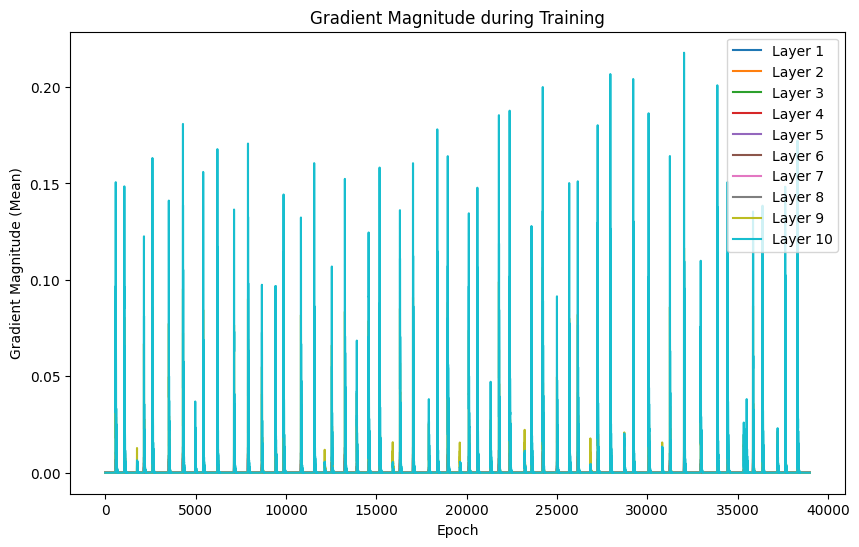

39000 Training Loss: tensor(2.3050e-06)
39001 Training Loss: tensor(2.3050e-06)
39002 Training Loss: tensor(2.3049e-06)
39003 Training Loss: tensor(2.3049e-06)
39004 Training Loss: tensor(2.3048e-06)
39005 Training Loss: tensor(2.3048e-06)
39006 Training Loss: tensor(2.3048e-06)
39007 Training Loss: tensor(2.3048e-06)
39008 Training Loss: tensor(2.3048e-06)
39009 Training Loss: tensor(2.3048e-06)
39010 Training Loss: tensor(2.3048e-06)
39011 Training Loss: tensor(2.3048e-06)
39012 Training Loss: tensor(2.3048e-06)
39013 Training Loss: tensor(2.3047e-06)
39014 Training Loss: tensor(2.3048e-06)
39015 Training Loss: tensor(2.3046e-06)
39016 Training Loss: tensor(2.3047e-06)
39017 Training Loss: tensor(2.3047e-06)
39018 Training Loss: tensor(2.3047e-06)
39019 Training Loss: tensor(2.3048e-06)
39020 Training Loss: tensor(2.3047e-06)
39021 Training Loss: tensor(2.3047e-06)
39022 Training Loss: tensor(2.3047e-06)
39023 Training Loss: tensor(2.3047e-06)
39024 Training Loss: tensor(2.3048e-06)


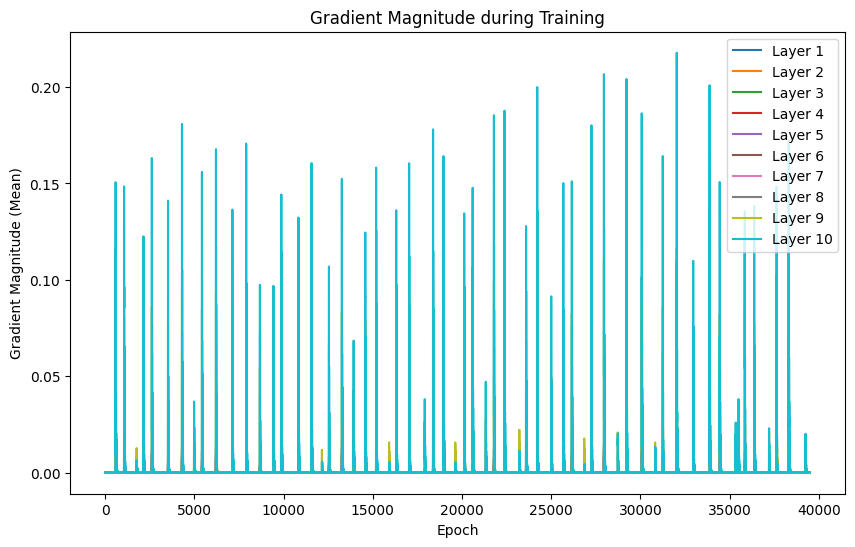

39500 Training Loss: tensor(2.2996e-06)
39501 Training Loss: tensor(2.2996e-06)
39502 Training Loss: tensor(2.2996e-06)
39503 Training Loss: tensor(2.2995e-06)
39504 Training Loss: tensor(2.2995e-06)
39505 Training Loss: tensor(2.2996e-06)
39506 Training Loss: tensor(2.2996e-06)
39507 Training Loss: tensor(2.2995e-06)
39508 Training Loss: tensor(2.2996e-06)
39509 Training Loss: tensor(2.2995e-06)
39510 Training Loss: tensor(2.2994e-06)
39511 Training Loss: tensor(2.2994e-06)
39512 Training Loss: tensor(2.2994e-06)
39513 Training Loss: tensor(2.2996e-06)
39514 Training Loss: tensor(2.2995e-06)
39515 Training Loss: tensor(2.2994e-06)
39516 Training Loss: tensor(2.2993e-06)
39517 Training Loss: tensor(2.2994e-06)
39518 Training Loss: tensor(2.2993e-06)
39519 Training Loss: tensor(2.2993e-06)
39520 Training Loss: tensor(2.2994e-06)
39521 Training Loss: tensor(2.2993e-06)
39522 Training Loss: tensor(2.2993e-06)
39523 Training Loss: tensor(2.2993e-06)
39524 Training Loss: tensor(2.2993e-06)


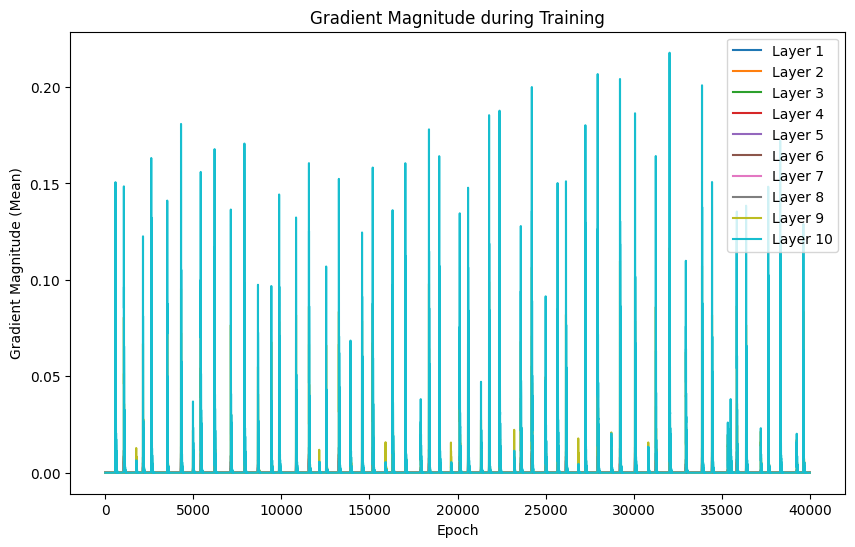

40000 Training Loss: tensor(2.2964e-06)
40001 Training Loss: tensor(2.2964e-06)
40002 Training Loss: tensor(2.2963e-06)
40003 Training Loss: tensor(2.2963e-06)
40004 Training Loss: tensor(2.2964e-06)
40005 Training Loss: tensor(2.2963e-06)
40006 Training Loss: tensor(2.2964e-06)
40007 Training Loss: tensor(2.2963e-06)
40008 Training Loss: tensor(2.2964e-06)
40009 Training Loss: tensor(2.2963e-06)
40010 Training Loss: tensor(2.2964e-06)
40011 Training Loss: tensor(2.2965e-06)
40012 Training Loss: tensor(2.2963e-06)
40013 Training Loss: tensor(2.2963e-06)
40014 Training Loss: tensor(2.2963e-06)
40015 Training Loss: tensor(2.2962e-06)
40016 Training Loss: tensor(2.2962e-06)
40017 Training Loss: tensor(2.2962e-06)
40018 Training Loss: tensor(2.2963e-06)
40019 Training Loss: tensor(2.2963e-06)
40020 Training Loss: tensor(2.2962e-06)
40021 Training Loss: tensor(2.2962e-06)
40022 Training Loss: tensor(2.2962e-06)
40023 Training Loss: tensor(2.2960e-06)
40024 Training Loss: tensor(2.2961e-06)


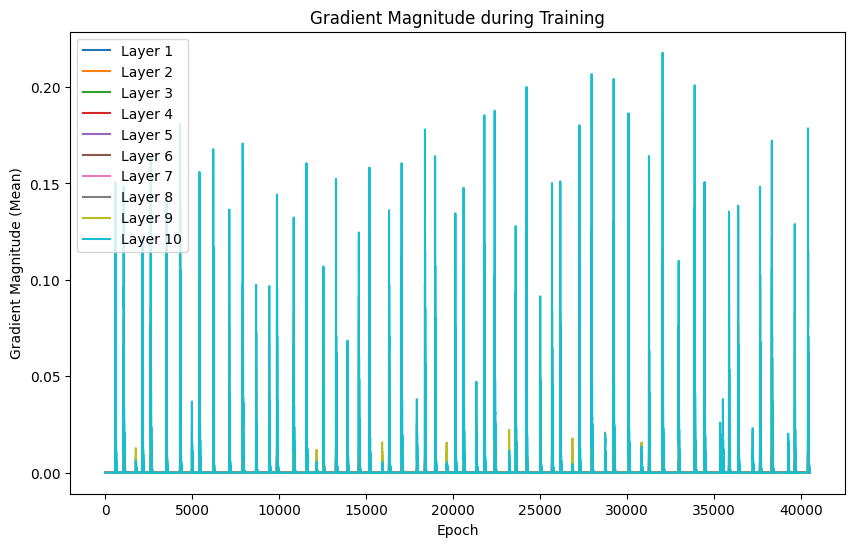

40500 Training Loss: tensor(2.3149e-06)
40501 Training Loss: tensor(2.3045e-06)
40502 Training Loss: tensor(2.3070e-06)
40503 Training Loss: tensor(2.3070e-06)
40504 Training Loss: tensor(2.3016e-06)
40505 Training Loss: tensor(2.3080e-06)
40506 Training Loss: tensor(2.2982e-06)
40507 Training Loss: tensor(2.3076e-06)
40508 Training Loss: tensor(2.2967e-06)
40509 Training Loss: tensor(2.3061e-06)
40510 Training Loss: tensor(2.2966e-06)
40511 Training Loss: tensor(2.3033e-06)
40512 Training Loss: tensor(2.2973e-06)
40513 Training Loss: tensor(2.3008e-06)
40514 Training Loss: tensor(2.2983e-06)
40515 Training Loss: tensor(2.2985e-06)
40516 Training Loss: tensor(2.2987e-06)
40517 Training Loss: tensor(2.2971e-06)
40518 Training Loss: tensor(2.2990e-06)
40519 Training Loss: tensor(2.2963e-06)
40520 Training Loss: tensor(2.2988e-06)
40521 Training Loss: tensor(2.2961e-06)
40522 Training Loss: tensor(2.2981e-06)
40523 Training Loss: tensor(2.2962e-06)
40524 Training Loss: tensor(2.2975e-06)


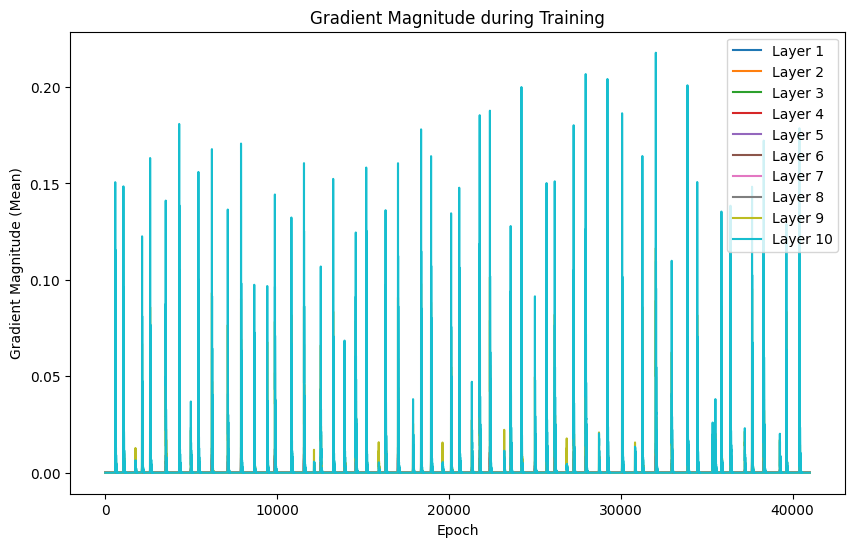

41000 Training Loss: tensor(2.2897e-06)
41001 Training Loss: tensor(2.2897e-06)
41002 Training Loss: tensor(2.2897e-06)
41003 Training Loss: tensor(2.2897e-06)
41004 Training Loss: tensor(2.2897e-06)
41005 Training Loss: tensor(2.2898e-06)
41006 Training Loss: tensor(2.2896e-06)
41007 Training Loss: tensor(2.2895e-06)
41008 Training Loss: tensor(2.2896e-06)
41009 Training Loss: tensor(2.2895e-06)
41010 Training Loss: tensor(2.2896e-06)
41011 Training Loss: tensor(2.2896e-06)
41012 Training Loss: tensor(2.2897e-06)
41013 Training Loss: tensor(2.2896e-06)
41014 Training Loss: tensor(2.2895e-06)
41015 Training Loss: tensor(2.2896e-06)
41016 Training Loss: tensor(2.2895e-06)
41017 Training Loss: tensor(2.2895e-06)
41018 Training Loss: tensor(2.2895e-06)
41019 Training Loss: tensor(2.2895e-06)
41020 Training Loss: tensor(2.2895e-06)
41021 Training Loss: tensor(2.2894e-06)
41022 Training Loss: tensor(2.2894e-06)
41023 Training Loss: tensor(2.2895e-06)
41024 Training Loss: tensor(2.2895e-06)


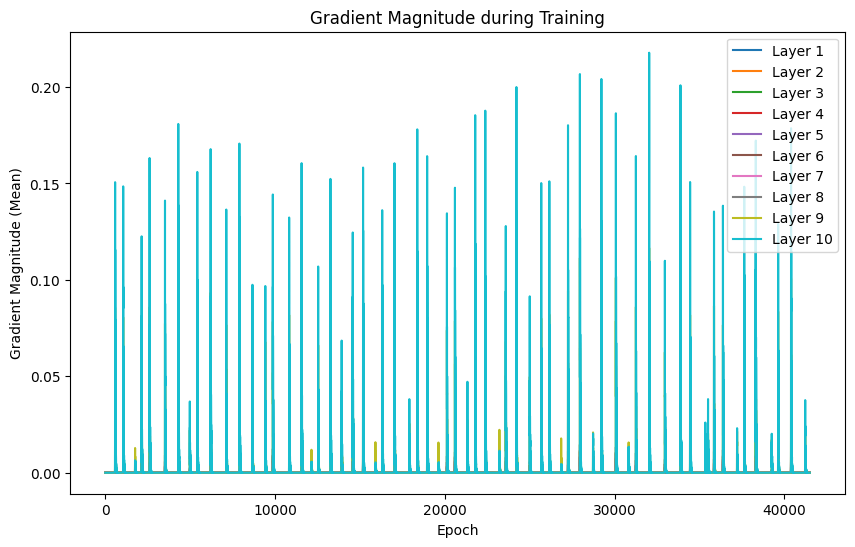

41500 Training Loss: tensor(2.2845e-06)
41501 Training Loss: tensor(2.2846e-06)
41502 Training Loss: tensor(2.2846e-06)
41503 Training Loss: tensor(2.2844e-06)
41504 Training Loss: tensor(2.2846e-06)
41505 Training Loss: tensor(2.2845e-06)
41506 Training Loss: tensor(2.2845e-06)
41507 Training Loss: tensor(2.2845e-06)
41508 Training Loss: tensor(2.2844e-06)
41509 Training Loss: tensor(2.2845e-06)
41510 Training Loss: tensor(2.2845e-06)
41511 Training Loss: tensor(2.2846e-06)
41512 Training Loss: tensor(2.2845e-06)
41513 Training Loss: tensor(2.2845e-06)
41514 Training Loss: tensor(2.2845e-06)
41515 Training Loss: tensor(2.2846e-06)
41516 Training Loss: tensor(2.2845e-06)
41517 Training Loss: tensor(2.2844e-06)
41518 Training Loss: tensor(2.2845e-06)
41519 Training Loss: tensor(2.2843e-06)
41520 Training Loss: tensor(2.2844e-06)
41521 Training Loss: tensor(2.2844e-06)
41522 Training Loss: tensor(2.2843e-06)
41523 Training Loss: tensor(2.2844e-06)
41524 Training Loss: tensor(2.2843e-06)


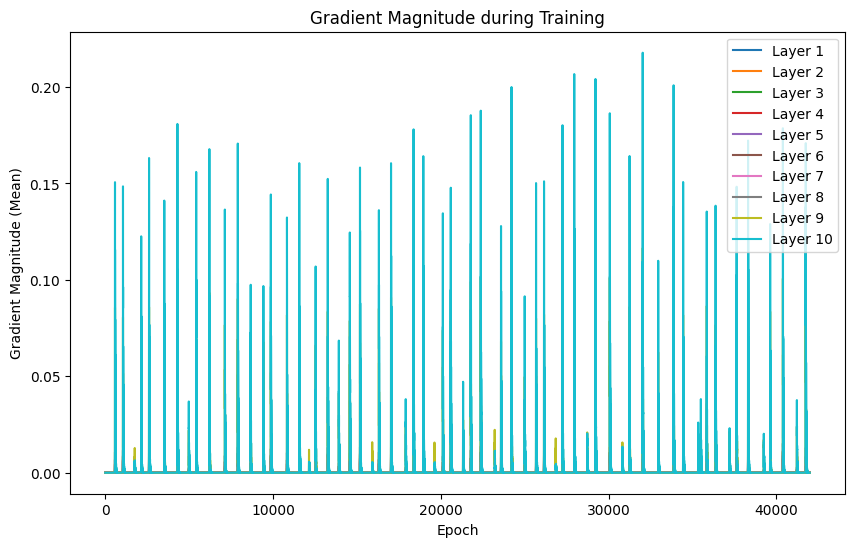

42000 Training Loss: tensor(2.2820e-06)
42001 Training Loss: tensor(2.2821e-06)
42002 Training Loss: tensor(2.2822e-06)
42003 Training Loss: tensor(2.2821e-06)
42004 Training Loss: tensor(2.2822e-06)
42005 Training Loss: tensor(2.2822e-06)
42006 Training Loss: tensor(2.2822e-06)
42007 Training Loss: tensor(2.2821e-06)
42008 Training Loss: tensor(2.2821e-06)
42009 Training Loss: tensor(2.2820e-06)
42010 Training Loss: tensor(2.2821e-06)
42011 Training Loss: tensor(2.2822e-06)
42012 Training Loss: tensor(2.2821e-06)
42013 Training Loss: tensor(2.2820e-06)
42014 Training Loss: tensor(2.2820e-06)
42015 Training Loss: tensor(2.2821e-06)
42016 Training Loss: tensor(2.2821e-06)
42017 Training Loss: tensor(2.2820e-06)
42018 Training Loss: tensor(2.2821e-06)
42019 Training Loss: tensor(2.2821e-06)
42020 Training Loss: tensor(2.2821e-06)
42021 Training Loss: tensor(2.2820e-06)
42022 Training Loss: tensor(2.2819e-06)
42023 Training Loss: tensor(2.2820e-06)
42024 Training Loss: tensor(2.2820e-06)


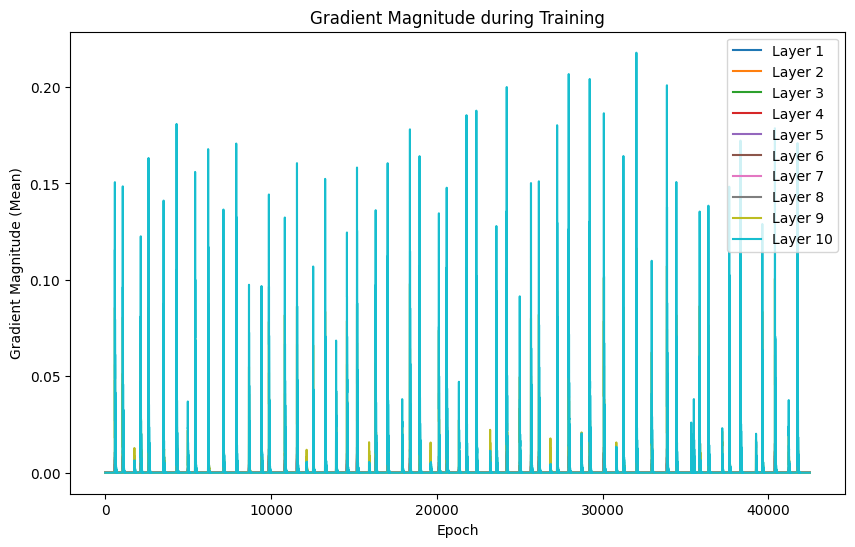

42500 Training Loss: tensor(2.2770e-06)
42501 Training Loss: tensor(2.2768e-06)
42502 Training Loss: tensor(2.2769e-06)
42503 Training Loss: tensor(2.2769e-06)
42504 Training Loss: tensor(2.2767e-06)
42505 Training Loss: tensor(2.2769e-06)
42506 Training Loss: tensor(2.2768e-06)
42507 Training Loss: tensor(2.2768e-06)
42508 Training Loss: tensor(2.2768e-06)
42509 Training Loss: tensor(2.2767e-06)
42510 Training Loss: tensor(2.2768e-06)
42511 Training Loss: tensor(2.2768e-06)
42512 Training Loss: tensor(2.2768e-06)
42513 Training Loss: tensor(2.2769e-06)
42514 Training Loss: tensor(2.2767e-06)
42515 Training Loss: tensor(2.2768e-06)
42516 Training Loss: tensor(2.2767e-06)
42517 Training Loss: tensor(2.2767e-06)
42518 Training Loss: tensor(2.2768e-06)
42519 Training Loss: tensor(2.2769e-06)
42520 Training Loss: tensor(2.2767e-06)
42521 Training Loss: tensor(2.2768e-06)
42522 Training Loss: tensor(2.2766e-06)
42523 Training Loss: tensor(2.2767e-06)
42524 Training Loss: tensor(2.2767e-06)


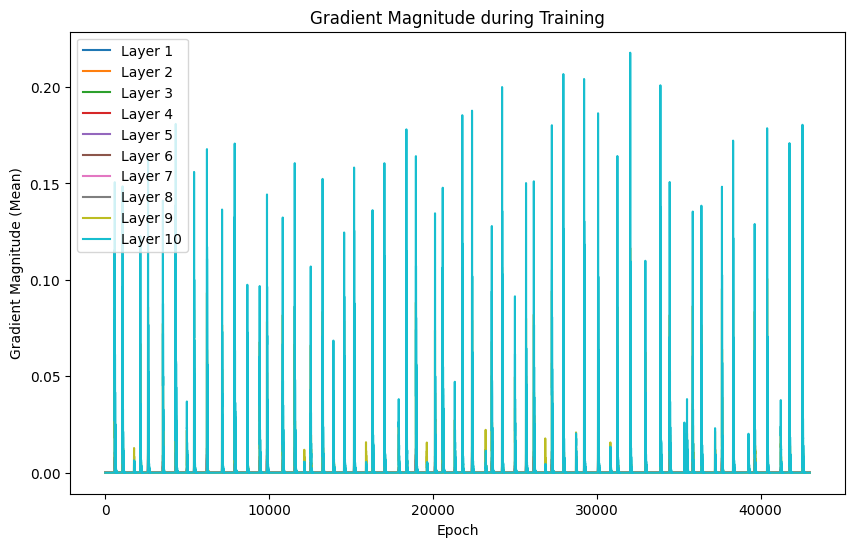

43000 Training Loss: tensor(2.2749e-06)
43001 Training Loss: tensor(2.2749e-06)
43002 Training Loss: tensor(2.2749e-06)
43003 Training Loss: tensor(2.2749e-06)
43004 Training Loss: tensor(2.2749e-06)
43005 Training Loss: tensor(2.2749e-06)
43006 Training Loss: tensor(2.2749e-06)
43007 Training Loss: tensor(2.2750e-06)
43008 Training Loss: tensor(2.2748e-06)
43009 Training Loss: tensor(2.2748e-06)
43010 Training Loss: tensor(2.2749e-06)
43011 Training Loss: tensor(2.2748e-06)
43012 Training Loss: tensor(2.2746e-06)
43013 Training Loss: tensor(2.2746e-06)
43014 Training Loss: tensor(2.2746e-06)
43015 Training Loss: tensor(2.2747e-06)
43016 Training Loss: tensor(2.2747e-06)
43017 Training Loss: tensor(2.2747e-06)
43018 Training Loss: tensor(2.2748e-06)
43019 Training Loss: tensor(2.2746e-06)
43020 Training Loss: tensor(2.2746e-06)
43021 Training Loss: tensor(2.2746e-06)
43022 Training Loss: tensor(2.2747e-06)
43023 Training Loss: tensor(2.2746e-06)
43024 Training Loss: tensor(2.2747e-06)


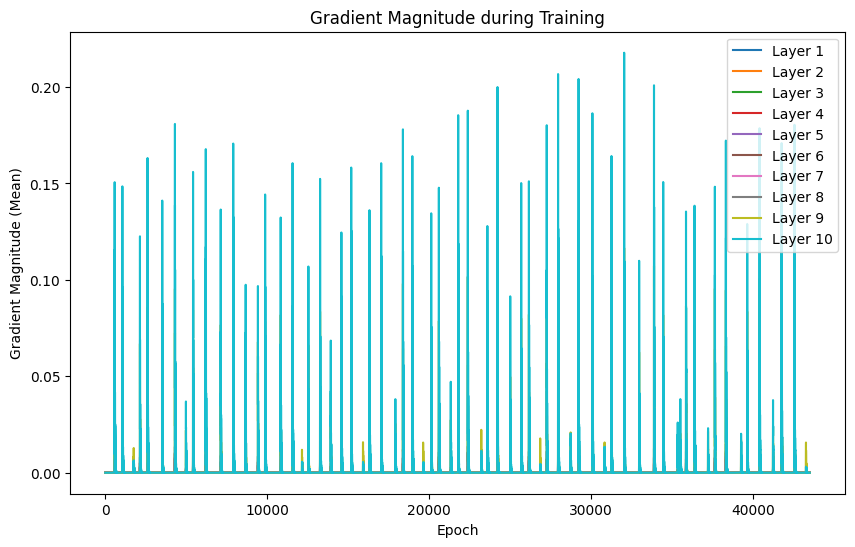

43500 Training Loss: tensor(2.2697e-06)
43501 Training Loss: tensor(2.2698e-06)
43502 Training Loss: tensor(2.2697e-06)
43503 Training Loss: tensor(2.2697e-06)
43504 Training Loss: tensor(2.2696e-06)
43505 Training Loss: tensor(2.2697e-06)
43506 Training Loss: tensor(2.2697e-06)
43507 Training Loss: tensor(2.2695e-06)
43508 Training Loss: tensor(2.2696e-06)
43509 Training Loss: tensor(2.2695e-06)
43510 Training Loss: tensor(2.2697e-06)
43511 Training Loss: tensor(2.2697e-06)
43512 Training Loss: tensor(2.2696e-06)
43513 Training Loss: tensor(2.2696e-06)
43514 Training Loss: tensor(2.2697e-06)
43515 Training Loss: tensor(2.2697e-06)
43516 Training Loss: tensor(2.2696e-06)
43517 Training Loss: tensor(2.2696e-06)
43518 Training Loss: tensor(2.2697e-06)
43519 Training Loss: tensor(2.2698e-06)
43520 Training Loss: tensor(2.2696e-06)
43521 Training Loss: tensor(2.2695e-06)
43522 Training Loss: tensor(2.2695e-06)
43523 Training Loss: tensor(2.2696e-06)
43524 Training Loss: tensor(2.2696e-06)


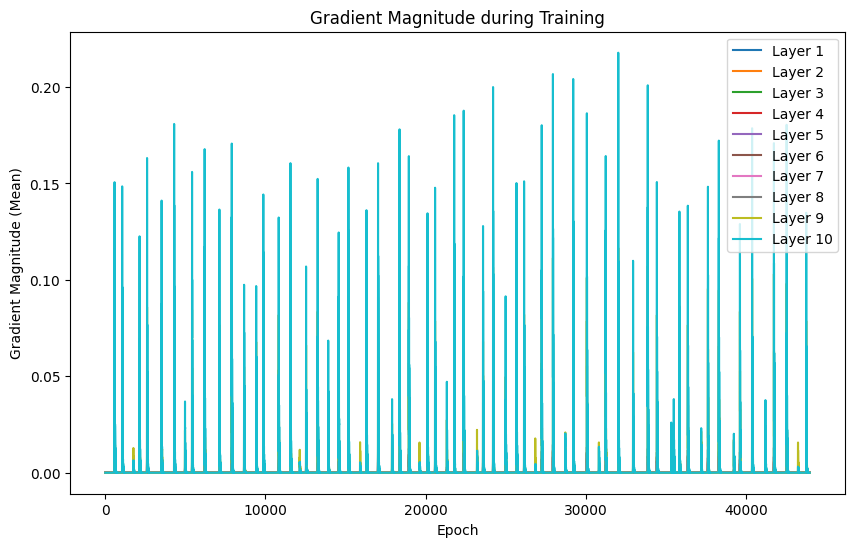

44000 Training Loss: tensor(2.2663e-06)
44001 Training Loss: tensor(2.2663e-06)
44002 Training Loss: tensor(2.2663e-06)
44003 Training Loss: tensor(2.2663e-06)
44004 Training Loss: tensor(2.2663e-06)
44005 Training Loss: tensor(2.2662e-06)
44006 Training Loss: tensor(2.2662e-06)
44007 Training Loss: tensor(2.2660e-06)
44008 Training Loss: tensor(2.2661e-06)
44009 Training Loss: tensor(2.2661e-06)
44010 Training Loss: tensor(2.2662e-06)
44011 Training Loss: tensor(2.2663e-06)
44012 Training Loss: tensor(2.2662e-06)
44013 Training Loss: tensor(2.2661e-06)
44014 Training Loss: tensor(2.2660e-06)
44015 Training Loss: tensor(2.2662e-06)
44016 Training Loss: tensor(2.2662e-06)
44017 Training Loss: tensor(2.2663e-06)
44018 Training Loss: tensor(2.2664e-06)
44019 Training Loss: tensor(2.2661e-06)
44020 Training Loss: tensor(2.2661e-06)
44021 Training Loss: tensor(2.2661e-06)
44022 Training Loss: tensor(2.2660e-06)
44023 Training Loss: tensor(2.2661e-06)
44024 Training Loss: tensor(2.2661e-06)


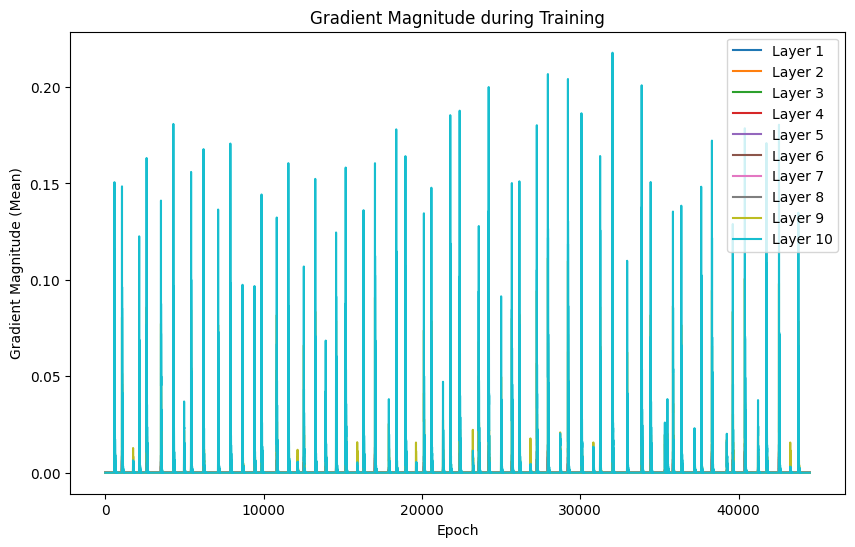

44500 Training Loss: tensor(2.2613e-06)
44501 Training Loss: tensor(2.2614e-06)
44502 Training Loss: tensor(2.2614e-06)
44503 Training Loss: tensor(2.2613e-06)
44504 Training Loss: tensor(2.2613e-06)
44505 Training Loss: tensor(2.2613e-06)
44506 Training Loss: tensor(2.2612e-06)
44507 Training Loss: tensor(2.2613e-06)
44508 Training Loss: tensor(2.2613e-06)
44509 Training Loss: tensor(2.2612e-06)
44510 Training Loss: tensor(2.2612e-06)
44511 Training Loss: tensor(2.2612e-06)
44512 Training Loss: tensor(2.2611e-06)
44513 Training Loss: tensor(2.2611e-06)
44514 Training Loss: tensor(2.2612e-06)
44515 Training Loss: tensor(2.2612e-06)
44516 Training Loss: tensor(2.2610e-06)
44517 Training Loss: tensor(2.2610e-06)
44518 Training Loss: tensor(2.2611e-06)
44519 Training Loss: tensor(2.2610e-06)
44520 Training Loss: tensor(2.2610e-06)
44521 Training Loss: tensor(2.2610e-06)
44522 Training Loss: tensor(2.2610e-06)
44523 Training Loss: tensor(2.2609e-06)
44524 Training Loss: tensor(2.2610e-06)


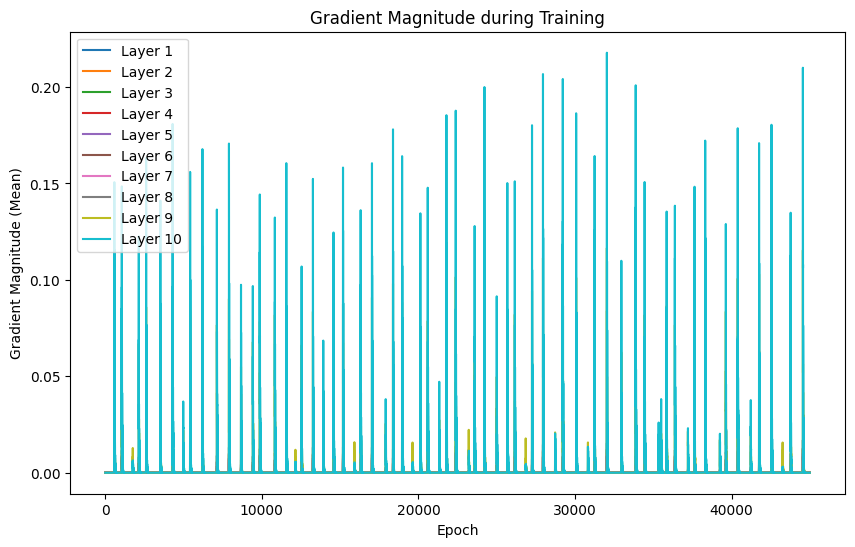

45000 Training Loss: tensor(2.2606e-06)
45001 Training Loss: tensor(2.2605e-06)
45002 Training Loss: tensor(2.2604e-06)
45003 Training Loss: tensor(2.2604e-06)
45004 Training Loss: tensor(2.2603e-06)
45005 Training Loss: tensor(2.2605e-06)
45006 Training Loss: tensor(2.2603e-06)
45007 Training Loss: tensor(2.2605e-06)
45008 Training Loss: tensor(2.2605e-06)
45009 Training Loss: tensor(2.2604e-06)
45010 Training Loss: tensor(2.2604e-06)
45011 Training Loss: tensor(2.2603e-06)
45012 Training Loss: tensor(2.2603e-06)
45013 Training Loss: tensor(2.2603e-06)
45014 Training Loss: tensor(2.2603e-06)
45015 Training Loss: tensor(2.2603e-06)
45016 Training Loss: tensor(2.2603e-06)
45017 Training Loss: tensor(2.2602e-06)
45018 Training Loss: tensor(2.2602e-06)
45019 Training Loss: tensor(2.2603e-06)
45020 Training Loss: tensor(2.2602e-06)
45021 Training Loss: tensor(2.2603e-06)
45022 Training Loss: tensor(2.2603e-06)
45023 Training Loss: tensor(2.2602e-06)
45024 Training Loss: tensor(2.2601e-06)


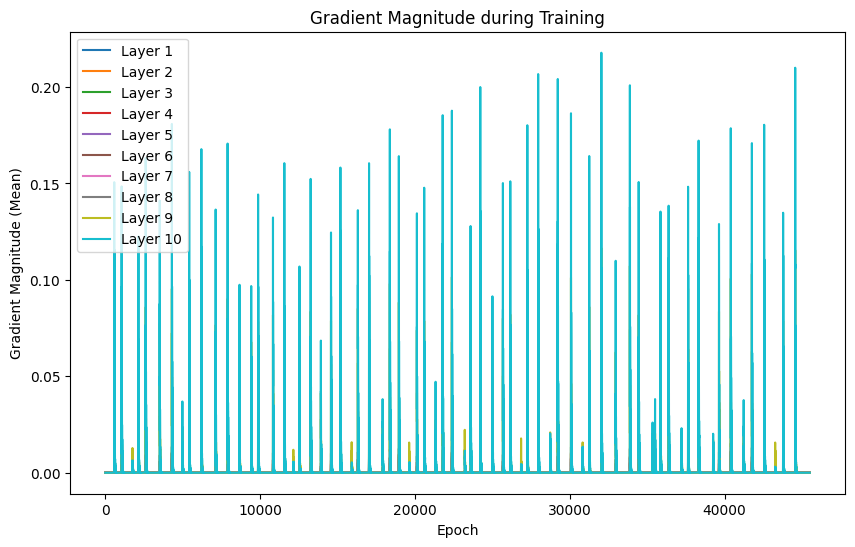

45500 Training Loss: tensor(2.2553e-06)
45501 Training Loss: tensor(2.2553e-06)
45502 Training Loss: tensor(2.2553e-06)
45503 Training Loss: tensor(2.2553e-06)
45504 Training Loss: tensor(2.2552e-06)
45505 Training Loss: tensor(2.2553e-06)
45506 Training Loss: tensor(2.2553e-06)
45507 Training Loss: tensor(2.2553e-06)
45508 Training Loss: tensor(2.2552e-06)
45509 Training Loss: tensor(2.2553e-06)
45510 Training Loss: tensor(2.2553e-06)
45511 Training Loss: tensor(2.2553e-06)
45512 Training Loss: tensor(2.2552e-06)
45513 Training Loss: tensor(2.2552e-06)
45514 Training Loss: tensor(2.2554e-06)
45515 Training Loss: tensor(2.2553e-06)
45516 Training Loss: tensor(2.2553e-06)
45517 Training Loss: tensor(2.2552e-06)
45518 Training Loss: tensor(2.2552e-06)
45519 Training Loss: tensor(2.2552e-06)
45520 Training Loss: tensor(2.2551e-06)
45521 Training Loss: tensor(2.2550e-06)
45522 Training Loss: tensor(2.2550e-06)
45523 Training Loss: tensor(2.2550e-06)
45524 Training Loss: tensor(2.2550e-06)


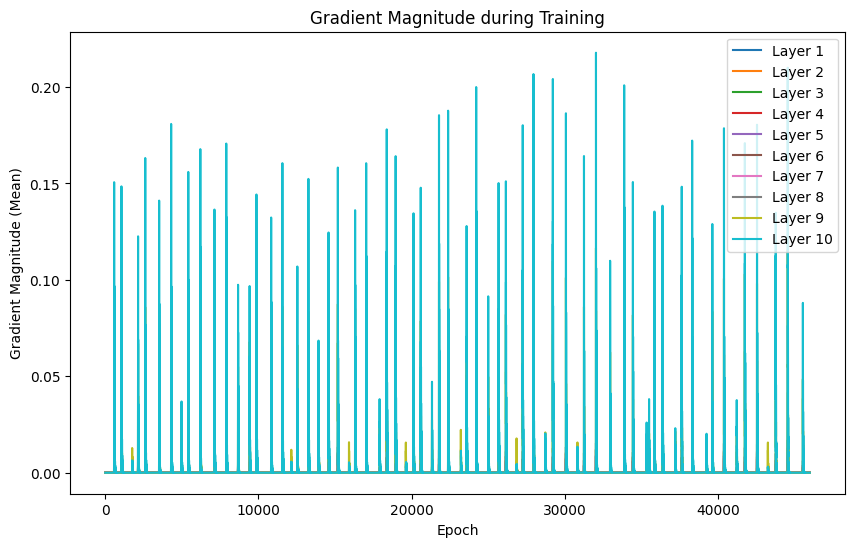

46000 Training Loss: tensor(2.2515e-06)
46001 Training Loss: tensor(2.2515e-06)
46002 Training Loss: tensor(2.2514e-06)
46003 Training Loss: tensor(2.2514e-06)
46004 Training Loss: tensor(2.2514e-06)
46005 Training Loss: tensor(2.2515e-06)
46006 Training Loss: tensor(2.2514e-06)
46007 Training Loss: tensor(2.2514e-06)
46008 Training Loss: tensor(2.2514e-06)
46009 Training Loss: tensor(2.2514e-06)
46010 Training Loss: tensor(2.2514e-06)
46011 Training Loss: tensor(2.2513e-06)
46012 Training Loss: tensor(2.2513e-06)
46013 Training Loss: tensor(2.2513e-06)
46014 Training Loss: tensor(2.2514e-06)
46015 Training Loss: tensor(2.2514e-06)
46016 Training Loss: tensor(2.2514e-06)
46017 Training Loss: tensor(2.2514e-06)
46018 Training Loss: tensor(2.2513e-06)
46019 Training Loss: tensor(2.2515e-06)
46020 Training Loss: tensor(2.2513e-06)
46021 Training Loss: tensor(2.2513e-06)
46022 Training Loss: tensor(2.2513e-06)
46023 Training Loss: tensor(2.2513e-06)
46024 Training Loss: tensor(2.2512e-06)


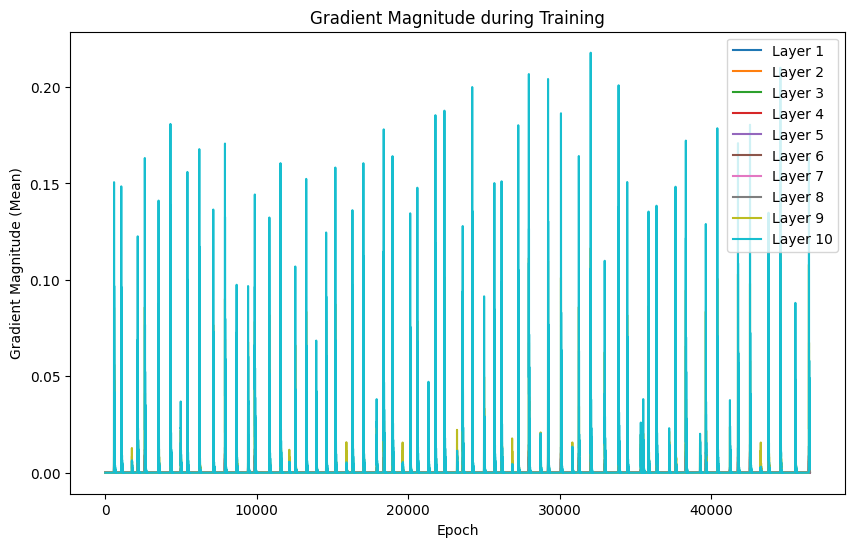

46500 Training Loss: tensor(4.6494e-06)
46501 Training Loss: tensor(2.8066e-06)
46502 Training Loss: tensor(4.4040e-06)
46503 Training Loss: tensor(2.5404e-06)
46504 Training Loss: tensor(4.1311e-06)
46505 Training Loss: tensor(2.3943e-06)
46506 Training Loss: tensor(3.8175e-06)
46507 Training Loss: tensor(2.3531e-06)
46508 Training Loss: tensor(3.5133e-06)
46509 Training Loss: tensor(2.3712e-06)
46510 Training Loss: tensor(3.2114e-06)
46511 Training Loss: tensor(2.4225e-06)
46512 Training Loss: tensor(2.9490e-06)
46513 Training Loss: tensor(2.4813e-06)
46514 Training Loss: tensor(2.7224e-06)
46515 Training Loss: tensor(2.5260e-06)
46516 Training Loss: tensor(2.5483e-06)
46517 Training Loss: tensor(2.5574e-06)
46518 Training Loss: tensor(2.4169e-06)
46519 Training Loss: tensor(2.5637e-06)
46520 Training Loss: tensor(2.3290e-06)
46521 Training Loss: tensor(2.5527e-06)
46522 Training Loss: tensor(2.2785e-06)
46523 Training Loss: tensor(2.5206e-06)
46524 Training Loss: tensor(2.2560e-06)


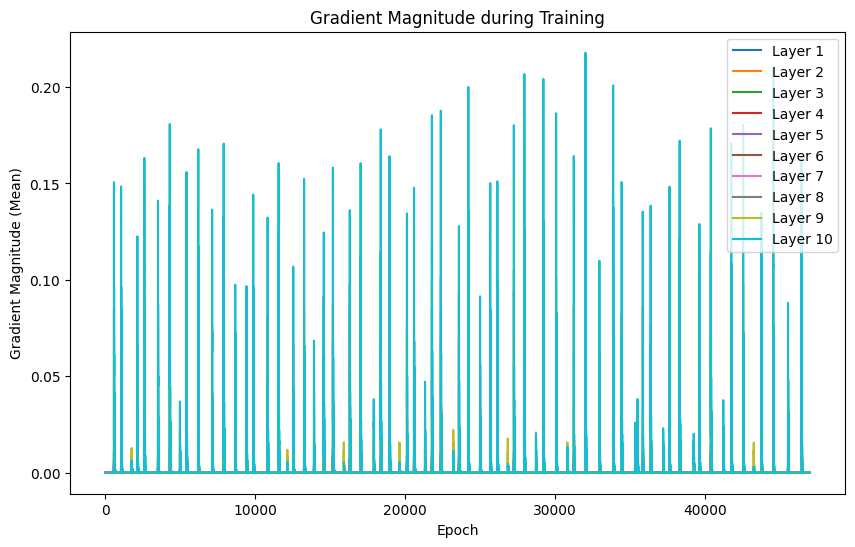

47000 Training Loss: tensor(2.2444e-06)
47001 Training Loss: tensor(2.2442e-06)
47002 Training Loss: tensor(2.2443e-06)
47003 Training Loss: tensor(2.2444e-06)
47004 Training Loss: tensor(2.2442e-06)
47005 Training Loss: tensor(2.2442e-06)
47006 Training Loss: tensor(2.2442e-06)
47007 Training Loss: tensor(2.2441e-06)
47008 Training Loss: tensor(2.2443e-06)
47009 Training Loss: tensor(2.2441e-06)
47010 Training Loss: tensor(2.2442e-06)
47011 Training Loss: tensor(2.2441e-06)
47012 Training Loss: tensor(2.2443e-06)
47013 Training Loss: tensor(2.2442e-06)
47014 Training Loss: tensor(2.2443e-06)
47015 Training Loss: tensor(2.2442e-06)
47016 Training Loss: tensor(2.2443e-06)
47017 Training Loss: tensor(2.2441e-06)
47018 Training Loss: tensor(2.2440e-06)
47019 Training Loss: tensor(2.2441e-06)
47020 Training Loss: tensor(2.2441e-06)
47021 Training Loss: tensor(2.2440e-06)
47022 Training Loss: tensor(2.2440e-06)
47023 Training Loss: tensor(2.2441e-06)
47024 Training Loss: tensor(2.2440e-06)


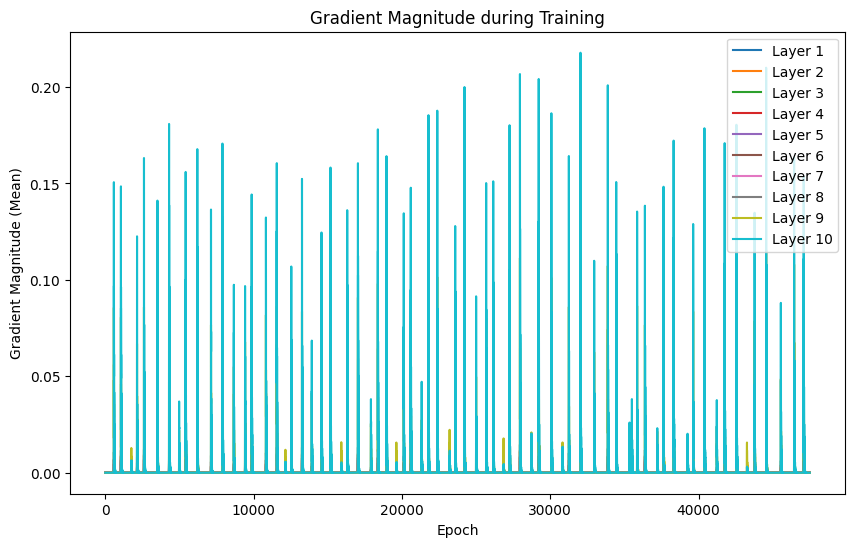

47500 Training Loss: tensor(2.2424e-06)
47501 Training Loss: tensor(2.2423e-06)
47502 Training Loss: tensor(2.2424e-06)
47503 Training Loss: tensor(2.2423e-06)
47504 Training Loss: tensor(2.2423e-06)
47505 Training Loss: tensor(2.2424e-06)
47506 Training Loss: tensor(2.2423e-06)
47507 Training Loss: tensor(2.2424e-06)
47508 Training Loss: tensor(2.2424e-06)
47509 Training Loss: tensor(2.2422e-06)
47510 Training Loss: tensor(2.2423e-06)
47511 Training Loss: tensor(2.2424e-06)
47512 Training Loss: tensor(2.2422e-06)
47513 Training Loss: tensor(2.2422e-06)
47514 Training Loss: tensor(2.2422e-06)
47515 Training Loss: tensor(2.2422e-06)
47516 Training Loss: tensor(2.2421e-06)
47517 Training Loss: tensor(2.2422e-06)
47518 Training Loss: tensor(2.2422e-06)
47519 Training Loss: tensor(2.2422e-06)
47520 Training Loss: tensor(2.2423e-06)
47521 Training Loss: tensor(2.2421e-06)
47522 Training Loss: tensor(2.2422e-06)
47523 Training Loss: tensor(2.2421e-06)
47524 Training Loss: tensor(2.2422e-06)


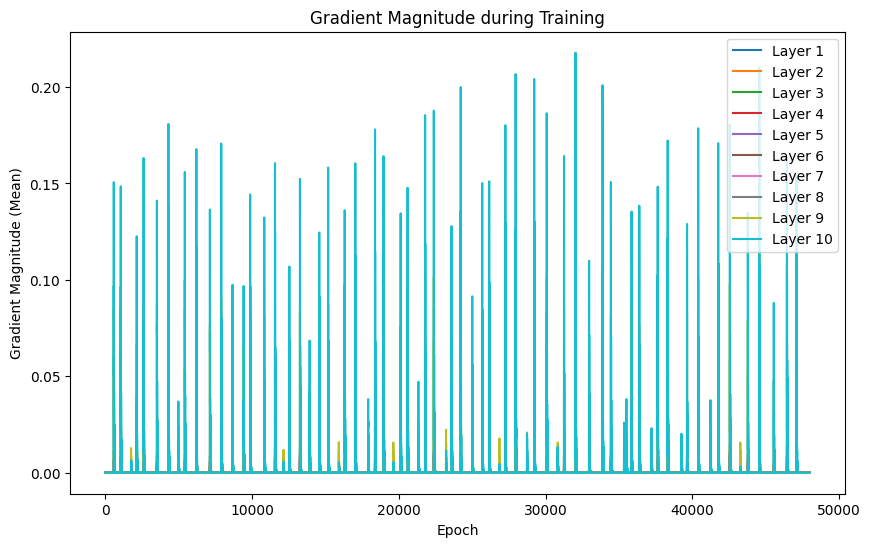

48000 Training Loss: tensor(2.2377e-06)
48001 Training Loss: tensor(2.2377e-06)
48002 Training Loss: tensor(2.2376e-06)
48003 Training Loss: tensor(2.2377e-06)
48004 Training Loss: tensor(2.2376e-06)
48005 Training Loss: tensor(2.2378e-06)
48006 Training Loss: tensor(2.2378e-06)
48007 Training Loss: tensor(2.2382e-06)
48008 Training Loss: tensor(2.2386e-06)
48009 Training Loss: tensor(2.2404e-06)
48010 Training Loss: tensor(2.2442e-06)
48011 Training Loss: tensor(2.2533e-06)
48012 Training Loss: tensor(2.2756e-06)
48013 Training Loss: tensor(2.3298e-06)
48014 Training Loss: tensor(2.4620e-06)
48015 Training Loss: tensor(2.7849e-06)
48016 Training Loss: tensor(3.5740e-06)
48017 Training Loss: tensor(5.4808e-06)
48018 Training Loss: tensor(9.9533e-06)
48019 Training Loss: tensor(1.9652e-05)
48020 Training Loss: tensor(3.7026e-05)
48021 Training Loss: tensor(5.6328e-05)
48022 Training Loss: tensor(5.5696e-05)
48023 Training Loss: tensor(2.5807e-05)
48024 Training Loss: tensor(3.6697e-06)


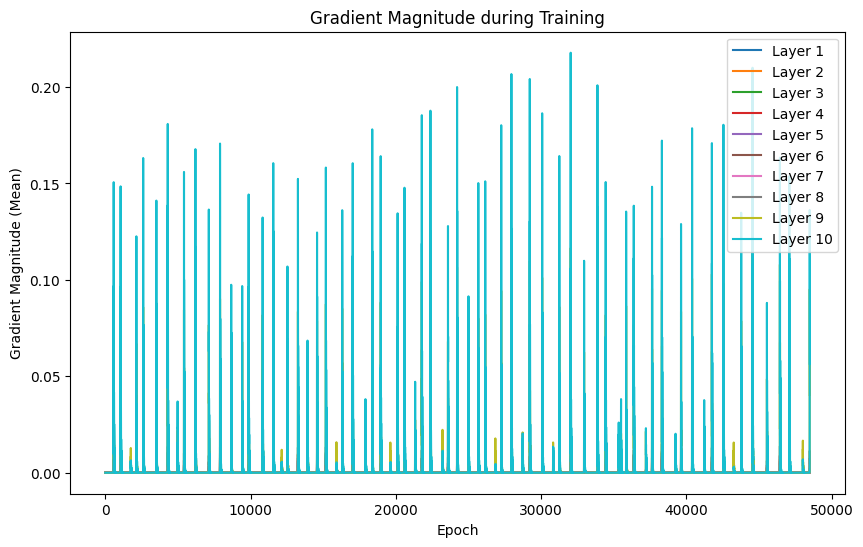

48500 Training Loss: tensor(0.0002)
48501 Training Loss: tensor(0.0005)
48502 Training Loss: tensor(3.8586e-05)
48503 Training Loss: tensor(0.0004)
48504 Training Loss: tensor(0.0001)
48505 Training Loss: tensor(0.0001)
48506 Training Loss: tensor(0.0002)
48507 Training Loss: tensor(3.4307e-05)
48508 Training Loss: tensor(0.0002)
48509 Training Loss: tensor(3.8637e-05)
48510 Training Loss: tensor(0.0001)
48511 Training Loss: tensor(8.7560e-05)
48512 Training Loss: tensor(5.6937e-05)
48513 Training Loss: tensor(0.0001)
48514 Training Loss: tensor(1.9145e-05)
48515 Training Loss: tensor(0.0001)
48516 Training Loss: tensor(2.0089e-05)
48517 Training Loss: tensor(6.7956e-05)
48518 Training Loss: tensor(3.4296e-05)
48519 Training Loss: tensor(3.6204e-05)
48520 Training Loss: tensor(4.7070e-05)
48521 Training Loss: tensor(1.4460e-05)
48522 Training Loss: tensor(4.7410e-05)
48523 Training Loss: tensor(8.7479e-06)
48524 Training Loss: tensor(3.8567e-05)
48525 Training Loss: tensor(1.1223e-05)


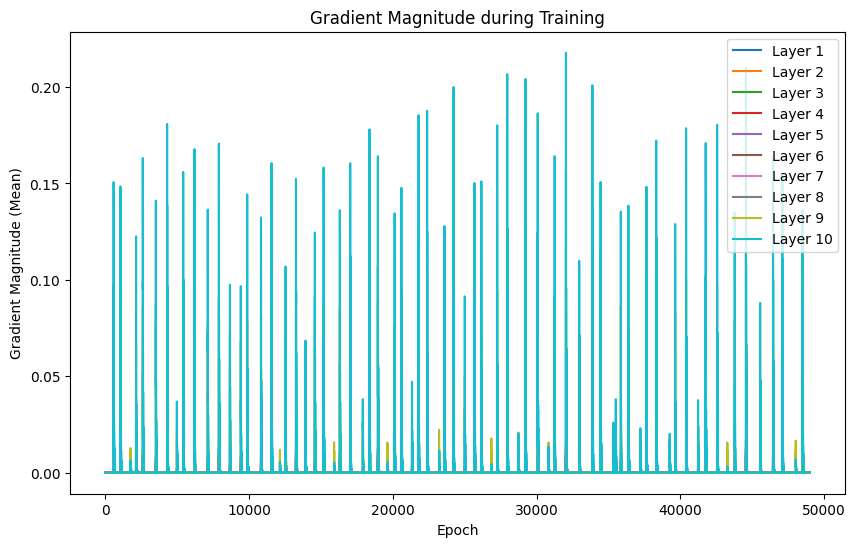

49000 Training Loss: tensor(2.2299e-06)
49001 Training Loss: tensor(2.2301e-06)
49002 Training Loss: tensor(2.2301e-06)
49003 Training Loss: tensor(2.2299e-06)
49004 Training Loss: tensor(2.2300e-06)
49005 Training Loss: tensor(2.2300e-06)
49006 Training Loss: tensor(2.2299e-06)
49007 Training Loss: tensor(2.2299e-06)
49008 Training Loss: tensor(2.2299e-06)
49009 Training Loss: tensor(2.2300e-06)
49010 Training Loss: tensor(2.2299e-06)
49011 Training Loss: tensor(2.2299e-06)
49012 Training Loss: tensor(2.2299e-06)
49013 Training Loss: tensor(2.2299e-06)
49014 Training Loss: tensor(2.2298e-06)
49015 Training Loss: tensor(2.2297e-06)
49016 Training Loss: tensor(2.2298e-06)
49017 Training Loss: tensor(2.2297e-06)
49018 Training Loss: tensor(2.2298e-06)
49019 Training Loss: tensor(2.2297e-06)
49020 Training Loss: tensor(2.2298e-06)
49021 Training Loss: tensor(2.2297e-06)
49022 Training Loss: tensor(2.2297e-06)
49023 Training Loss: tensor(2.2296e-06)
49024 Training Loss: tensor(2.2297e-06)


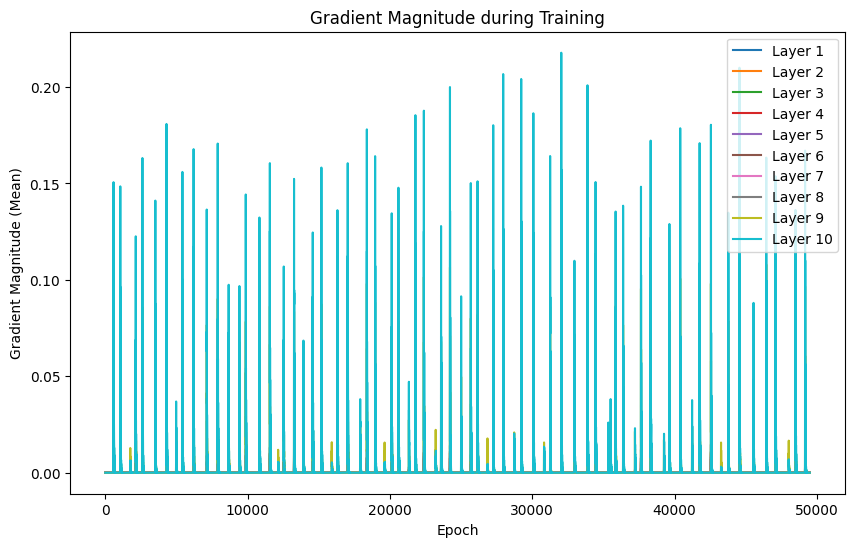

49500 Training Loss: tensor(2.2283e-06)
49501 Training Loss: tensor(2.2284e-06)
49502 Training Loss: tensor(2.2283e-06)
49503 Training Loss: tensor(2.2284e-06)
49504 Training Loss: tensor(2.2285e-06)
49505 Training Loss: tensor(2.2284e-06)
49506 Training Loss: tensor(2.2283e-06)
49507 Training Loss: tensor(2.2282e-06)
49508 Training Loss: tensor(2.2283e-06)
49509 Training Loss: tensor(2.2282e-06)
49510 Training Loss: tensor(2.2281e-06)
49511 Training Loss: tensor(2.2282e-06)
49512 Training Loss: tensor(2.2281e-06)
49513 Training Loss: tensor(2.2280e-06)
49514 Training Loss: tensor(2.2281e-06)
49515 Training Loss: tensor(2.2281e-06)
49516 Training Loss: tensor(2.2281e-06)
49517 Training Loss: tensor(2.2282e-06)
49518 Training Loss: tensor(2.2281e-06)
49519 Training Loss: tensor(2.2280e-06)
49520 Training Loss: tensor(2.2281e-06)
49521 Training Loss: tensor(2.2281e-06)
49522 Training Loss: tensor(2.2281e-06)
49523 Training Loss: tensor(2.2280e-06)
49524 Training Loss: tensor(2.2280e-06)


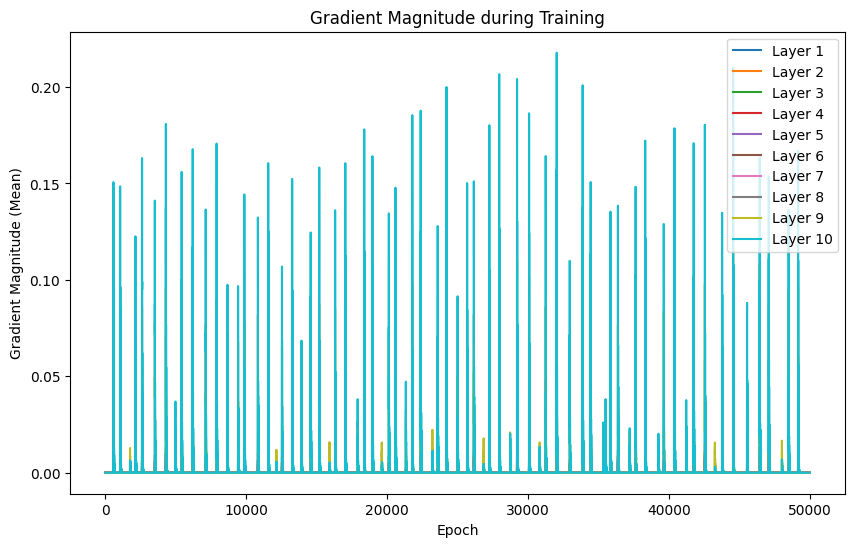

50000 Training Loss: tensor(2.2234e-06)
50001 Training Loss: tensor(2.2235e-06)
50002 Training Loss: tensor(2.2233e-06)
50003 Training Loss: tensor(2.2233e-06)
50004 Training Loss: tensor(2.2234e-06)
50005 Training Loss: tensor(2.2233e-06)
50006 Training Loss: tensor(2.2234e-06)
50007 Training Loss: tensor(2.2234e-06)
50008 Training Loss: tensor(2.2233e-06)
50009 Training Loss: tensor(2.2234e-06)
50010 Training Loss: tensor(2.2234e-06)
50011 Training Loss: tensor(2.2234e-06)
50012 Training Loss: tensor(2.2233e-06)
50013 Training Loss: tensor(2.2233e-06)
50014 Training Loss: tensor(2.2234e-06)
50015 Training Loss: tensor(2.2235e-06)
50016 Training Loss: tensor(2.2233e-06)
50017 Training Loss: tensor(2.2232e-06)
50018 Training Loss: tensor(2.2233e-06)
50019 Training Loss: tensor(2.2233e-06)
50020 Training Loss: tensor(2.2231e-06)
50021 Training Loss: tensor(2.2233e-06)
50022 Training Loss: tensor(2.2233e-06)
50023 Training Loss: tensor(2.2233e-06)
50024 Training Loss: tensor(2.2232e-06)


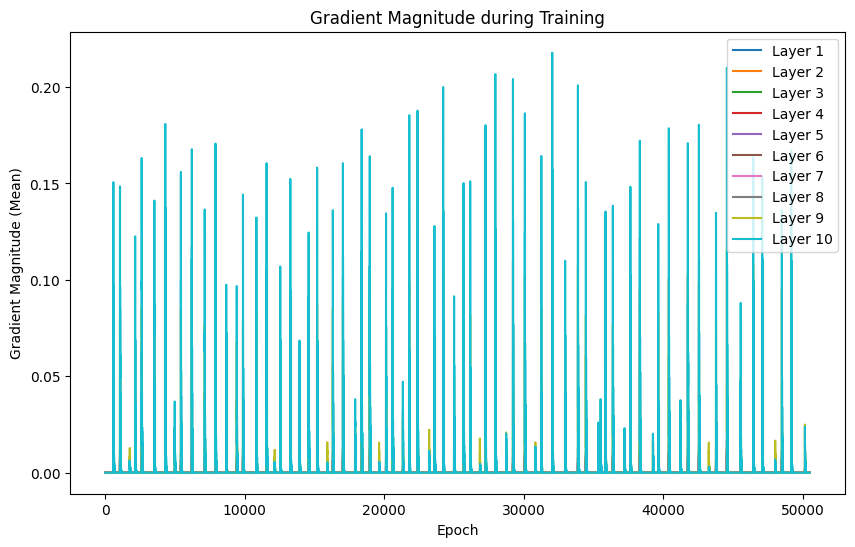

50500 Training Loss: tensor(2.2188e-06)
50501 Training Loss: tensor(2.2188e-06)
50502 Training Loss: tensor(2.2185e-06)
50503 Training Loss: tensor(2.2186e-06)
50504 Training Loss: tensor(2.2186e-06)
50505 Training Loss: tensor(2.2186e-06)
50506 Training Loss: tensor(2.2185e-06)
50507 Training Loss: tensor(2.2187e-06)
50508 Training Loss: tensor(2.2187e-06)
50509 Training Loss: tensor(2.2186e-06)
50510 Training Loss: tensor(2.2186e-06)
50511 Training Loss: tensor(2.2186e-06)
50512 Training Loss: tensor(2.2186e-06)
50513 Training Loss: tensor(2.2186e-06)
50514 Training Loss: tensor(2.2186e-06)
50515 Training Loss: tensor(2.2185e-06)
50516 Training Loss: tensor(2.2186e-06)
50517 Training Loss: tensor(2.2184e-06)
50518 Training Loss: tensor(2.2184e-06)
50519 Training Loss: tensor(2.2184e-06)
50520 Training Loss: tensor(2.2184e-06)
50521 Training Loss: tensor(2.2184e-06)
50522 Training Loss: tensor(2.2184e-06)
50523 Training Loss: tensor(2.2183e-06)
50524 Training Loss: tensor(2.2183e-06)


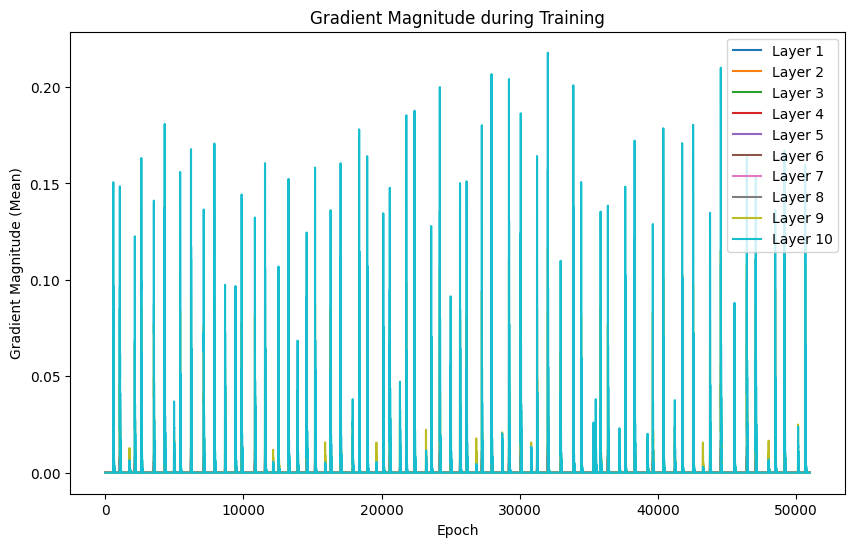

51000 Training Loss: tensor(2.2169e-06)
51001 Training Loss: tensor(2.2169e-06)
51002 Training Loss: tensor(2.2170e-06)
51003 Training Loss: tensor(2.2169e-06)
51004 Training Loss: tensor(2.2169e-06)
51005 Training Loss: tensor(2.2169e-06)
51006 Training Loss: tensor(2.2169e-06)
51007 Training Loss: tensor(2.2169e-06)
51008 Training Loss: tensor(2.2169e-06)
51009 Training Loss: tensor(2.2169e-06)
51010 Training Loss: tensor(2.2170e-06)
51011 Training Loss: tensor(2.2169e-06)
51012 Training Loss: tensor(2.2168e-06)
51013 Training Loss: tensor(2.2167e-06)
51014 Training Loss: tensor(2.2168e-06)
51015 Training Loss: tensor(2.2169e-06)
51016 Training Loss: tensor(2.2168e-06)
51017 Training Loss: tensor(2.2169e-06)
51018 Training Loss: tensor(2.2168e-06)
51019 Training Loss: tensor(2.2168e-06)
51020 Training Loss: tensor(2.2168e-06)
51021 Training Loss: tensor(2.2167e-06)
51022 Training Loss: tensor(2.2168e-06)
51023 Training Loss: tensor(2.2167e-06)
51024 Training Loss: tensor(2.2167e-06)


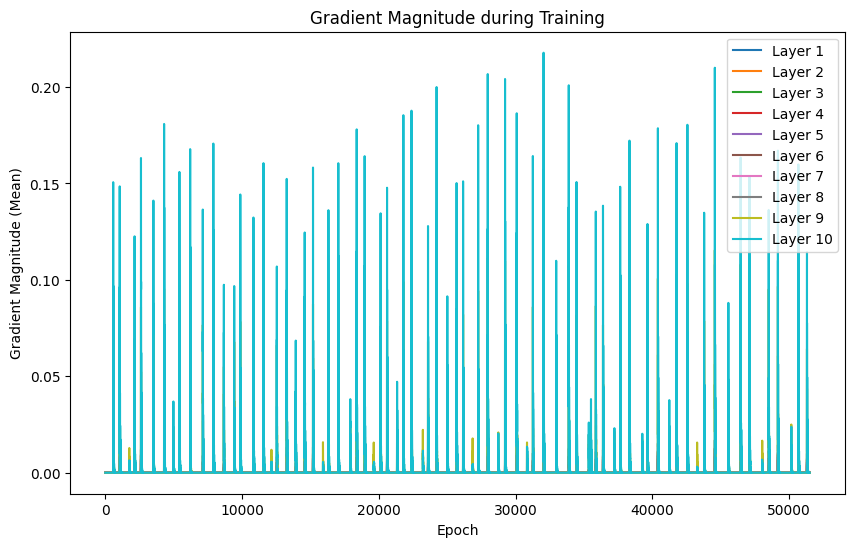

51500 Training Loss: tensor(2.2138e-06)
51501 Training Loss: tensor(2.2138e-06)
51502 Training Loss: tensor(2.2137e-06)
51503 Training Loss: tensor(2.2136e-06)
51504 Training Loss: tensor(2.2137e-06)
51505 Training Loss: tensor(2.2137e-06)
51506 Training Loss: tensor(2.2136e-06)
51507 Training Loss: tensor(2.2137e-06)
51508 Training Loss: tensor(2.2137e-06)
51509 Training Loss: tensor(2.2136e-06)
51510 Training Loss: tensor(2.2135e-06)
51511 Training Loss: tensor(2.2137e-06)
51512 Training Loss: tensor(2.2137e-06)
51513 Training Loss: tensor(2.2136e-06)
51514 Training Loss: tensor(2.2136e-06)
51515 Training Loss: tensor(2.2136e-06)
51516 Training Loss: tensor(2.2136e-06)
51517 Training Loss: tensor(2.2135e-06)
51518 Training Loss: tensor(2.2136e-06)
51519 Training Loss: tensor(2.2136e-06)
51520 Training Loss: tensor(2.2135e-06)
51521 Training Loss: tensor(2.2136e-06)
51522 Training Loss: tensor(2.2135e-06)
51523 Training Loss: tensor(2.2134e-06)
51524 Training Loss: tensor(2.2135e-06)


In [ ]:
### (3) Training / Fitting
iterations = 80000
previous_validation_loss = 99999999.0
gradient_history = []
for epoch in range(iterations):

    optimizer.zero_grad()
    # Loss based on boundary conditions
    x_0 = Variable(torch.from_numpy(x0).float(), requires_grad=False).to(device)
    t_0 = Variable(torch.from_numpy(t0).float(), requires_grad=False).to(device)
    u_0_true = Variable(torch.from_numpy(u0).float(), requires_grad=False).to(device)
    v_0_true = Variable(torch.from_numpy(v0).float(), requires_grad=False).to(device)
    output = model(x_0, t_0) # output of u(x,t)
    # print("u_0_true.shape is ",u_0_true.shape)
    # print("output[:,0].shape is",output[:,0].shape)
    u_0_pred = output[:,0].unsqueeze(1)
    v_0_pred = output[:,1].unsqueeze(1)
    mse_0 = mse_cost_function(u_0_true, u_0_pred) + mse_cost_function(v_0_true, v_0_pred)

    x_lb_input = Variable(torch.from_numpy(x_lb).float(), requires_grad=True).to(device)
    t_lb_input = Variable(torch.from_numpy(t_lb).float(), requires_grad=True).to(device)
    output_lb = model(x_lb_input, t_lb_input)
    u_lb_pred = output_lb[:,0]
    v_lb_pred = output_lb[:,1]
    u_lb_x_pred = torch.autograd.grad(u_lb_pred.sum(), x_lb_input, create_graph=True)[0]
    v_lb_x_pred = torch.autograd.grad(v_lb_pred.sum(), x_lb_input, create_graph=True)[0]

    x_ub_input = Variable(torch.from_numpy(x_ub).float(), requires_grad=True).to(device)
    t_ub_input = Variable(torch.from_numpy(t_ub).float(), requires_grad=True).to(device)
    output_ub = model(x_ub_input, t_ub_input)
    u_ub_pred = output_ub[:,0]
    v_ub_pred = output_ub[:,1]
    u_ub_x_pred = torch.autograd.grad(u_ub_pred.sum(), x_ub_input, create_graph=True)[0]
    v_ub_x_pred = torch.autograd.grad(v_ub_pred.sum(), x_ub_input, create_graph=True)[0]
    mse_b = mse_cost_function(u_lb_pred, u_ub_pred) + mse_cost_function(v_lb_pred, v_ub_pred) + mse_cost_function(v_lb_x_pred, v_ub_x_pred) + mse_cost_function(v_ub_x_pred, v_lb_x_pred)

    x_f_input = Variable(torch.from_numpy(x_f).float(),requires_grad = True).to(device)
    t_f_input = Variable(torch.from_numpy(t_f).float(), requires_grad = True).to(device)
    output_f = model(x_f_input, t_f_input)
    f_u, f_v = f(output_f, x_f_input, t_f_input)
    # print("f_u.shape is ",f_u.shape)
    # print("f_v.shape is ",f_v.shape)
    zero = torch.zeros(len(f_u)).unsqueeze(1)
    mse_f = mse_cost_function(f_u, zero) + mse_cost_function(f_v, zero)
    loss = mse_0 + mse_b + mse_f
    loss.backward()
    gradient_means = monitor_gradients(model)
    gradient_history.append(gradient_means)
    optimizer.step()
    # scheduler.step()
    # mse_f = mse_cost_function(f_out, pt_all_zeros)

    # # Combining the loss functions
    # loss = mse_u + mse_f


    # loss.backward() # This is for computing gradients using backward propagation
    # optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta
    if epoch % 500 == 0:
        # Visualize gradients over epochs
        plt.figure(figsize=(10, 6))
        for i, layer_gradients in enumerate(zip(*gradient_history)):
            plt.plot(layer_gradients, label=f'Layer {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Gradient Magnitude (Mean)')
        plt.title('Gradient Magnitude during Training')
        plt.legend()
        plt.show()
    if epoch % 1000 == 999:
        print("saved")
        PATH = "/content/drive/My Drive/7014Models/model_3.pth"
        checkpoint = {
            'epoch': num_epochs,                 # Current epoch
            'model_state_dict': model.state_dict(),  # Model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # Optimizer parameters
            'loss': loss                    # Loss value (optional)
        }
        torch.save(checkpoint, PATH)
    with torch.autograd.no_grad():
    	  print(epoch,"Training Loss:",loss.data)

In [ ]:
PATH = "/content/drive/My Drive/7014Models/model_3.pth"
checkpoint = {
    'epoch': num_epochs,                 # Current epoch
    'model_state_dict': model.state_dict(),  # Model parameters
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer parameters
    'loss': loss                    # Loss value (optional)
}
torch.save(checkpoint, PATH)

In [ ]:
print(u_star[:,:].shape)
print(len(X_star[:,0]))


In [ ]:
#X_test = np.array([element for i, element in enumerate(X_star) if i not in idx_x])

In [ ]:
#X_test = X_test.reshape(len(X_test),2)
#print(X_test.shape)

In [ ]:
X_test = X_star[:,0]
T_test = X_star[:,1]
print(x0.shape)

In [ ]:
##prediction
#x_input = X_test.reshape(len(x0),1)
#t_input = T_test.reshape(len(t0),1)
# Loss based on boundary conditions
x_0 = Variable(torch.from_numpy(x0).float(), requires_grad=False).to(device)
t_0 = Variable(torch.from_numpy(t0).float(), requires_grad=False).to(device)
u_0_true = Variable(torch.from_numpy(u0).float(), requires_grad=False).to(device)
v_0_true = Variable(torch.from_numpy(v0).float(), requires_grad=False).to(device)
output = model(x_0, t_0) # output of u(x,t)
# print("u_0_true.shape is ",u_0_true.shape)
# print("output[:,0].shape is",output[:,0].shape)
u_pred = output[:,0].unsqueeze(1)
v_pred = output[:,1].unsqueeze(1)
h_pred = torch.sqrt(u_pred**2 + v_pred**2)
mse_0 = mse_cost_function(u_0_true, u_pred) + mse_cost_function(v_0_true, v_pred)

# x_lb_input = Variable(torch.from_numpy(x_lb).float(), requires_grad=True).to(device)
# t_lb_input = Variable(torch.from_numpy(t_lb).float(), requires_grad=True).to(device)
# output_lb = model(x_lb_input, t_lb_input)
# u_lb_pred = output_lb[:,0]
# v_lb_pred = output_lb[:,1]
# u_lb_x_pred = torch.autograd.grad(u_lb_pred.sum(), x_lb_input, create_graph=True)[0]
# v_lb_x_pred = torch.autograd.grad(v_lb_pred.sum(), x_lb_input, create_graph=True)[0]

# x_ub_input = Variable(torch.from_numpy(x_ub).float(), requires_grad=True).to(device)
# t_ub_input = Variable(torch.from_numpy(t_ub).float(), requires_grad=True).to(device)
# output_ub = model(x_ub_input, t_ub_input)
# u_ub_pred = output_ub[:,0]
# v_ub_pred = output_ub[:,1]
# u_ub_x_pred = torch.autograd.grad(u_ub_pred.sum(), x_ub_input, create_graph=True)[0]
# v_ub_x_pred = torch.autograd.grad(v_ub_pred.sum(), x_ub_input, create_graph=True)[0]
# mse_b = mse_cost_function(u_lb_pred, u_ub_pred) + mse_cost_function(v_lb_pred, v_ub_pred) + mse_cost_function(v_lb_x_pred, v_ub_x_pred) + mse_cost_function(v_ub_x_pred, v_lb_x_pred)

x_test = X_star[:,0].reshape(len(X_star[:,0]),1)
t_test = X_star[:,1].reshape(len(X_star[:,1]),1)

x_f_input = Variable(torch.from_numpy(x_test).float(),requires_grad = True).to(device)
t_f_input = Variable(torch.from_numpy(t_test).float(), requires_grad = True).to(device)
output_f = model(x_f_input, t_f_input)
f_u, f_v = f(output_f, x_f_input, t_f_input)
f_h = torch.sqrt(f_u**2 + f_v**2)
# print("f_u.shape is ",f_u.shape)
# print("f_v.shape is ",f_v.shape)
zero = torch.zeros(len(f_u)).unsqueeze(1)
mse_f = mse_cost_function(f_u, zero) + mse_cost_function(f_v, zero)
loss = mse_0  + mse_f
print(loss)

In [ ]:
u_pred = output_f[:,0].unsqueeze(1)
v_pred = output_f[:,1].unsqueeze(1)
u_true = Variable(torch.from_numpy(u_star).float(),requires_grad = True).to(device)
v_true = Variable(torch.from_numpy(v_star).float(),requires_grad = True).to(device)
u_pred_numpy = u_pred.cpu().detach().numpy()
v_pred_numpy = v_pred.cpu().detach().numpy()
h_pred_numpy = np.sqrt(u_pred_numpy ** 2 + v_pred_numpy ** 2)
error_u = np.linalg.norm(u_star-u_pred_numpy,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred_numpy,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred_numpy,2)/np.linalg.norm(h_star,2)
print(error_u)
print(error_v)
print(error_h)
mse_u = mse_cost_function(u_pred,u_true)
mse_v = mse_cost_function(v_pred, v_true)
loss = mse_u + mse_v
print(loss)

last time:
0.006633546758915064
0.012748135405543702
0.007268907824886417
tensor(7.1077e-05, grad_fn=<AddBackward0>)

In [ ]:
print(type(x_0))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True



# print(x.shape)
# u = 6*np.exp(-3*x - 2*t)
# sample_size = 100
# idx = np.random.randint(0, 999, size=300)
# sampled_x = x[idx]  # Sampled values
# sampled_t = t[idx]
# sampled_x = sampled_x.reshape(len(sampled_x), 1)
# sampled_t = sampled_t.reshape(len(sampled_t), 1)
# pt_x_bc = Variable(torch.from_numpy(sampled_x).float(), requires_grad=False).to(device)
# pt_t_bc = Variable(torch.from_numpy(sampled_t).float(), requires_grad=False).to(device)
# u_pred = net(pt_x_bc,pt_t_bc)
# u_pred = torch.detach(u_pred).numpy()
plt.plot(x_test, output_f[:,0].detach().cpu().numpy(), color='red', label='true')
#plt.plot(xpoints, ypoints, 'o')
plt.plot(x_test, u_star, 'o', color='blue', label='pred', markersize = 1)
plt.xlabel('x value')
plt.ylabel('u value')
plt.show()

In [ ]:
#Test Poisson equation first, parabolic eqution, heat equation
#finite difference for finding reference solution
#high dimension problems:
print(X_star.shape)

In [ ]:
total = np.concatenate((X_star,u_star,v_star,h_star), axis = 1)
print(total.shape)
test_2 = np.array([element for i, element in enumerate(total) if (element[1] >= 0.78 and element[1] <= 0.789)])
print(test_2.shape)

In [ ]:
x_test_2 = test_2[:,0].reshape(len(test_2[:,0]),1)
t_test_2 = test_2[:,1].reshape(len(test_2[:,1]),1)
x_test_2 = Variable(torch.from_numpy(x_test_2).float(),requires_grad = True).to(device)
t_test_2 = Variable(torch.from_numpy(t_test_2).float(),requires_grad = True).to(device)
u_exact_2 = test_2[:,2]
v_exact_2 = test_2[:,3]
h_exact_2 = test_2[:,4]
output = model(x_test_2, t_test_2)
u_pred = output[:,0]
v_pred = output[:,1]
h_pred = torch.sqrt(torch.square(u_pred) + torch.square(v_pred)).unsqueeze(1)

In [ ]:
print(x_test_2.shape)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True




#plt.plot(xpoints, ypoints, 'o')
plt.plot(x_test_2.detach().cpu().numpy(), h_exact_2, 'o', color='blue', label='pred', markersize = 1)
plt.plot(x_test_2.detach().cpu().numpy(), h_pred.detach().cpu().numpy(), color='red', label='true')
plt.xlabel('x value')
plt.ylabel('u value')
plt.show()